In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import optuna
import joblib
import re
import ast

# PREPROCESSING AND EVALUATION
import category_encoders as ce
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from scipy.stats import norm
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error
from collections import Counter

# REGRESSION
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso

# OTHER
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)

In [2]:
# function for univariate analysis of numerical variables
# outputs a handful of descriptive statistics, a histogram, and a box plot
def num_univariate(df, col, transformation_description):
    stats = {'Number of unique values': df[col].nunique(),
             'Minimum': df[col].min(),
             'Maximum': df[col].max(),
             'Range': df[col].max()-df[col].min(),
             'Skewness': df[col].skew(),
             'Kurtosis': df[col].kurt()}
    stats = pd.DataFrame(stats.values(), index=stats.keys(), columns=[col])
    display(stats)
    
    fig = plt.figure(figsize=(15,5), constrained_layout=True)
    gs = fig.add_gridspec(3,1)
    ax1 = fig.add_subplot(gs[0:2])
    sns.distplot(df[col], fit=norm)
    ax1.set_title('{} {} Distribution vs. Gaussian Distribution'.format(transformation_description, col))
    ax1.set_xlabel('')
    ax2 = fig.add_subplot(gs[2])
    sns.boxplot(df[col])
    ax2.set_title('{} {} Distribution'.format(transformation_description, col))
    
# renames columns of dataframe of Optuna study trials (contains hyper-parameter values and error scores)
def rename_columns(study_df):
    # removes 'params_' from column names
    for c in study_df.columns.tolist():
        if re.search("params_", c):
            new_name = re.search("params_(.+)", c).group(1)
            study_df.rename(columns={c: new_name}, inplace=True)

In [3]:
train_and_test = pd.read_csv('train.csv')
predict = pd.read_csv('test.csv')
predict['revenue'] = 'NONE'
full = pd.concat([train_and_test, predict], ignore_index=True)    # needed just to perform a few sanity checks

train, test = train_test_split(train_and_test, test_size=.15, random_state=0)
datasets = [train, test, predict]
train.name='train'
test.name='test'
predict.name='predict'

In [4]:
train.shape, test.shape, predict.shape
train.head(1)

((2550, 23), (450, 23), (4398, 23))

id belongs_to_collection   budget  \
422  423                   NaN  2900000   

                                                genres  \
422  [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...   

                              homepage    imdb_id original_language  \
422  http://www.blackdynamitemovie.com  tt1190536                en   

     original_title                                           overview  \
422  Black Dynamite  This is the story of 1970s African-American ac...   

     popularity                       poster_path  \
422    10.92143  /eMpxFQuEwU4HRA4SOfEpZKAtPxb.jpg   

                                  production_companies  \
422  [{'name': 'Destination Films', 'id': 769}, {'n...   

                                  production_countries release_date  runtime  \
422  [{'iso_3166_1': 'US', 'name': 'United States o...     10/16/09     90.0   

                                      spoken_languages    status  \
422  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   

                                       tagline           title  \
422  He's super bad. He's outta sight. He's...  Black Dynamite   

                                              Keywords  \
422  [{'id': 577, 'name': 'black people'}, {'id': 1...   

                                                  cast  \
422  [{'cast_id': 1, 'character': 'Black Dynamite',...   

                                                  crew  revenue  
422  [{'credit_id': '53bac882c3a3685eb7007294', 'de...   296557

In [5]:
# sanity checks
print('Number of duplicate ids in the full dataset:', full.id.duplicated().sum())
print('Number of duplicate imdb_ids in the full dataset:', full.imdb_id.duplicated().sum())
print('Number of samples in the full dataset that are exactly the same, except for their ids:', full.drop('id', axis=1).duplicated().sum())
print('Number of samples in the full dataset that are exactly the same, except for their imdb_ids:', full.drop('id', axis=1).duplicated().sum())

Number of duplicate ids in the full dataset: 0
Number of duplicate imdb_ids in the full dataset: 0
Number of samples in the full dataset that are exactly the same, except for their ids: 0
Number of samples in the full dataset that are exactly the same, except for their imdb_ids: 0


The entries of some of the columns in the datasets are strings containing lists of dictionaries. Let's evaluate these strings so that we can later extract the information we need from the containers.

In [6]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

for d in datasets:
    d = text_to_dict(d)

# Preliminary EDA, Feature Extraction and Missing Value Handling

After a quick glance at the data, it is apparent that many columns are not only unusable for machine learning algorithms but are also hard to read for a person. In this part of the project, we will go through the columns one by one, perform some preliminary feature extraction, and then drop problematic columns and columns that we will not use.

## Target Column: revenue

In [7]:
print('Number of missing values in the revenue column of the train set:', train.revenue.isna().sum())
print('Number of missing values in the revenue column of the test set:', test.revenue.isna().sum())

Number of missing values in the revenue column of the train set: 0
Number of missing values in the revenue column of the test set: 0


In [8]:
print('Number of movies with a revenue of zero in the train set:', len(train.loc[train['revenue']==0, 'revenue']))
print('Number of movies with a revenue of zero in the test set:', len(test.loc[test['revenue']==0, 'revenue']))

Number of movies with a revenue of zero in the train set: 0
Number of movies with a revenue of zero in the test set: 0


In [9]:
train.revenue.head()

422        296557
838      16803753
1735    920100000
746        249905
900      16863583
Name: revenue, dtype: int64

revenue
Number of unique values  2.431000e+03
Minimum                  1.000000e+00
Maximum                  1.519558e+09
Range                    1.519558e+09
Skewness                 4.562317e+00
Kurtosis                 2.788081e+01

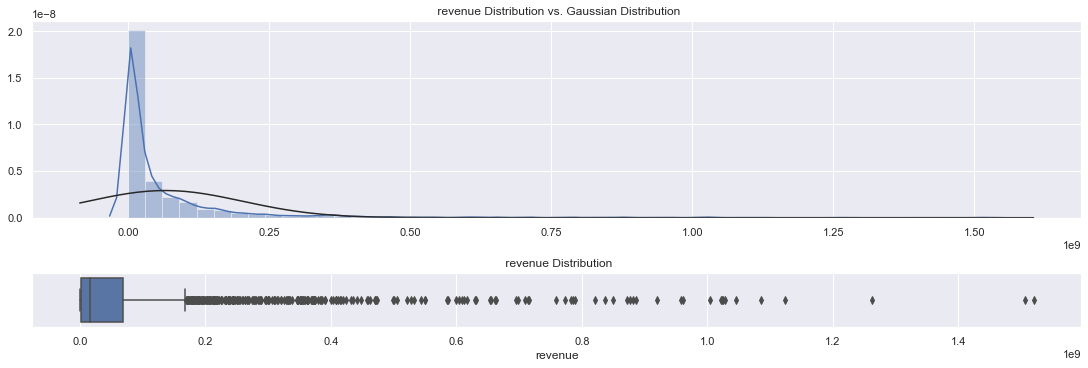

In [10]:
num_univariate(train, 'revenue', '')

In [11]:
revenue_transformer = PowerTransformer()
train.revenue = revenue_transformer.fit_transform(train[['revenue']])
test.revenue = revenue_transformer.transform(test[['revenue']])

revenue
Number of unique values  2431.000000
Minimum                    -2.484325
Maximum                     2.842669
Range                       5.326995
Skewness                   -0.083832
Kurtosis                   -0.356631

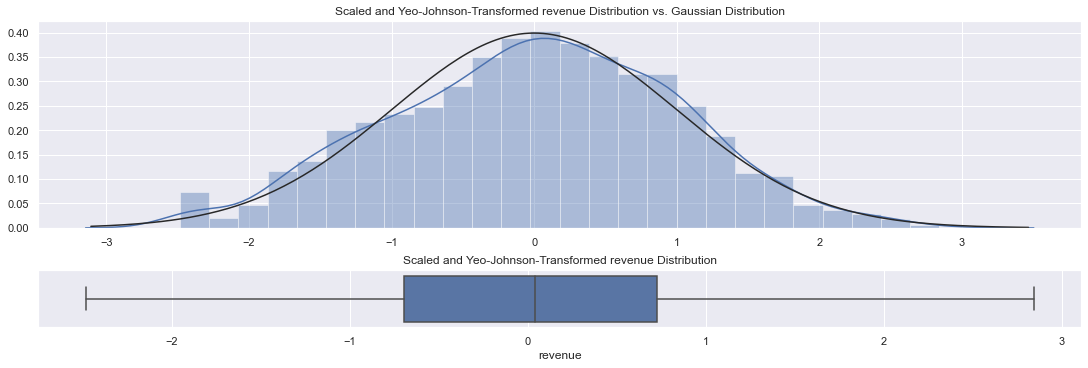

In [12]:
num_univariate(train, 'revenue', 'Scaled and Yeo-Johnson-Transformed')

## Numerical Columns
As we can see below, the three original numerical predictor variables––budget, popularity, and runtime––should be power transformed, similarly to the revenue column. Later in the project, we will perform this power transformation on these three original features together with some new numerical features that we will generate ourselves.

### budget

In [13]:
for d in datasets:
    print('Number of missing values in the budget column of the {} set:'.format(d.name), d['budget'].isna().sum())

Number of missing values in the budget column of the train set: 0
Number of missing values in the budget column of the test set: 0
Number of missing values in the budget column of the predict set: 0


In [14]:
for d in datasets:
    print('Number of movies with a budget of zero in the {} set:'.format(d.name), len(d.loc[d['budget']==0, 'budget']))

Number of movies with a budget of zero in the train set: 681
Number of movies with a budget of zero in the test set: 131
Number of movies with a budget of zero in the predict set: 1211


In [15]:
train.loc[train.budget==0, ['title', 'budget', 'production_companies']].head()

title  budget  \
838                 Hollywoodland       0   
841                Material Girls       0   
1765                Desert Flower       0   
2754                     The Clan       0   
1280  In This Corner of the World       0   

                                   production_companies  
838           [{'name': 'Focus Features', 'id': 10146}]  
841   [{'name': 'Patriot Pictures', 'id': 2373}, {'n...  
1765  [{'name': 'Desert Flower Filmproductions', 'id...  
2754  [{'name': 'El Deseo', 'id': 49}, {'name': 'Mat...  
1280  [{'name': 'GENCO', 'id': 5751}, {'name': 'MAPP...

In [16]:
# prepare for imputation later in the project and create a 'missing' indicator column
for d in datasets:
    d.loc[d.budget==0, 'budget'] = np.nan
    d['budget_missing'] = d['budget'].apply(lambda x: 1 if pd.isna(x) else 0)

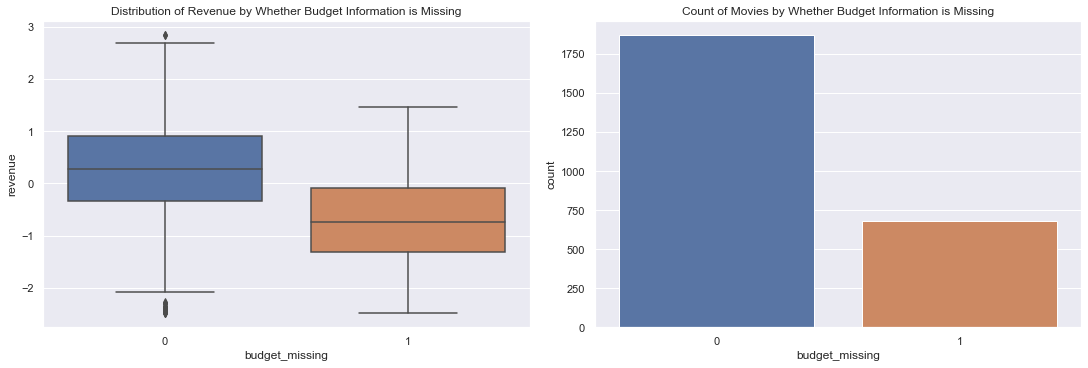

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
axes[0].set_title('Distribution of Revenue by Whether Budget Information is Missing')
sns.boxplot('budget_missing', 'revenue', data=train, ax=axes[0])
axes[1].set_title('Count of Movies by Whether Budget Information is Missing')
sns.countplot(train.budget_missing, ax=axes[1]);

In [18]:
train.budget.head()

422      2900000.0
838            NaN
1735    63000000.0
746        50000.0
900     20000000.0
Name: budget, dtype: float64

budget
Number of unique values  3.710000e+02
Minimum                  1.000000e+00
Maximum                  3.800000e+08
Range                    3.800000e+08
Skewness                 2.729006e+00
Kurtosis                 1.034028e+01

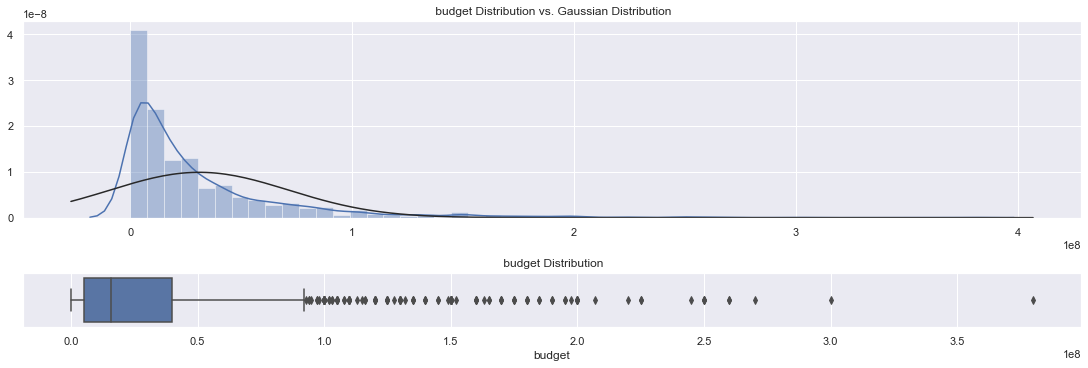

In [19]:
num_univariate(train, 'budget', '')

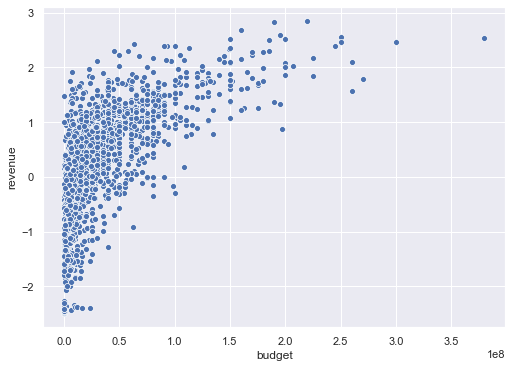

In [20]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.scatterplot(train.budget, train.revenue);

### popularity

In [21]:
for d in datasets:
    print('Number of missing values in the popularity column of the {} set:'.format(d.name), d['popularity'].isna().sum())

Number of missing values in the popularity column of the train set: 0
Number of missing values in the popularity column of the test set: 0
Number of missing values in the popularity column of the predict set: 0


In [22]:
for d in datasets:
    print('Number of movies with a popularity of zero in the {} set:'.format(d.name), len(d.loc[d['popularity']==0, 'popularity']))

Number of movies with a popularity of zero in the train set: 0
Number of movies with a popularity of zero in the test set: 0
Number of movies with a popularity of zero in the predict set: 0


In [23]:
train.popularity.head()

422     10.921430
838      7.464981
1735     8.863776
746     11.329733
900     11.112153
Name: popularity, dtype: float64

popularity
Number of unique values  2550.000000
Minimum                     0.000001
Maximum                   294.337037
Range                     294.337036
Skewness                   14.603453
Kurtosis                  284.440822

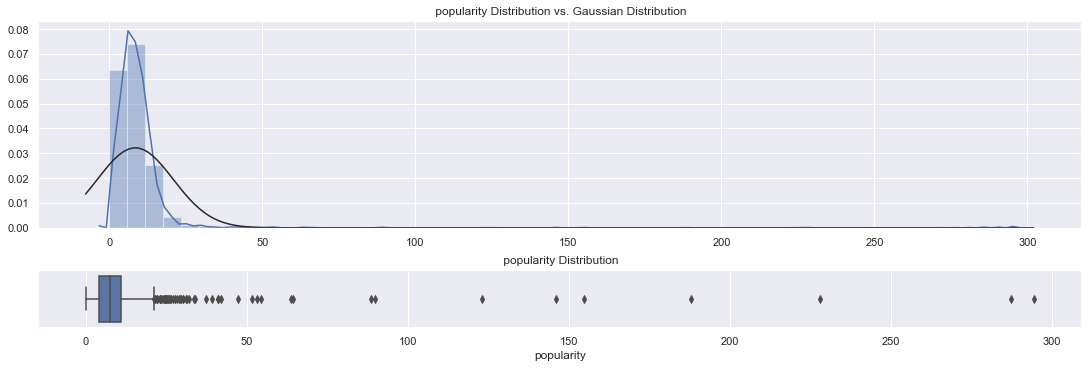

In [24]:
num_univariate(train, 'popularity', '')

In [25]:
print('Correlation between popularity and revenue:', train[['revenue', 'popularity']].corr().loc['revenue', 'popularity'])

Correlation between popularity and revenue: 0.3518448611993187


The popularity scale is nonintuitive. The minimum value is 0.000001, and the maximum is 294.337037, with most films having a popularity of under 25. Upon a little bit of [research](https://developers.themoviedb.org/3/getting-started/popularity), the popularity score is a function of the following variables: the number of votes for the day, number of views for the day, number of users who marked it as a "favourite" for the day, number of users who added it to their "watchlist" for the day, release date, number of total votes, and previous days score. Movies have popularity scores not only after, but also before, they are released.

The popularity of a movie after it has been released is not something that is available prior to the release. Hence, if we want to build a model that predicts the box office revenue of a movie prior to its release, we should not include the popularity score as a feature. However, for the sake of this competition, we will use this column, as it has a relatively high correlation with revenue (approximately 0.35).

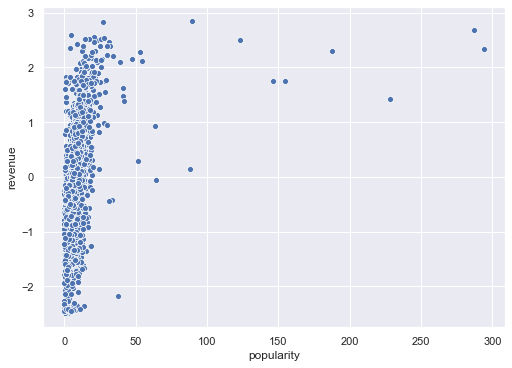

In [26]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.scatterplot(train.popularity, train.revenue);

### runtime

In [27]:
for d in datasets:
    print('Number of missing values in the runtime column of the {} set:'.format(d.name), d['runtime'].isna().sum())

Number of missing values in the runtime column of the train set: 2
Number of missing values in the runtime column of the test set: 0
Number of missing values in the runtime column of the predict set: 4


In [28]:
for d in datasets:
    print('Number of movies with a runtime of zero in the {} set:'.format(d.name), len(d.loc[d['runtime']==0, 'runtime']))

Number of movies with a runtime of zero in the train set: 7
Number of movies with a runtime of zero in the test set: 5
Number of movies with a runtime of zero in the predict set: 9


In [29]:
# prepare for imputation later in the project and create a 'missing' indicator column
for d in datasets:
    d.loc[d.runtime==0, 'runtime'] = np.nan
    d['runtime_missing'] = d['runtime'].apply(lambda x: 1 if pd.isna(x) else 0)

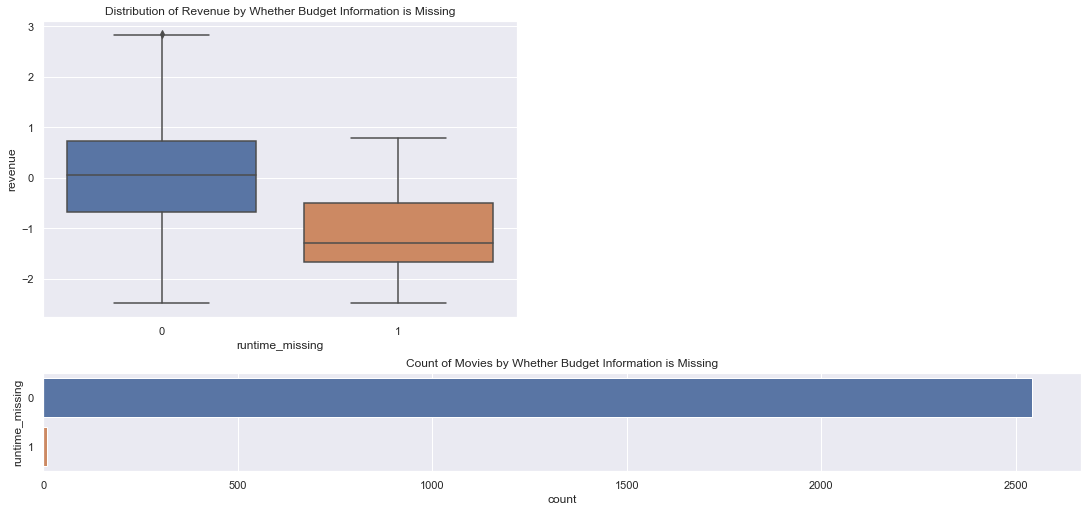

In [30]:
fig = plt.figure(figsize=(15,7), constrained_layout=True)
gs = fig.add_gridspec(4,6)
ax1 = fig.add_subplot(gs[0:3,0:2])
ax1.set_title('Distribution of Revenue by Whether Budget Information is Missing')
sns.boxplot('runtime_missing', 'revenue', data=train)
ax2 = fig.add_subplot(gs[3,:])
ax2.set_title('Count of Movies by Whether Budget Information is Missing')
sns.countplot(y=train.runtime_missing);

runtime
Number of unique values  132.000000
Minimum                   11.000000
Maximum                  338.000000
Range                    327.000000
Skewness                   1.732746
Kurtosis                   8.569791

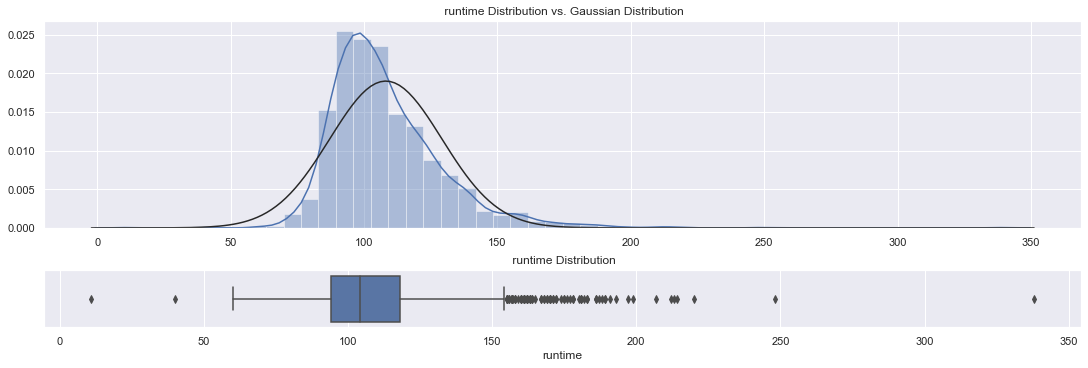

In [31]:
num_univariate(train, 'runtime', '')

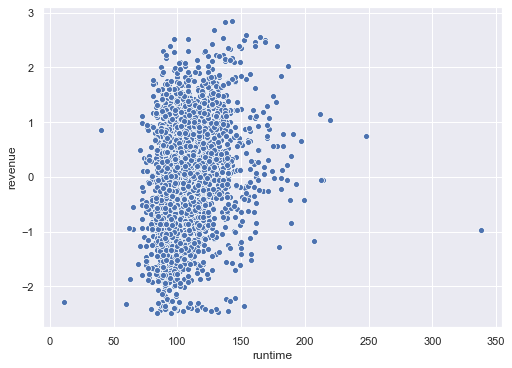

In [32]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.scatterplot(train.runtime, train.revenue);

## Non-Numerical Columns

### belongs_to_collection

In [33]:
for d in datasets:
    print('Percentage of missing values in the belongs_to_collection column of the {} set:'.format(d.name),\
          len(d[d['belongs_to_collection']=={}]))

Percentage of missing values in the belongs_to_collection column of the train set: 2043
Percentage of missing values in the belongs_to_collection column of the test set: 353
Percentage of missing values in the belongs_to_collection column of the predict set: 3521


In [34]:
for i, e in train.belongs_to_collection[0:5].iteritems():
    print(i, e)

422 {}
838 {}
1735 [{'id': 328, 'name': 'Jurassic Park Collection', 'poster_path': '/qIm2nHXLpBBdMxi8dvfrnDkBUDh.jpg', 'backdrop_path': '/pJjIH9QN0OkHFV9eue6XfRVnPkr.jpg'}]
746 {}
900 {}


A movie belongs to a collection if it has a sequel or is a sequel itself, i.e., if it is not a standalone film. No movie can belong to multiple collections.

Of all information presented in this column, we are interested in the collection name (or id) and whether the movie belongs to a collection or not. We will create a new feature (collection_name) that will––for every movie––contain either its collection name or 0, indicating that the movie does not belong to one. We will also create a binary feature has_collection.

One other feature we could extract is the number of films belonging to the collection that a movie is in. For instance, if a movie is in a collection with two movies in it, including itself, then the feature value would be 2. However, the number of movies in a collection that we have a access to is not the actual number of movies in that collection. Rather, it is the number of movies in that collection that are present in our data. As result, there are a lot of movies in our data that are in a collection of one movie (itself). Hence, a movie that––according to the available data––is in a collection of two, might in reality have more sequels than a movie that is in a colletion of five. Hence, we will not be creating this attribute.

Then, we will drop the belongs_to_collection column.

In [35]:
for d in datasets:
    d['collection_name'] = d['belongs_to_collection'].apply(lambda x: x[0]['name'] if len(x)!=0 else 0)
    d['has_collection'] = d['belongs_to_collection'].apply(lambda x: 1 if len(x)!=0 else 0)
    # for a plot, won't be used in the model
    d['movies_in_collection'] = d['collection_name'].apply(lambda x: len(d[d.collection_name==x]) if x!=0 else 0)


In [36]:
train.collection_name.value_counts()

0                                         2043
James Bond Collection                       14
Friday the 13th Collection                   5
Pokémon Collection                           5
The Pink Panther (Original) Collection       5
                                          ... 
Free Willy Collection                        1
Pee-wee's Collection                         1
The Raid Collection                          1
Caddyshack Collection                        1
Shaft Collection                             1
Name: collection_name, Length: 375, dtype: int64

Create a feature that––for each movie––specifies how many movies are in the collection this movie is in (including itself). If a movie is not in  a collection, the feature value will be zero.

<Figure size 504x360 with 0 Axes>

Text(0.5, 1.0, 'Count of Movies by Number of Films in Their Collection')

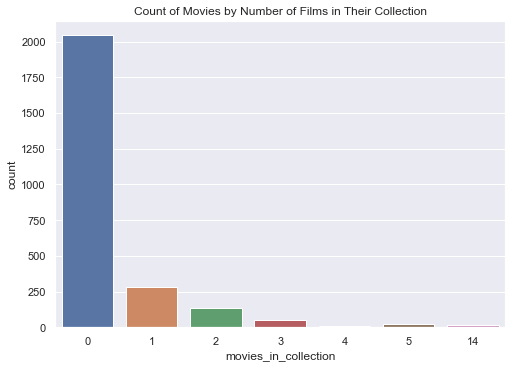

In [37]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.countplot(x=train.movies_in_collection)
plt.title('Count of Movies by Number of Films in Their Collection')

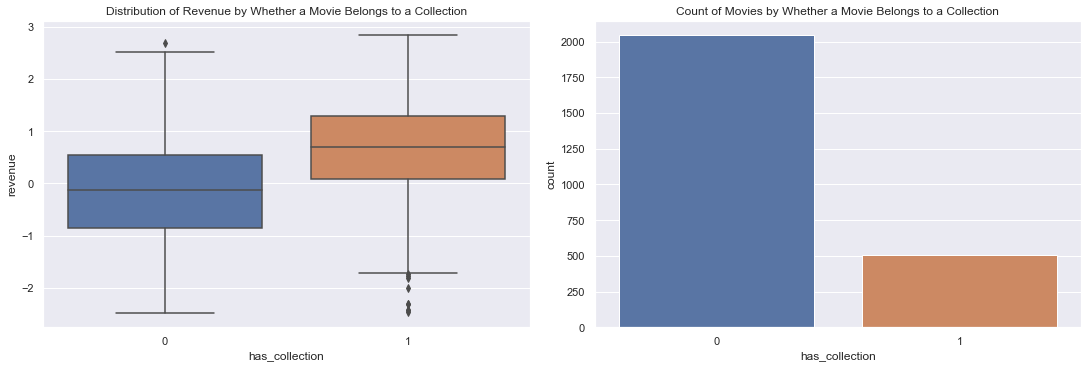

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot(train.has_collection, train.revenue, ax=axes[0])
axes[0].set_title('Distribution of Revenue by Whether a Movie Belongs to a Collection')
sns.countplot(train.has_collection, ax=axes[1])
axes[1].set_title('Count of Movies by Whether a Movie Belongs to a Collection');

### genres

In [39]:
for d in datasets:
    print('Number of missing values in the genres column of the {} set:'.format(d.name), len(d[d['genres']=={}]))

Number of missing values in the genres column of the train set: 7
Number of missing values in the genres column of the test set: 0
Number of missing values in the genres column of the predict set: 16


In [40]:
for i, e in train.genres[0:5].iteritems():
    print(i, e)

422 [{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}]
838 [{'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}, {'id': 80, 'name': 'Crime'}]
1735 [{'id': 12, 'name': 'Adventure'}, {'id': 878, 'name': 'Science Fiction'}]
746 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}, {'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}]
900 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [41]:
for d in datasets:
    d['all_genres'] = d['genres'].apply(lambda x: sorted([i['name'] for i in x]) if len(x)!=0 else {})
    d['genres_missing'] = d['genres'].apply(lambda x: 1 if len(x)==0 else 0)
    d['num_genres'] = d['genres'].apply(lambda x: len(x) if len(x)!=0 else np.nan)    # NaNs will be imputed later in the project

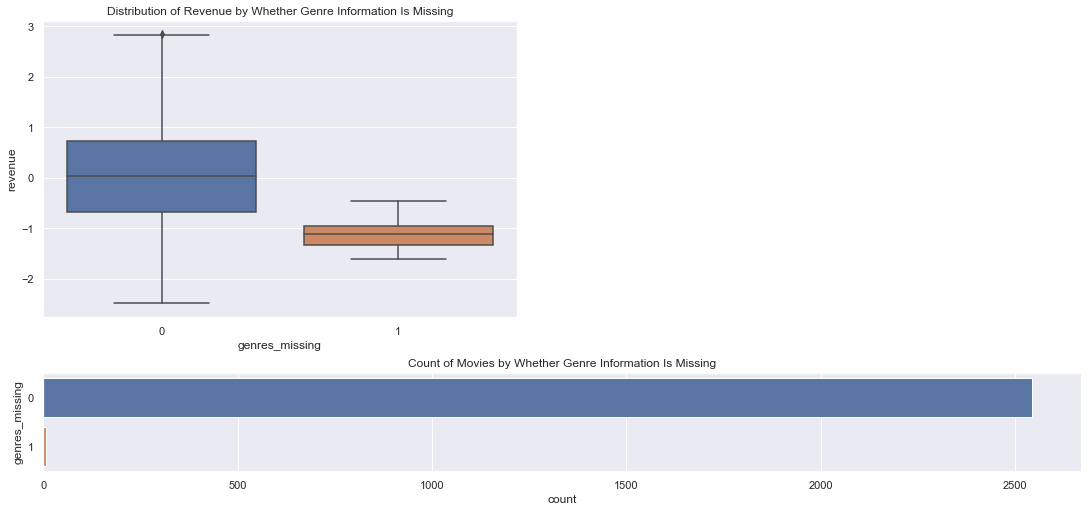

In [42]:
fig = plt.figure(figsize=(15,7), constrained_layout=True)
gs = fig.add_gridspec(4,6)
ax1 = fig.add_subplot(gs[0:3,0:2])
sns.boxplot(train.genres_missing, train.revenue)
ax1.set_title('Distribution of Revenue by Whether Genre Information Is Missing')
ax2 = fig.add_subplot(gs[3,:])
sns.countplot(y=train.genres_missing)
ax2.set_title('Count of Movies by Whether Genre Information Is Missing');

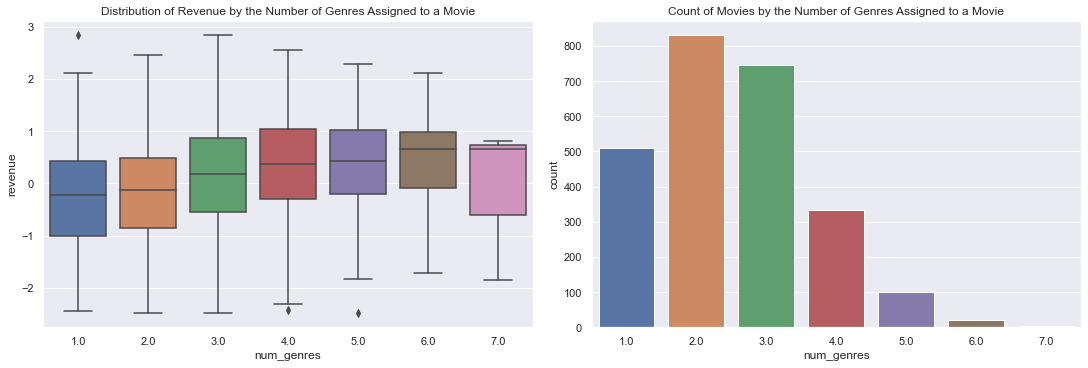

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
axes[0].set_title('Distribution of Revenue by the Number of Genres Assigned to a Movie')
sns.boxplot('num_genres', 'revenue', data=train, ax=axes[0])
axes[1].set_title('Count of Movies by the Number of Genres Assigned to a Movie')
sns.countplot(train.num_genres, ax=axes[1]);

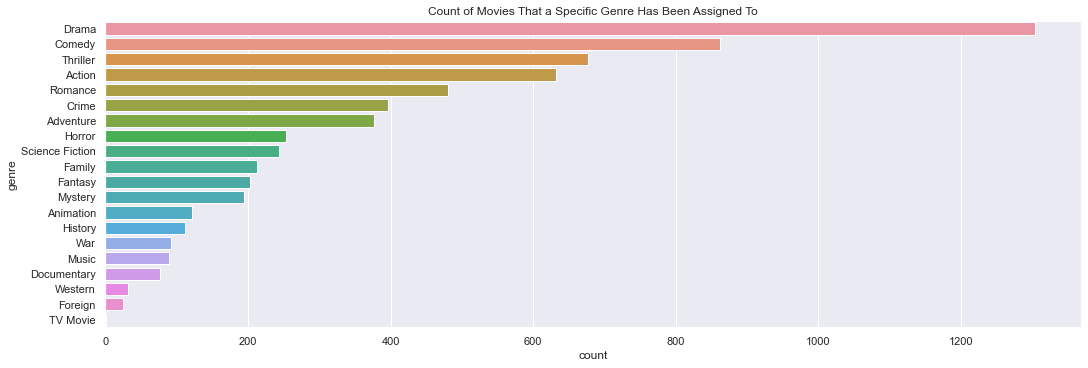

In [44]:
genres_counts = Counter([j for i in train['all_genres'] for j in i]).most_common()

plt.figure(figsize=(15,5), constrained_layout=True)
sns.barplot([i[1] for i in genres_counts], [i[0] for i in genres_counts])
plt.title('Count of Movies That a Specific Genre Has Been Assigned To')
plt.xlabel('count')
plt.ylabel('genre');

In [45]:
# create a column for all genres except 'TV Movie' since too few movies in the training set have it, making it useless
# to prevent data leakage, the choice of genres (genres_counts[:-1]) to create columns for is based on the training
# set only
for d in datasets:
    for i in genres_counts[:-1]:
        d['genre_' + i[0]] = d['all_genres'].apply(lambda x: 1 if i[0] in x else 0)

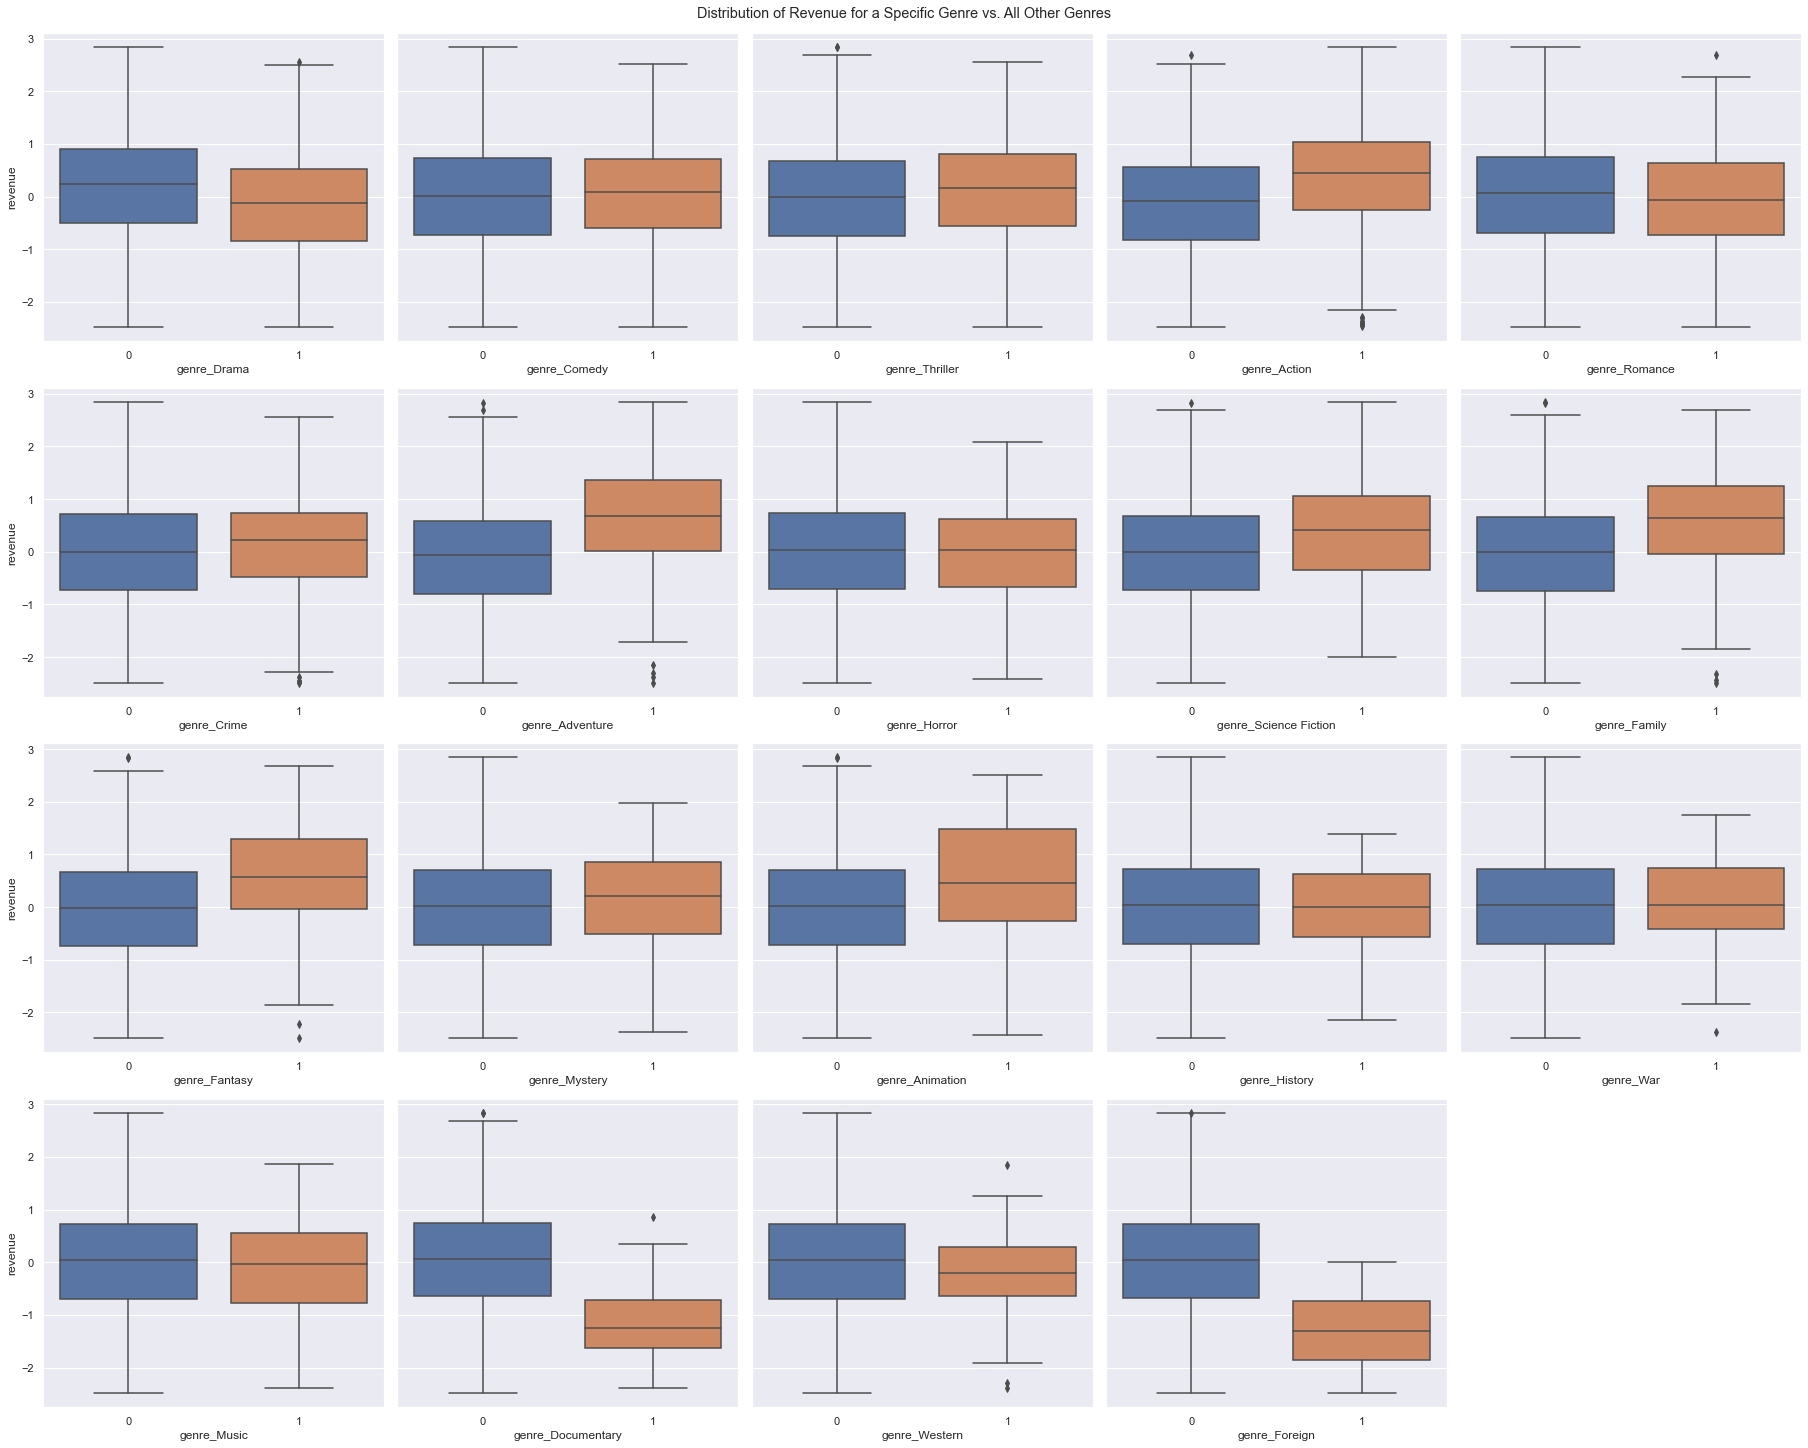

In [46]:
fig, axes = plt.subplots(4, 5, figsize=(25,20), constrained_layout=True, sharey='all')
plt.suptitle('Distribution of Revenue for a Specific Genre vs. All Other Genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i//5,i%5])
fig.delaxes(axes[3,4])
# hide y labels for all columns of plots, except the first column
for i in np.arange(0,4):
    for j in np.arange(1,5):
        axes[i,j].yaxis.label.set_visible(False)
pass;

### homepage

In [47]:
for d in datasets:
    print('Number of missing values in the homepage column of the {} set:'.format(d.name), d['homepage'].isna().sum())

Number of missing values in the homepage column of the train set: 1747
Number of missing values in the homepage column of the test set: 307
Number of missing values in the homepage column of the predict set: 2978


In [48]:
train.homepage.head()

422      http://www.blackdynamitemovie.com
838     http://www.hollywoodlandmovie.com/
1735          http://www.jurassicpark.com/
746                                    NaN
900                                    NaN
Name: homepage, dtype: object

In [49]:
train.homepage.value_counts().head()

http://www.transformersmovie.com/              3
http://www.thehobbit.com/                      2
http://www.polisse-lefilm.com/                 1
http://www.magpictures.com/drinkingbuddies     1
http://disney.go.com/disneypictures/wall-e/    1
Name: homepage, dtype: int64

In [50]:
for d in datasets:
    d['has_homepage'] = d['homepage'].apply(lambda x: 1 if pd.notna(x) else 0)

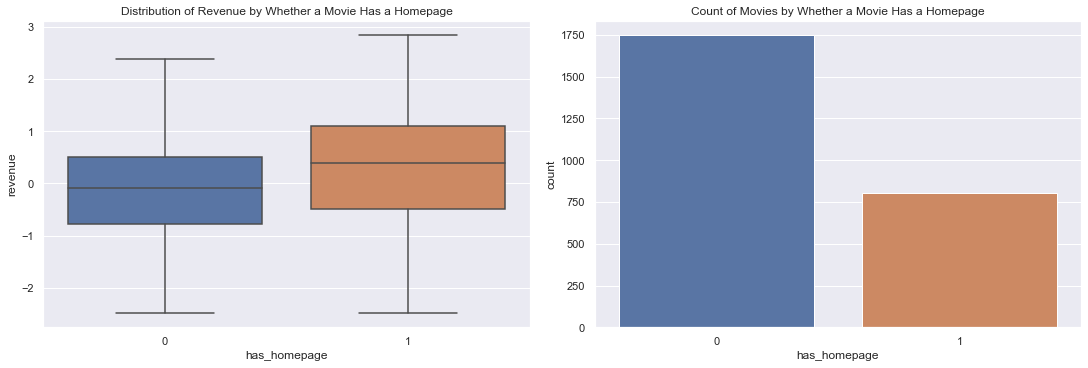

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot(train.has_homepage, train.revenue, ax=axes[0])
axes[0].set_title('Distribution of Revenue by Whether a Movie Has a Homepage')
sns.countplot(train.has_homepage, ax=axes[1])
axes[1].set_title('Count of Movies by Whether a Movie Has a Homepage');

Of all the individual homepages in the train set, only two belong to more than one movie. The only useful piece of information we can extract from the homepage column is whether or not a movie has a homepage (has_homepage column). After that, we can drop the homepage column.

### original_language

In [52]:
for d in datasets:
    print('Number of missing values in the original_language column of the {} set:'\
          .format(d.name), len(d[d['original_language']=={}]))

Number of missing values in the original_language column of the train set: 0
Number of missing values in the original_language column of the test set: 0
Number of missing values in the original_language column of the predict set: 0


In [53]:
train.original_language.head()

422     en
838     en
1735    en
746     en
900     en
Name: original_language, dtype: object

In [54]:
original_language_counts = Counter(train['original_language']).most_common()
len(original_language_counts)

35

In [55]:
original_language_counts = [i for i in original_language_counts if i[1]>=15]
len(original_language_counts)

11

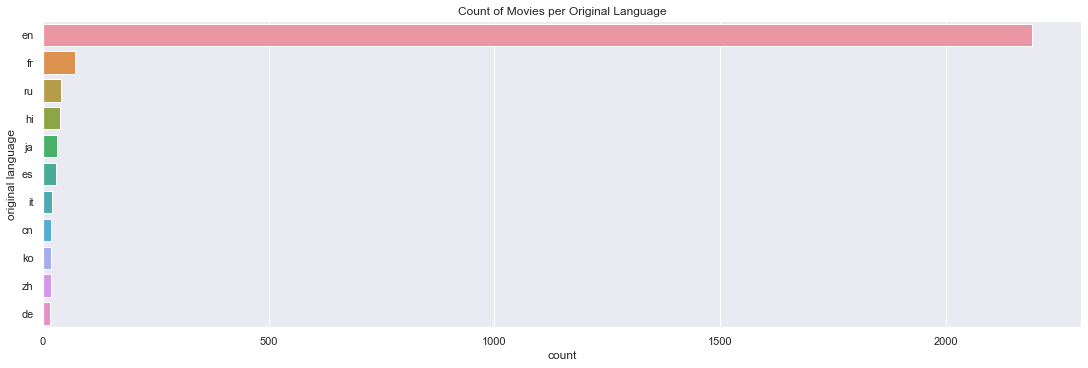

In [56]:
plt.figure(figsize=(15,5), constrained_layout=True)
sns.barplot([i[1] for i in original_language_counts], [i[0] for i in original_language_counts])
plt.title('Count of Movies per Original Language')
plt.xlabel('count')
plt.ylabel('original language');

In [57]:
# create a column for all original languages with at least 15 movies in the training set; those that have fewer
# films do not have a lot to teach our model
# to prevent data leakage, the choice of original languages (original_language_counts) to create columns for is
# based on the training set only
for d in datasets:
    for i in original_language_counts:
        d['original_language_' + i[0]] = d['original_language'].apply(lambda x: 1 if i[0] in x else 0)

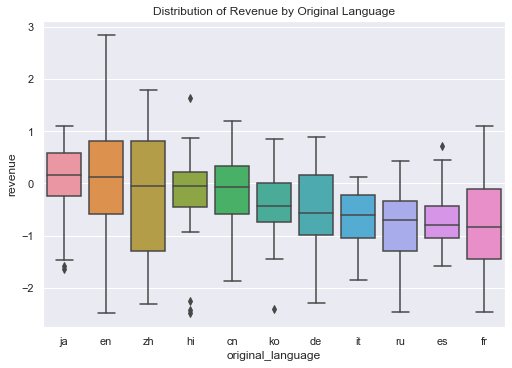

In [58]:
index = train[train.original_language.isin([i[0] for i in original_language_counts])].groupby('original_language')\
    ['revenue'].median().sort_values(ascending=False).index

plt.figure(figsize=(7,5), constrained_layout=True)
sns.boxplot('original_language', 'revenue', data=train[train.original_language\
                                                       .isin([i[0] for i in original_language_counts])], order=index)
plt.title('Distribution of Revenue by Original Language');

### production_companies

In [59]:
for d in datasets:
    print('Number of missing values in the production_companies column of the {} set:'.format(d.name), len(d[d['production_companies']=={}]))

Number of missing values in the production_companies column of the train set: 131
Number of missing values in the production_companies column of the test set: 25
Number of missing values in the production_companies column of the predict set: 258


In [60]:
for i, e in train.production_companies[0:5].iteritems():
    print(i, e)

422 [{'name': 'Destination Films', 'id': 769}, {'name': 'Six Point Harness', 'id': 5615}, {'name': 'Ars Nova', 'id': 67539}, {'name': 'Goliath Entertainment', 'id': 67540}]
838 [{'name': 'Focus Features', 'id': 10146}]
1735 [{'name': 'Universal Pictures', 'id': 33}, {'name': 'Amblin Entertainment', 'id': 56}]
746 {}
900 [{'name': 'Summit Entertainment', 'id': 491}, {'name': 'Intrepid Pictures', 'id': 1224}, {'name': 'Film Rites', 'id': 8083}, {'name': 'Galavis Film', 'id': 8084}, {'name': 'Picture Machine', 'id': 8085}, {'name': 'Fria Luz Del Dia, A.I.E.', 'id': 23625}]


In [61]:
for d in datasets:
    d['all_production_companies'] = d['production_companies'].\
        apply(lambda x: sorted([i['name'] for i in x]) if len(x)!=0 else {})
    d['production_companies_missing'] = d['production_companies'].apply(lambda x: 1 if len(x)==0 else 0)
    d['num_production_companies'] = d['production_companies'].apply(lambda x: len(x) if len(x)!=0 else np.nan)    # NaNs will be imputed later in the project

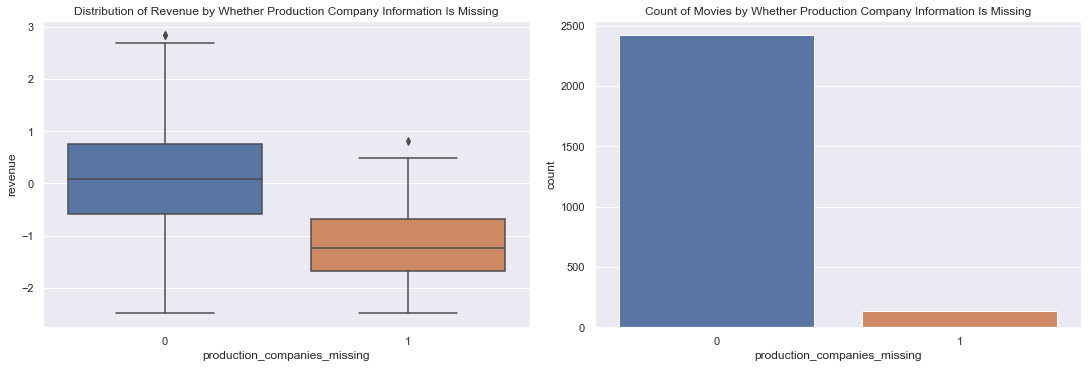

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot(train.production_companies_missing, train.revenue, ax=axes[0])
axes[0].set_title('Distribution of Revenue by Whether Production Company Information Is Missing')
sns.countplot(train.production_companies_missing, ax=axes[1])
axes[1].set_title('Count of Movies by Whether Production Company Information Is Missing');

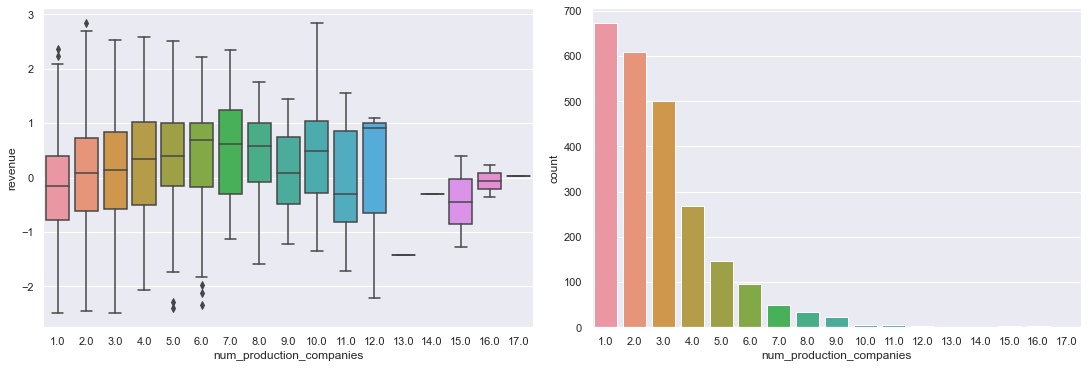

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot('num_production_companies', 'revenue', data=train, ax=axes[0])
sns.countplot(train.num_production_companies, ax=axes[1]);

In [64]:
print('Correlation between revenue and num_production_companies:', train[['revenue', 'num_production_companies']].corr().loc['revenue', 'num_production_companies'])

Correlation between revenue and num_production_companies: 0.1536291143220398


In [65]:
for d in datasets:
    d.loc[d.num_production_companies>=6, 'num_production_companies'] = 6

In [66]:
print('Correlation between revenue and num_production_companies:', train[['revenue', 'num_production_companies']].corr().loc['revenue', 'num_production_companies'])

Correlation between revenue and num_production_companies: 0.18625920401011756


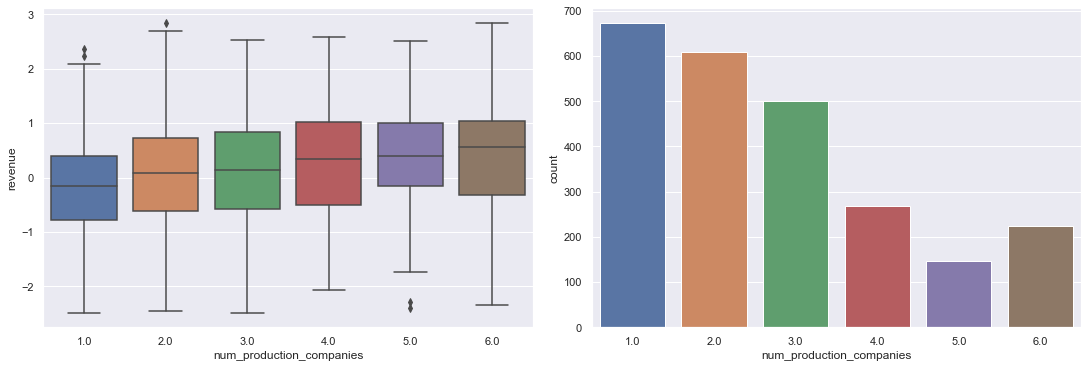

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot('num_production_companies', 'revenue', data=train, ax=axes[0])
sns.countplot(train.num_production_companies, ax=axes[1]);

In [68]:
production_companies_counts = Counter([j for i in train['all_production_companies'] for j in i]).most_common()
len(production_companies_counts)

3302

In [69]:
production_companies_counts = [i for i in production_companies_counts if i[1]>=15]
len(production_companies_counts)

39

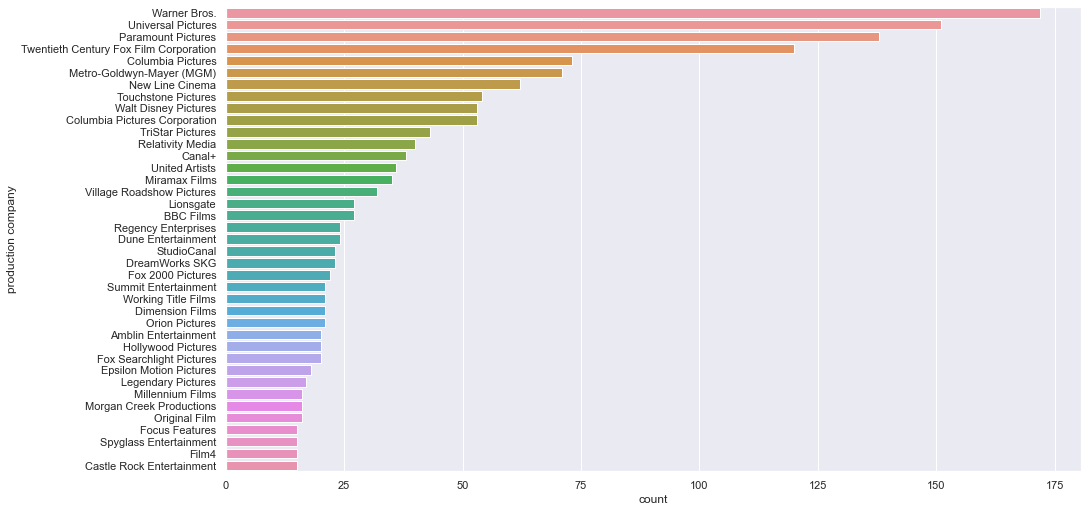

In [70]:
plt.figure(figsize=(15,7), constrained_layout=True)
sns.barplot([i[1] for i in production_companies_counts], [i[0] for i in production_companies_counts])
plt.xlabel('count')
plt.ylabel('production company');

In [71]:
# create a column for all production companies with at least 15 movies in the training set; those that have fewer
# films do not have a lot to teach our model
# to prevent data leakage, the choice of production companies (production_companies_counts) to create columns for is
# based on the training set only
for d in datasets:
    for i in production_companies_counts:
        d['production_company_' + i[0]] = d['all_production_companies'].apply(lambda x: 1 if i[0] in x else 0)

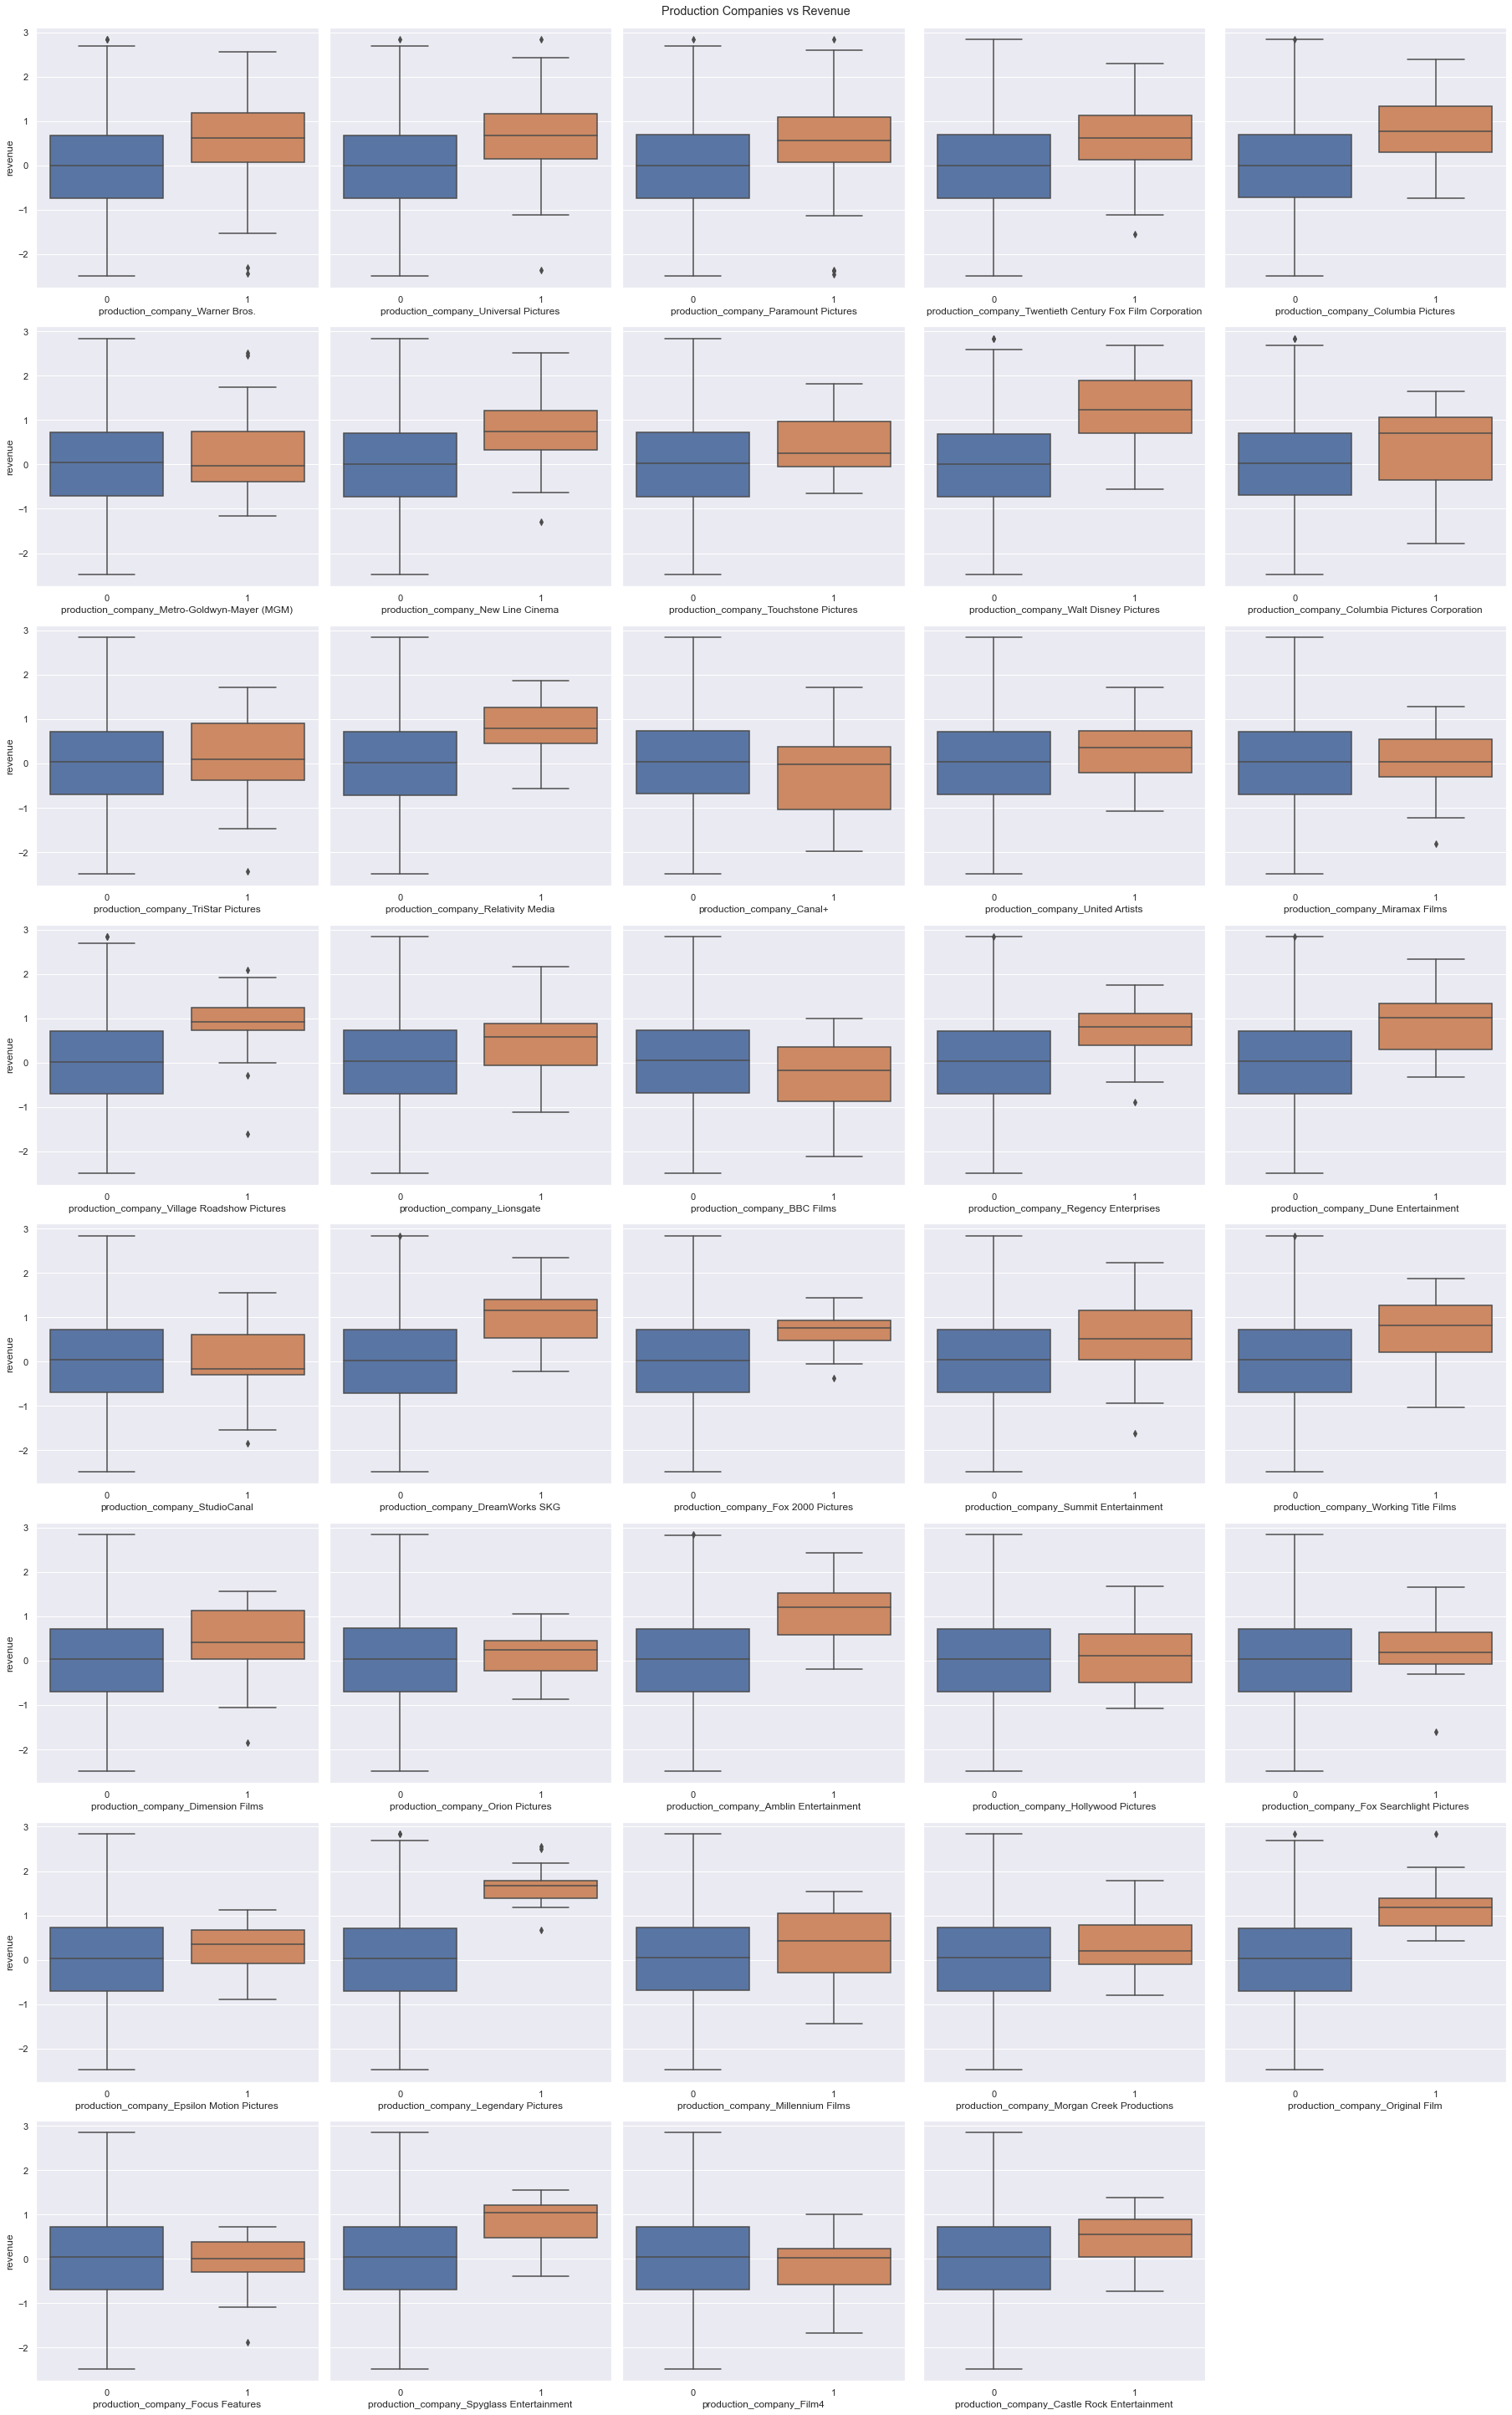

In [72]:
fig, axes = plt.subplots(8, 5, figsize=(25,40), constrained_layout=True, sharey='all')
plt.suptitle('Production Companies vs Revenue')
for i, e in enumerate([col for col in train.columns if 'production_company_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i//5,i%5])
fig.delaxes(axes[7,4])
# hide y labels for all columns of plots, except the first column
for i in np.arange(0,8):
    for j in np.arange(1,5):
        axes[i,j].yaxis.label.set_visible(False)
pass;

### production_countries

In [73]:
for d in datasets:
    print('Number of missing values in the production_countries column of the {} set:'\
          .format(d.name), len(d[d['production_countries']=={}]))

Number of missing values in the production_countries column of the train set: 47
Number of missing values in the production_countries column of the test set: 8
Number of missing values in the production_countries column of the predict set: 102


In [74]:
for i, e in train.production_countries[0:5].iteritems():
    print(i, e)

422 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
838 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1735 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
746 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
900 [{'iso_3166_1': 'US', 'name': 'United States of America'}]


In [75]:
for d in datasets:
    d['all_production_countries'] = d['production_countries'].apply(lambda x: sorted([i['name'] for i in x]) if len(x)!=0 else {})
    d['production_countries_missing'] = d['production_countries'].apply(lambda x: 1 if len(x)==0 else 0)
    d['num_production_countries'] = d['production_countries'].apply(lambda x: len(x) if len(x)!=0 else np.nan)    # NaNs will be imputed later in the project

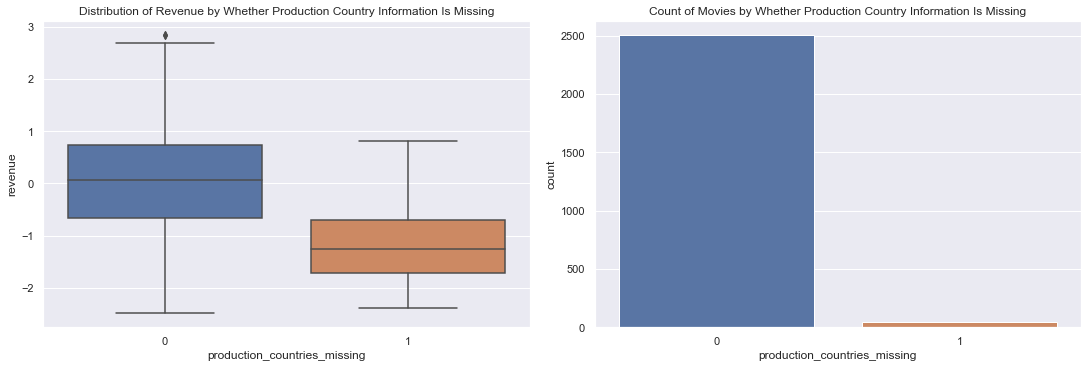

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot(train.production_countries_missing, train.revenue, ax=axes[0])
axes[0].set_title('Distribution of Revenue by Whether Production Country Information Is Missing')
sns.countplot(train.production_countries_missing, ax=axes[1])
axes[1].set_title('Count of Movies by Whether Production Country Information Is Missing');

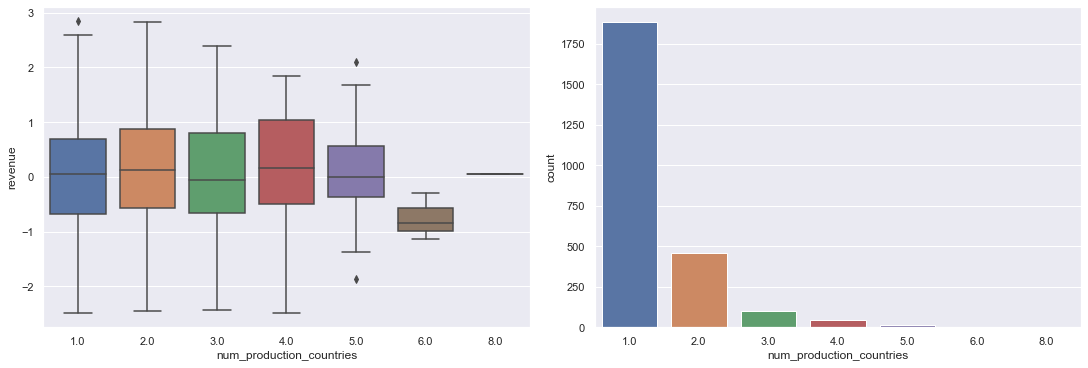

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot('num_production_countries', 'revenue', data=train, ax=axes[0])
sns.countplot(train.num_production_countries, ax=axes[1]);

In [78]:
production_countries_counts = Counter([j for i in train['all_production_countries'] for j in i]).most_common()
len(production_countries_counts)

72

In [79]:
production_countries_counts = [i for i in production_countries_counts if i[1]>=15]
len(production_countries_counts)

17

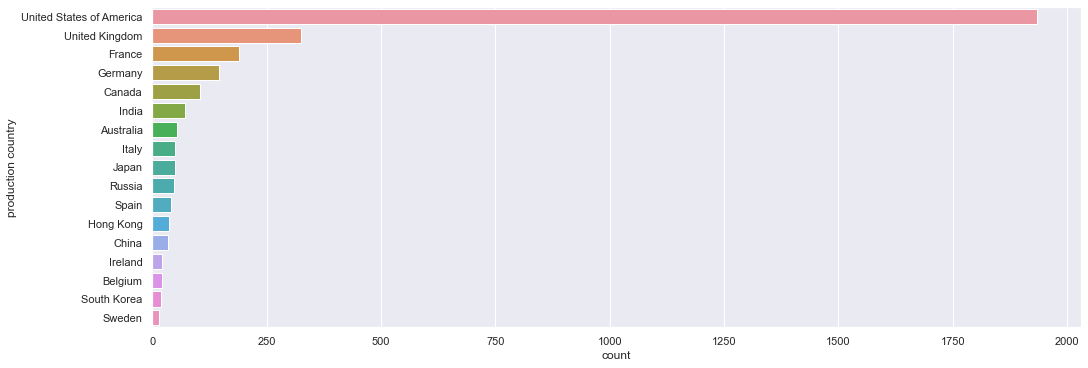

In [80]:
plt.figure(figsize=(15,5), constrained_layout=True)
sns.barplot([i[1] for i in production_countries_counts], [i[0] for i in production_countries_counts])
plt.xlabel('count')
plt.ylabel('production country');

In [81]:
# create a column for all production countries with at least 15 movies in the training set; those that have fewer
# films do not have a lot to teach our model
# to prevent data leakage, the choice of production countries (production_countries_counts) to create columns for is
# based on the training set only
for d in datasets:
    for i in production_countries_counts:
        d['production_country_' + i[0]] = d['all_production_countries'].apply(lambda x: 1 if i[0] in x else 0)

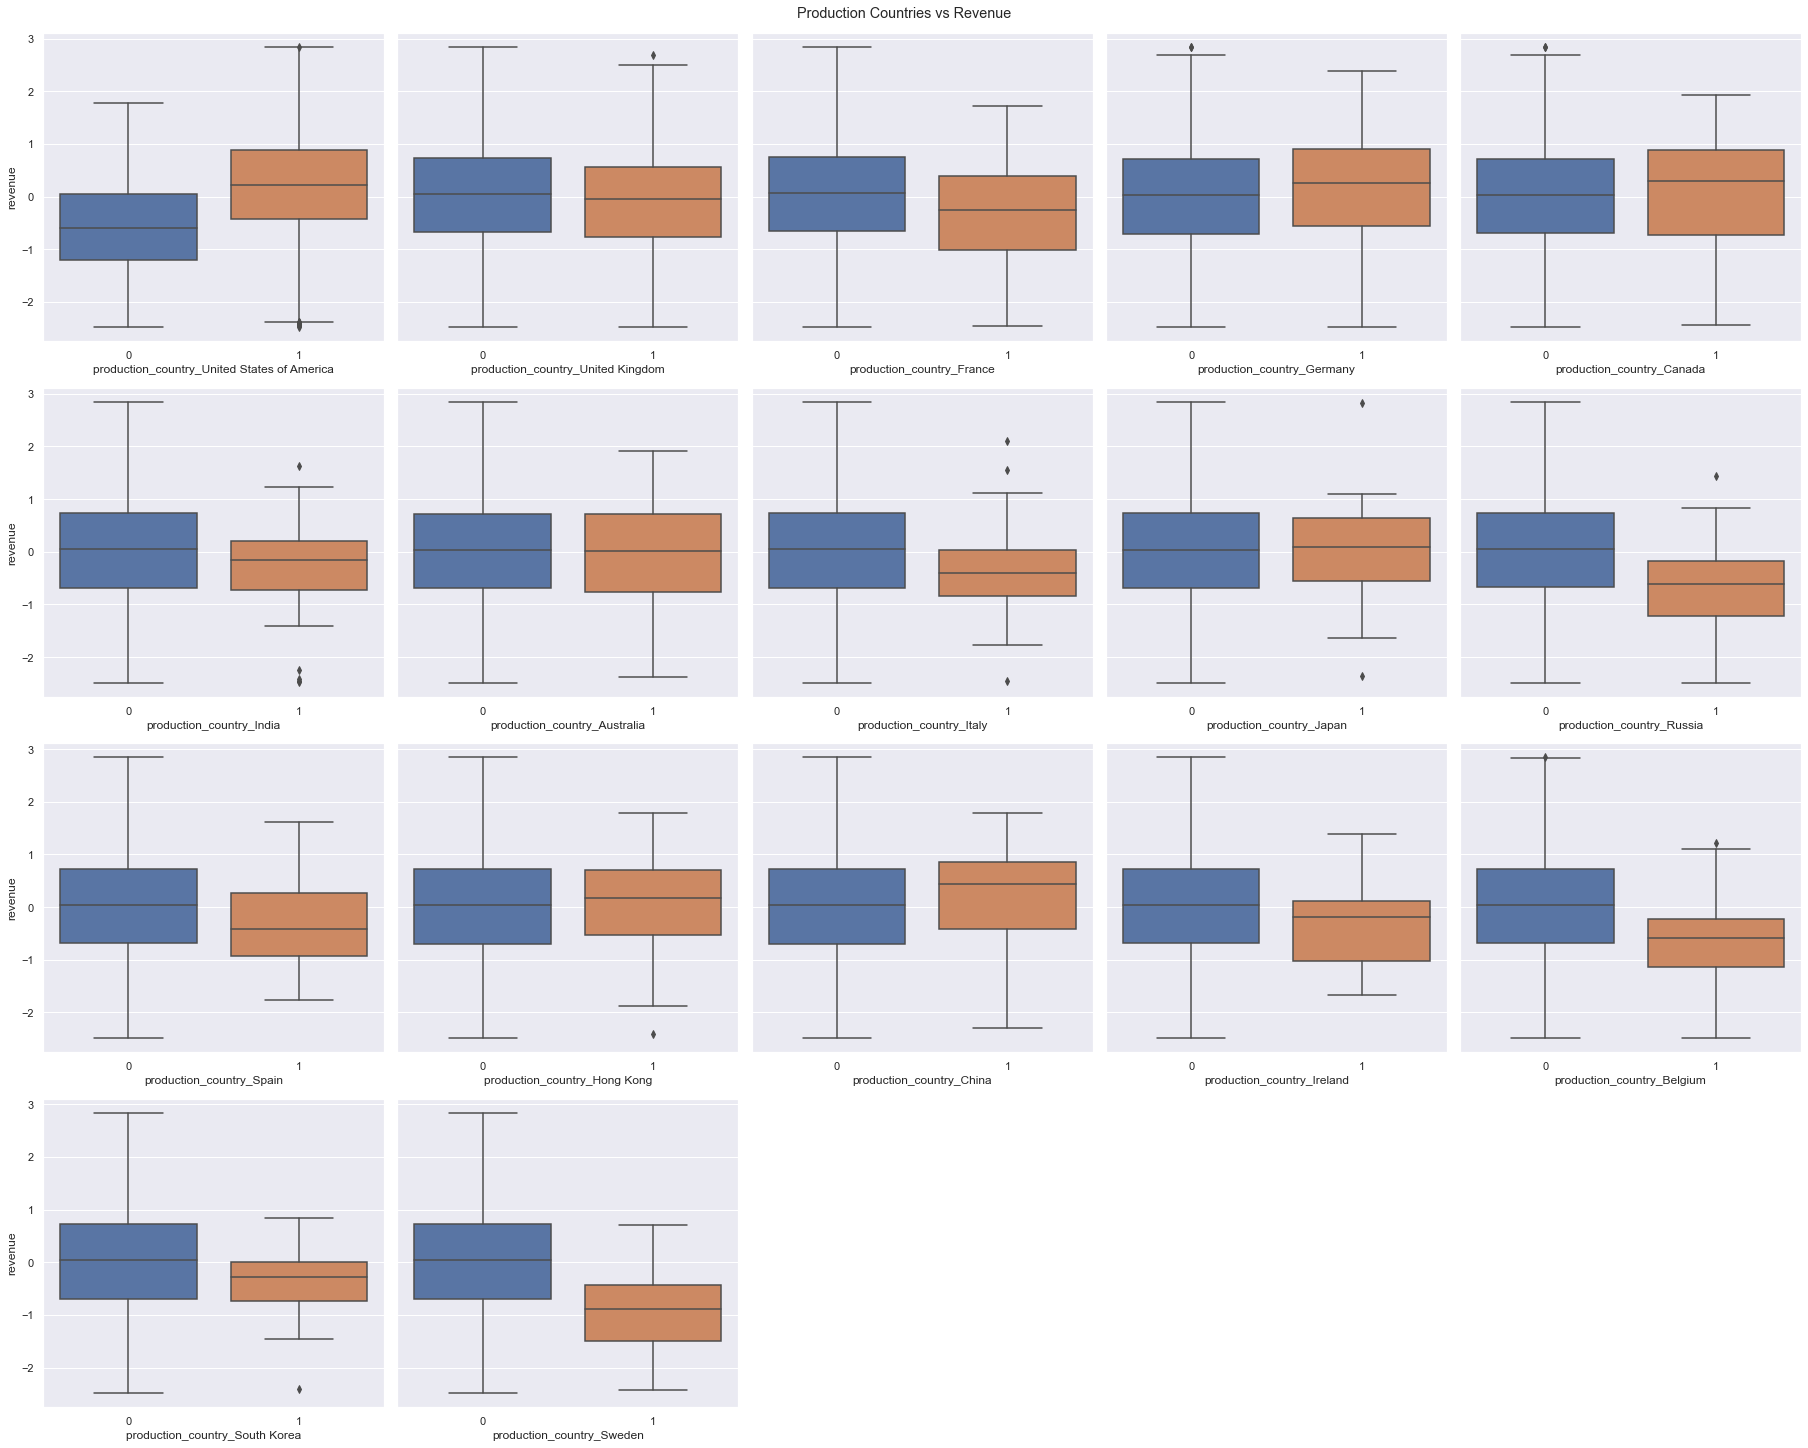

In [82]:
fig, axes = plt.subplots(4, 5, figsize=(25,20), constrained_layout=True, sharey='all')
plt.suptitle('Production Countries vs Revenue')
for i, e in enumerate([col for col in train.columns if 'production_country_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i//5,i%5])
for i in np.arange(2,5):
    fig.delaxes(axes[3,i])
# hide y labels for all columns of plots, except the first column
for i in np.arange(0,4):
    for j in np.arange(1,5):
        axes[i,j].yaxis.label.set_visible(False)
pass;

### release_date

In [83]:
for d in datasets:
    print('Number of missing values in the release_date column of the {} set:'.format(d.name), d['release_date'].isna().sum())

Number of missing values in the release_date column of the train set: 0
Number of missing values in the release_date column of the test set: 0
Number of missing values in the release_date column of the predict set: 1


In [84]:
train.release_date.head()

422     10/16/09
838      8/31/06
1735     6/11/93
746      2/22/07
900       4/4/12
Name: release_date, dtype: object

In [85]:
train.release_date.dtype

dtype('O')

In [86]:
for d in datasets:
    d['release_date'] = d['release_date'].astype('datetime64')

In [87]:
train.release_date.head()

422    2009-10-16
838    2006-08-31
1735   1993-06-11
746    2007-02-22
900    2012-04-04
Name: release_date, dtype: datetime64[ns]

In [88]:
for d in datasets:
    d['year'] = d['release_date'].dt.year
    # incorrectly assumes 21st century for a number of years that have not happened yet; correct this
    d['year'] = d['year'].apply(lambda x: x-100 if x>2018 else x)
    d['quarter'] = d['release_date'].dt.quarter
    d['month'] = d['release_date'].dt.month
    d['week'] = d['release_date'].dt.week
    d['dayofweek'] = d['release_date'].dt.dayofweek

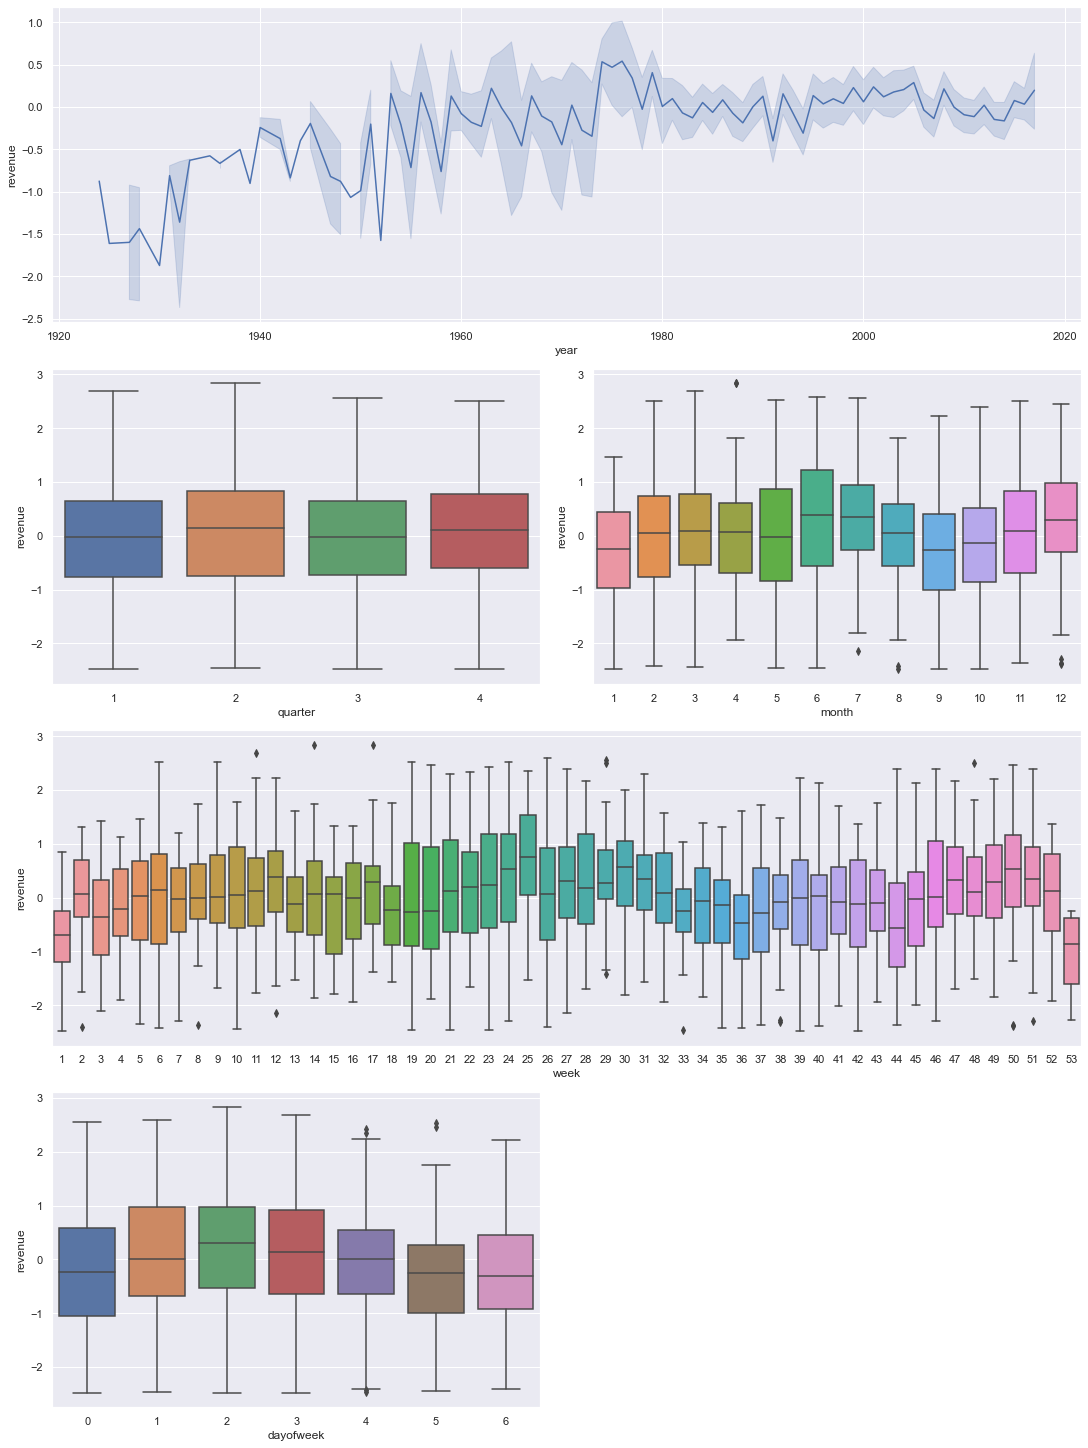

In [89]:
fig = plt.figure(figsize=(15,20), constrained_layout=True)
gs = fig.add_gridspec(4,2)
ax1 = fig.add_subplot(gs[0,:])
sns.lineplot('year', 'revenue', data=train)
ax1 = fig.add_subplot(gs[1,0])
sns.boxplot('quarter', 'revenue', data=train)
ax1 = fig.add_subplot(gs[1,1])
sns.boxplot('month', 'revenue', data=train)
ax1 = fig.add_subplot(gs[2,:])
sns.boxplot('week', 'revenue', data=train)
ax1 = fig.add_subplot(gs[3,0])
sns.boxplot('dayofweek', 'revenue', data=train);

In [90]:
train.to_csv('train_new.csv', index=False)
test.to_csv('test_new.csv', index=False)
predict.to_csv('predict_new.csv', index=False)

In [91]:
train = pd.read_csv('train_new.csv')
test = pd.read_csv('test_new.csv')
predict = pd.read_csv('predict_new.csv')

datasets = [train, test, predict]
train.name='train'
test.name='test'
predict.name='predict'

In [92]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

for d in datasets:
    d = text_to_dict(d)

### spoken_languages

In [93]:
for d in datasets:
    print('Number of missing values in the spoken_languages column of the {} set:'\
          .format(d.name), len(d[d['spoken_languages']=={}]))

Number of missing values in the spoken_languages column of the train set: 14
Number of missing values in the spoken_languages column of the test set: 6
Number of missing values in the spoken_languages column of the predict set: 42


In [94]:
for i, e in train.spoken_languages[:5].iteritems():
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'it', 'name': 'Italiano'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'es', 'name': 'Español'}]
3 [{'iso_639_1': 'en', 'name': 'English'}]
4 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'es', 'name': 'Español'}]


In [95]:
for d in datasets:
    d['all_spoken_languages'] = d['spoken_languages'].apply(lambda x: sorted([i['iso_639_1'] for i in x]) if len(x)!=0 else {})
    d['spoken_languages_missing'] = d['spoken_languages'].apply(lambda x: 1 if len(x)==0 else 0)
    d['num_spoken_languages'] = d['spoken_languages'].apply(lambda x: len(x) if len(x)!=0 else np.nan)    # NaNs will be imputed later in the project

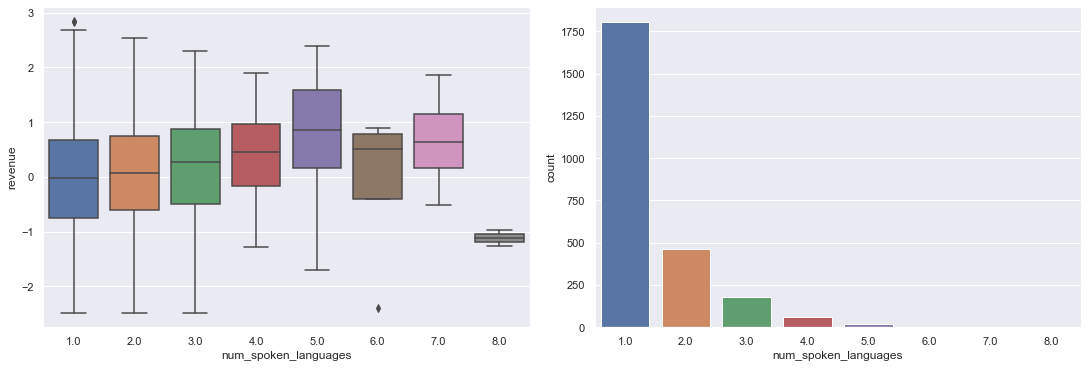

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot('num_spoken_languages', 'revenue', data=train, ax=axes[0])
sns.countplot(train.num_spoken_languages, ax=axes[1]);

In [97]:
train[['revenue', 'num_spoken_languages']].corr().loc['revenue', 'num_spoken_languages']

0.10120676098435359

In [98]:
for d in datasets:
    d.loc[d.num_spoken_languages>=5, 'num_spoken_languages'] = 5

In [99]:
train[['revenue', 'num_spoken_languages']].corr().loc['revenue', 'num_spoken_languages']

0.10700034234766562

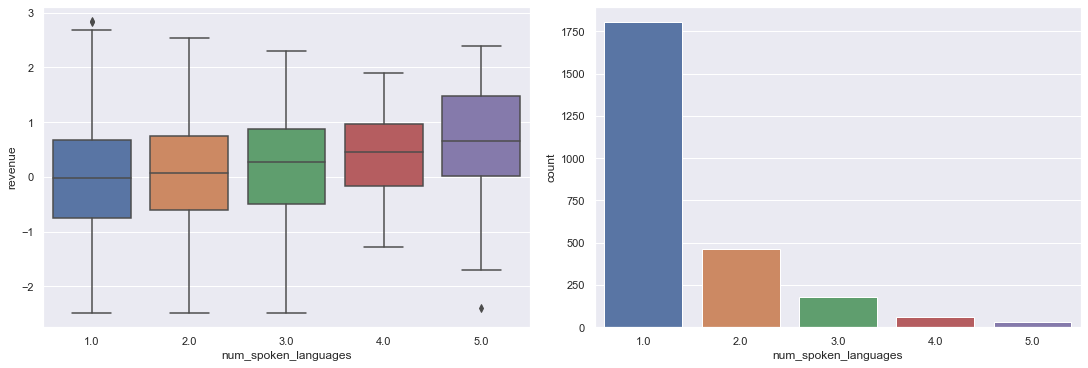

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot('num_spoken_languages', 'revenue', data=train, ax=axes[0])
sns.countplot(train.num_spoken_languages, ax=axes[1]);

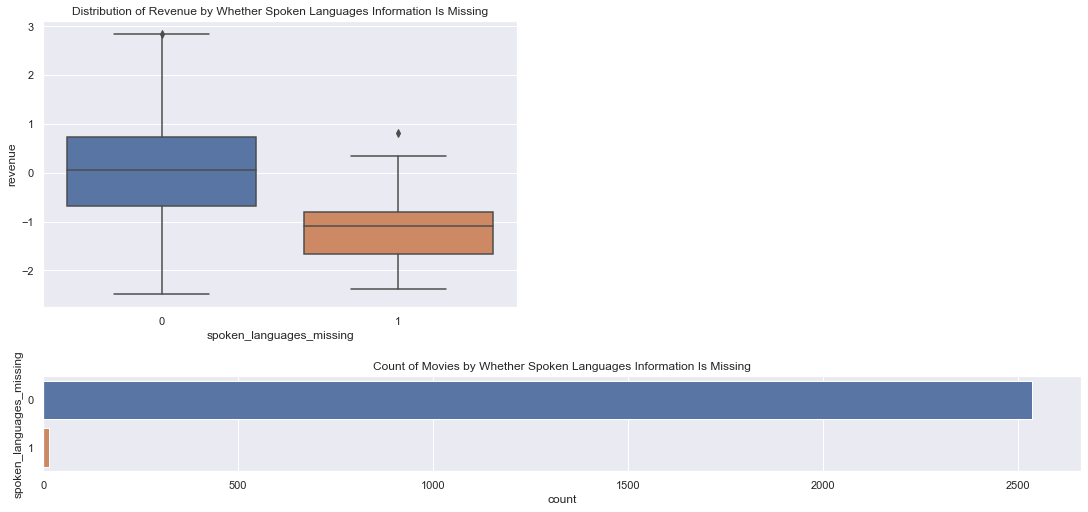

In [101]:
fig = plt.figure(figsize=(15,7), constrained_layout=True)
gs = fig.add_gridspec(4,6)
ax1 = fig.add_subplot(gs[0:3,0:2])
sns.boxplot(train.spoken_languages_missing, train.revenue)
ax1.set_title('Distribution of Revenue by Whether Spoken Languages Information Is Missing')
ax2 = fig.add_subplot(gs[3,:])
sns.countplot(y=train.spoken_languages_missing)
ax2.set_title('Count of Movies by Whether Spoken Languages Information Is Missing');

In [102]:
spoken_languages_counts = Counter([j for i in train['all_spoken_languages'] for j in i]).most_common()
len(spoken_languages_counts)

70

In [103]:
spoken_languages_counts = [i for i in spoken_languages_counts if i[1]>=15]
len(spoken_languages_counts)

20

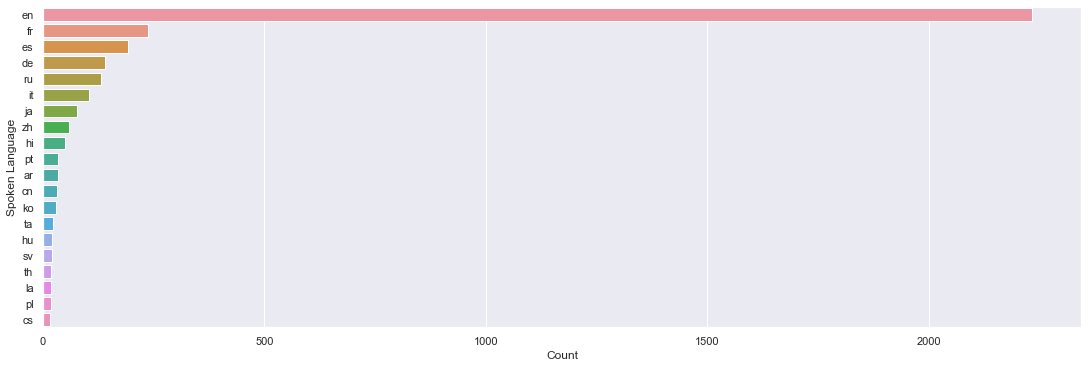

In [104]:
plt.figure(figsize=(15,5), constrained_layout=True)
sns.barplot([i[1] for i in spoken_languages_counts], [i[0] for i in spoken_languages_counts])
plt.xlabel('Count')
plt.ylabel('Spoken Language');

In [105]:
# create a column for all spoken languages with at least 15 movies in the training set; those that have fewer
# films do not have a lot to teach our model
# to prevent data leakage, the choice of spoken languages (spoken_languages_counts) to create columns for is
# based on the training set only
for d in datasets:
    for i in spoken_languages_counts:
        d['spoken_language_' + i[0]] = d['all_spoken_languages'].apply(lambda x: 1 if i[0] in x else 0)

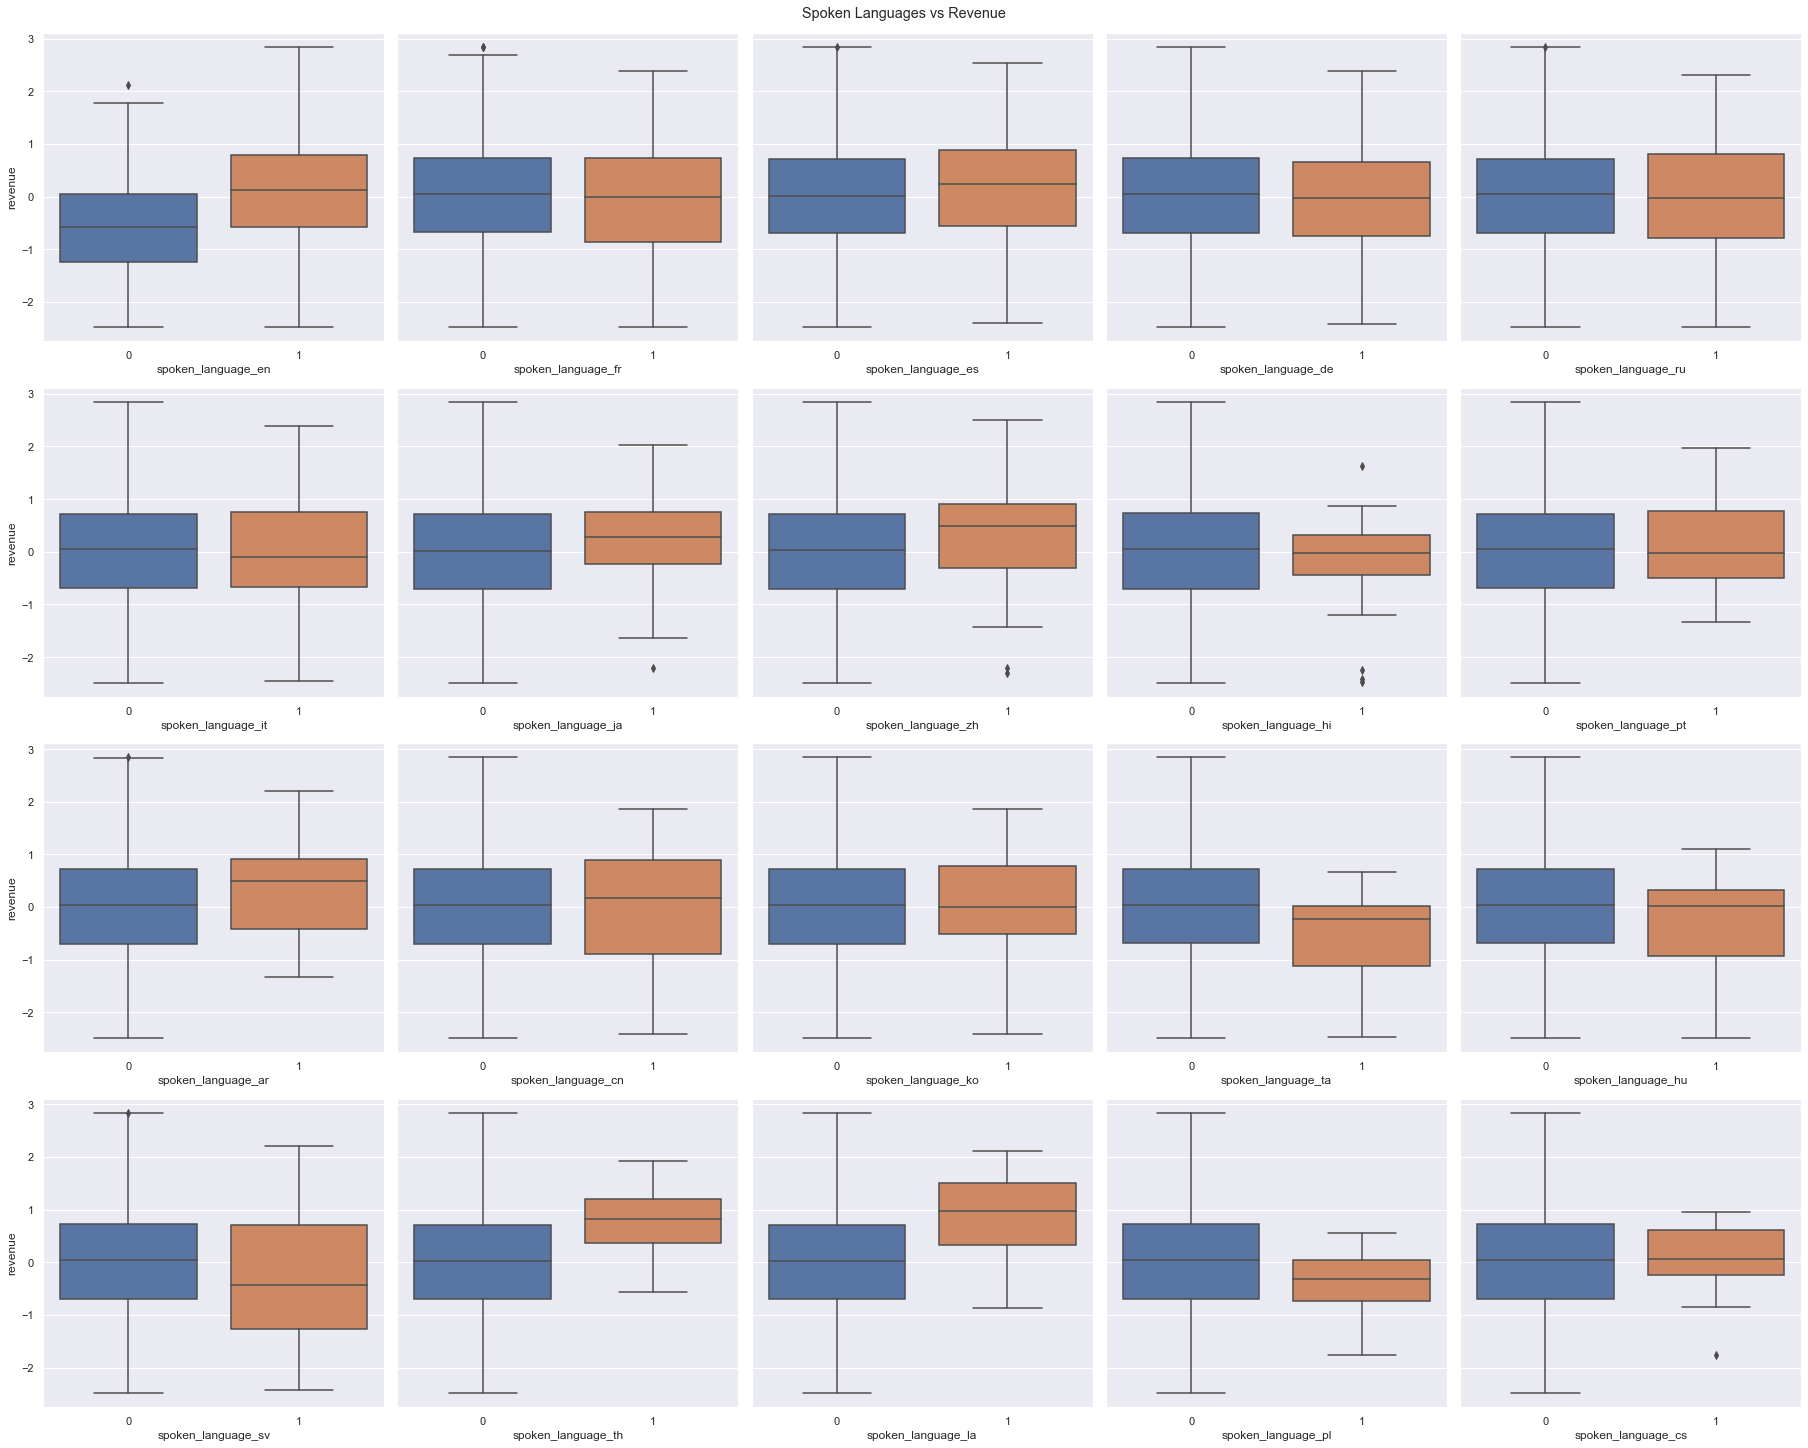

In [106]:
fig, axes = plt.subplots(4, 5, figsize=(25,20), constrained_layout=True, sharey='all')
plt.suptitle('Spoken Languages vs Revenue')
for i, e in enumerate([col for col in train.columns if 'spoken_language_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i//5,i%5])
# hide y labels for all columns of plots, except the first column
for i in np.arange(0,4):
    for j in np.arange(1,5):
        axes[i,j].yaxis.label.set_visible(False)
pass;

### Keywords

In [107]:
for d in datasets:
    print('Number of missing values in the Keywords column of the {} set:'.format(d.name), len(d[d['Keywords']=={}]))

Number of missing values in the Keywords column of the train set: 237
Number of missing values in the Keywords column of the test set: 39
Number of missing values in the Keywords column of the predict set: 393


In [108]:
for i, e in train.Keywords[:5].iteritems():
    print(i, e)

0 [{'id': 577, 'name': 'black people'}, {'id': 10601, 'name': 'blaxploitation'}, {'id': 11931, 'name': 'spoof'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 703, 'name': 'detective'}, {'id': 931, 'name': 'jealousy'}, {'id': 3737, 'name': 'dying and death'}, {'id': 4481, 'name': 'deceived wife'}, {'id': 4663, 'name': 'lovers'}, {'id': 5340, 'name': 'investigation'}, {'id': 5446, 'name': 'observer'}, {'id': 163455, 'name': 'super powers'}]
2 [{'id': 911, 'name': 'exotic island'}, {'id': 1718, 'name': 'dna'}, {'id': 1719, 'name': 'paleontology'}, {'id': 1720, 'name': 'tyrannosaurus rex'}, {'id': 1764, 'name': 'triceratops'}, {'id': 1765, 'name': 'brontosaurus'}, {'id': 1767, 'name': 'electric fence'}, {'id': 2041, 'name': 'island'}, {'id': 12616, 'name': 'dinosaur'}, {'id': 155582, 'name': 'amusement park'}, {'id': 158340, 'name': 'theme park'}, {'id': 178010, 'name': 'jurassic park'}]
3 [{'id': 210012, 'name': 'mumblegore'}]
4 [{'id': 1930, 'name': 'kidnapping'}, {'id': 526

In [109]:
for d in datasets:
    d['all_Keywords'] = d['Keywords'].apply(lambda x: sorted([i['name'] for i in x]) if len(x)!=0 else {})
    d['Keywords_missing'] = d['Keywords'].apply(lambda x: 1 if len(x)==0 else 0)
    d['num_Keywords'] = d['Keywords'].apply(lambda x: len(x) if len(x)!=0 else np.nan)    # NaNs will be imputed later in the project

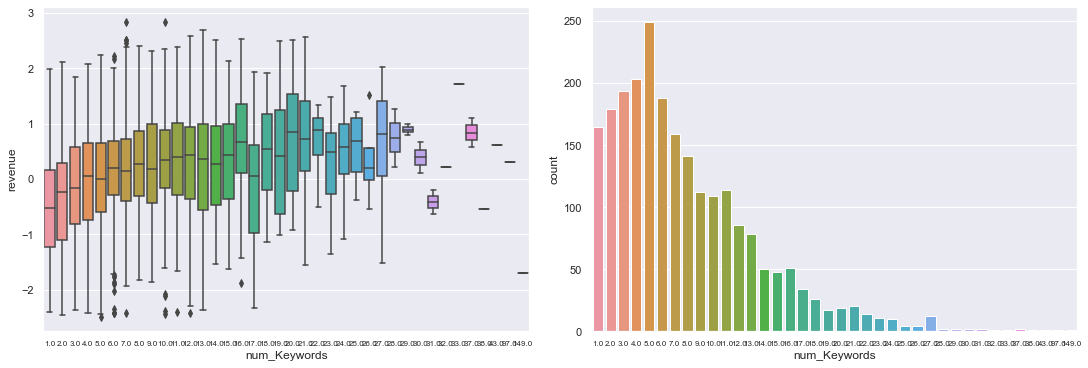

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot('num_Keywords', 'revenue', data=train, ax=axes[0])
sns.countplot(train.num_Keywords, ax=axes[1])
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=8)
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=8);

In [111]:
train[['revenue', 'num_Keywords']].corr().loc['revenue', 'num_Keywords']

0.1860035923006093

In [112]:
for d in datasets:
    d.loc[d.num_Keywords>=16, 'num_Keywords'] = 16

In [113]:
train[['revenue', 'num_Keywords']].corr().loc['revenue', 'num_Keywords']

0.24848737467805299

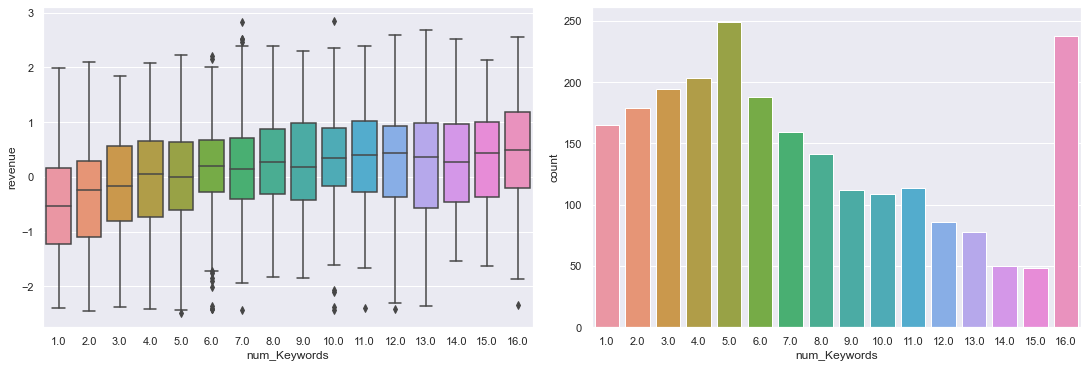

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot('num_Keywords', 'revenue', data=train, ax=axes[0])
sns.countplot(train.num_Keywords, ax=axes[1]);

In [115]:
Keywords_counts = Counter([j for i in train['all_Keywords'] for j in i]).most_common()
len(Keywords_counts)

6768

In [116]:
Keywords_counts = [i for i in Keywords_counts if i[1]>=30]
len(Keywords_counts)

42

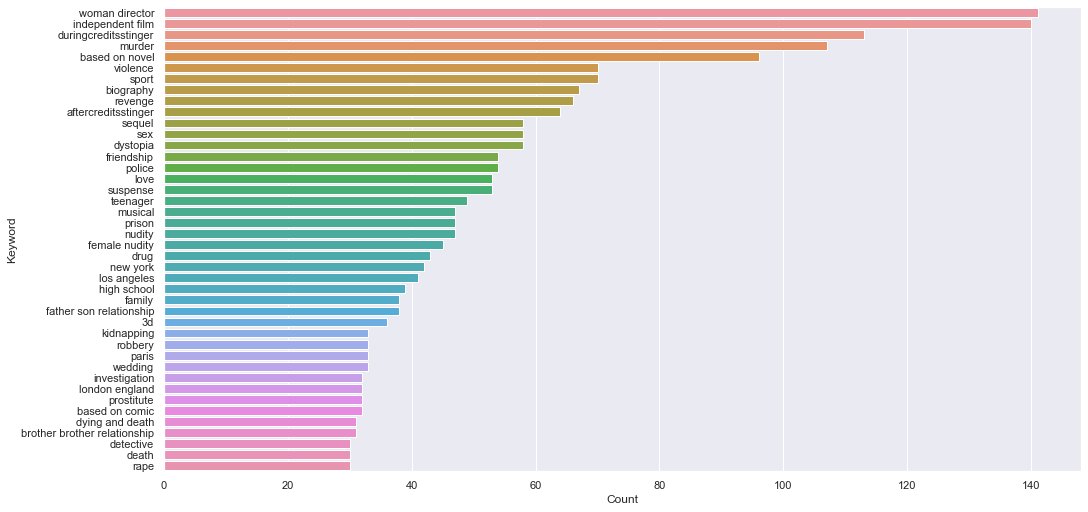

In [117]:
plt.figure(figsize=(15,7), constrained_layout=True)
sns.barplot([i[1] for i in Keywords_counts], [i[0] for i in Keywords_counts])
plt.xlabel('Count')
plt.ylabel('Keyword');

In [118]:
# create a column for all spoken languages with at least 15 movies in the training set; those that have fewer
# films do not have a lot to teach our model
# to prevent data leakage, the choice of spoken languages (spoken_languages_counts) to create columns for is
# based on the training set only
for d in datasets:
    for i in Keywords_counts:
        d['Keyword_' + i[0]] = d['all_Keywords'].apply(lambda x: 1 if i[0] in x else 0)

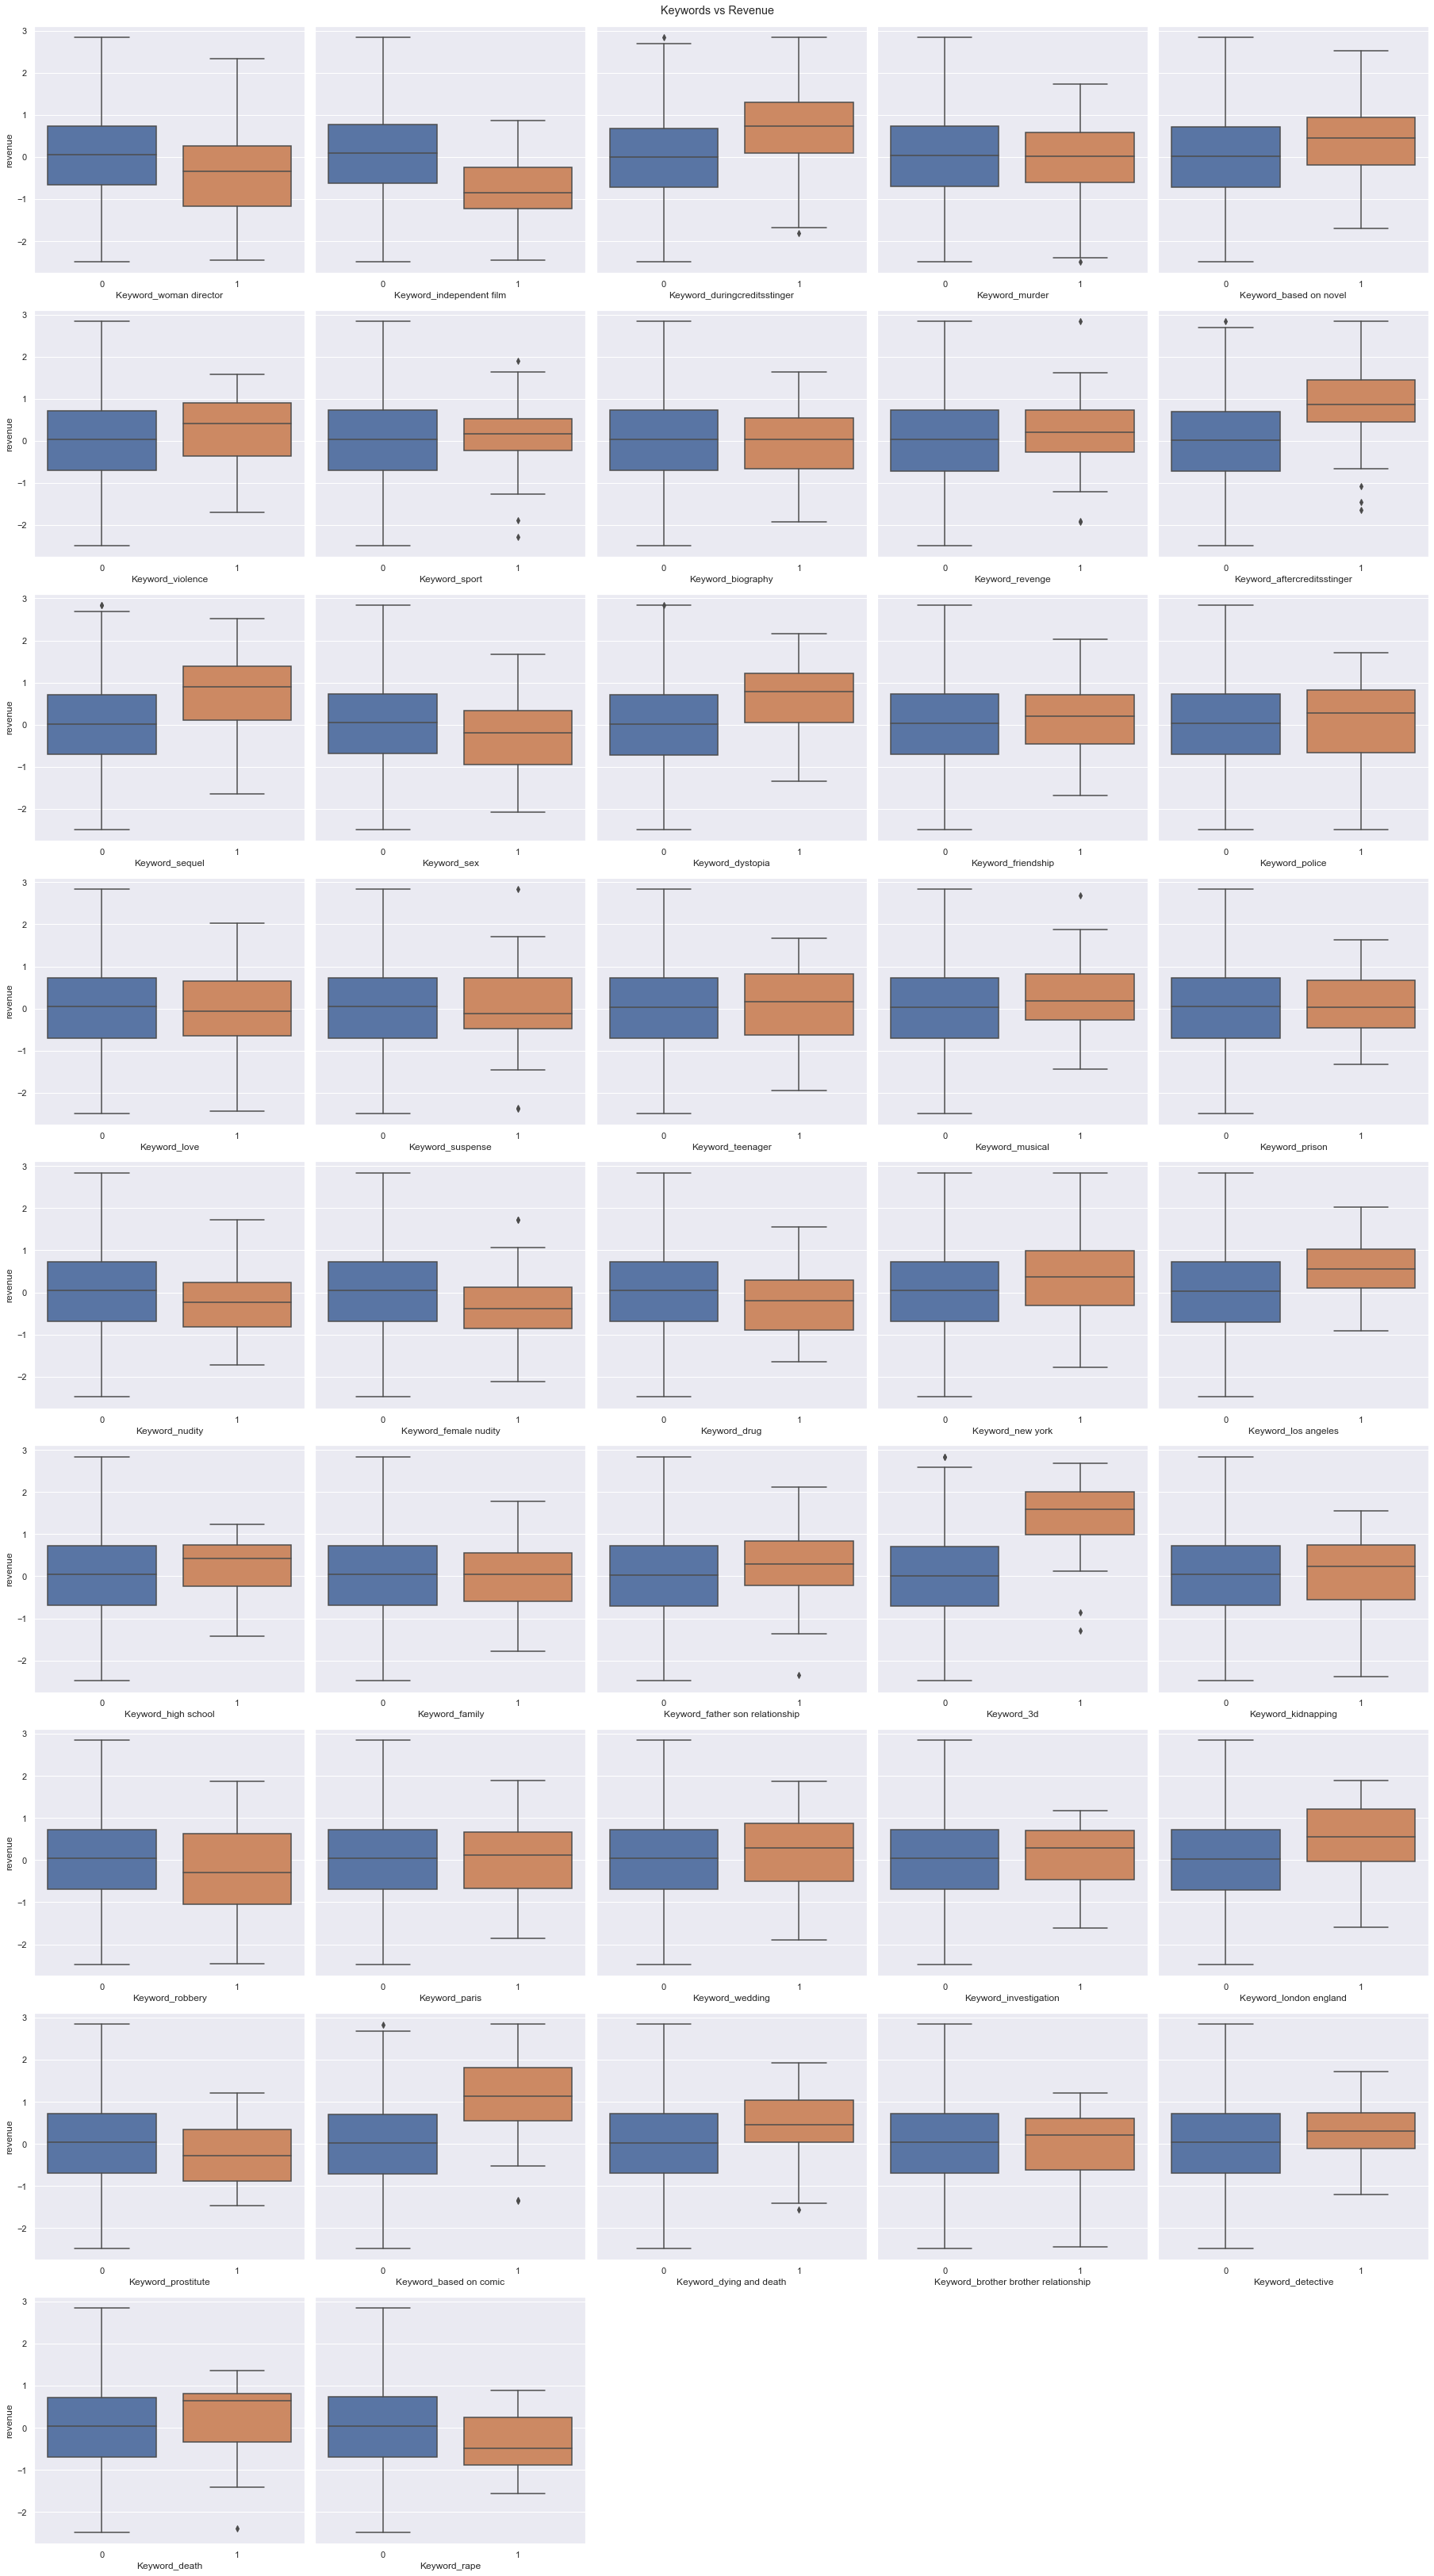

In [119]:
fig, axes = plt.subplots(9, 5, figsize=(25,45), constrained_layout=True, sharey='all')
plt.suptitle('Keywords vs Revenue')
for i, e in enumerate([col for col in train.columns if 'Keyword_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i//5,i%5])
for i in np.arange(2,5):
    fig.delaxes(axes[8,i])
# hide y labels for all columns of plots, except the first column
for i in np.arange(0,9):
    for j in np.arange(1,5):
        axes[i,j].yaxis.label.set_visible(False)
pass;

### cast

In [120]:
for d in datasets:
    print('Number of missing values in the cast column of the {} set:'.format(d.name),
          len(d[d['cast'].apply(lambda x: len(x))==0]))

Number of missing values in the cast column of the train set: 22
Number of missing values in the cast column of the test set: 4
Number of missing values in the cast column of the predict set: 34


In [121]:
train.cast[0]

[{'cast_id': 1,
  'character': 'Black Dynamite',
  'credit_id': '52fe44aac3a368484e02ffa7',
  'gender': 2,
  'id': 64856,
  'name': 'Michael Jai White',
  'order': 0,
  'profile_path': '/zvt4lOlPVVq1MZXmJDWNmBQDnWl.jpg'},
 {'cast_id': 2,
  'character': 'Tasty Freeze',
  'credit_id': '52fe44aac3a368484e02ffab',
  'gender': 2,
  'id': 44994,
  'name': 'Arsenio Hall',
  'order': 1,
  'profile_path': '/czIm2iYMsJszvDZr1aMgBh1El5x.jpg'},
 {'cast_id': 3,
  'character': 'Cream Corn',
  'credit_id': '52fe44aac3a368484e02ffaf',
  'gender': 2,
  'id': 88059,
  'name': 'Tommy Davidson',
  'order': 2,
  'profile_path': '/q0f7F4jYfZ5XvcaeBxtbQlfltLX.jpg'},
 {'cast_id': 4,
  'character': "O'Leary",
  'credit_id': '52fe44aac3a368484e02ffb3',
  'gender': 2,
  'id': 4728,
  'name': 'Kevin Chapman',
  'order': 3,
  'profile_path': '/7uhnHTZ8W4FsSTtbBSCuyeGGqlK.jpg'},
 {'cast_id': 5,
  'character': 'Dino',
  'credit_id': '52fe44aac3a368484e02ffb7',
  'gender': 2,
  'id': 6396,
  'name': 'Richard Edson',


In [122]:
for d in datasets:
    d['cast_missing'] = d['cast'].apply(lambda x: 1 if len(x)==0 else 0)
    d['all_cast_names'] = d['cast'].apply(lambda x: sorted([i['name'] for i in x]) if len(x)!=0 else {})
    # gender
    d['cast_genders_0'] = d['cast'].apply(lambda x: sum([1 for i in x if i['gender']==0]))
    d['cast_genders_1'] = d['cast'].apply(lambda x: sum([1 for i in x if i['gender']==1]))
    d['cast_genders_2'] = d['cast'].apply(lambda x: sum([1 for i in x if i['gender']==2]))
    d['cast_female_percentage'] = d['cast_genders_1'] / (d['cast_genders_1'] + d['cast_genders_2'])    # NaNs will be imputed later in the project
    # cast size
    d['num_cast'] = d['cast'].apply(lambda x: len(x) if len(x)!=0 else np.nan)    # NaNs will be imputed later in the project

In [123]:
train.num_cast.isna().sum()

22

In [124]:
train.cast_female_percentage.isna().sum()

57

In [125]:
train.loc[train.cast_female_percentage.isna(), ['cast', 'cast_missing', 'cast_genders_0', 'cast_genders_1', 'cast_genders_2', 'cast_female_percentage']].head()

cast  cast_missing  \
64   [{'cast_id': 3, 'character': 'Herself "Zana Au...             0   
185                                                 []             1   
206  [{'cast_id': 2, 'character': 'Khatra', 'credit...             0   
208  [{'cast_id': 4, 'character': 'Recep ƒ∞vedik', ...             0   
211                                                 {}             1   

     cast_genders_0  cast_genders_1  cast_genders_2  cast_female_percentage  
64                5               0               0                     NaN  
185               0               0               0                     NaN  
206              15               0               0                     NaN  
208               4               0               0                     NaN  
211               0               0               0                     NaN

In [126]:
cast_genders_list = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if len(x)!=0 else []).values)
cast_genders_counts = Counter([j for i in cast_genders_list for j in i]).most_common()

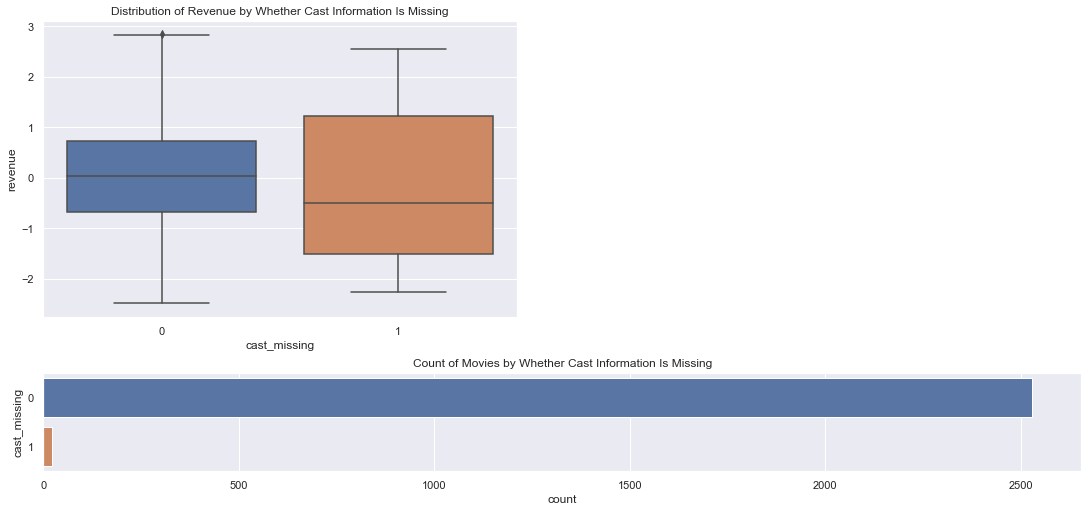

In [127]:
fig = plt.figure(figsize=(15,7), constrained_layout=True)
gs = fig.add_gridspec(4,6)
ax1 = fig.add_subplot(gs[0:3,0:2])
sns.boxplot(train.cast_missing, train.revenue)
ax1.set_title('Distribution of Revenue by Whether Cast Information Is Missing')
ax2 = fig.add_subplot(gs[3,:])
sns.countplot(y=train.cast_missing)
ax2.set_title('Count of Movies by Whether Cast Information Is Missing');

num_cast
Number of unique values  104.000000
Minimum                    1.000000
Maximum                  156.000000
Range                    155.000000
Skewness                   2.661050
Kurtosis                  10.163565

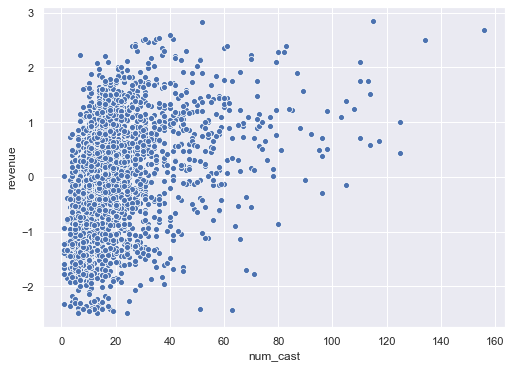

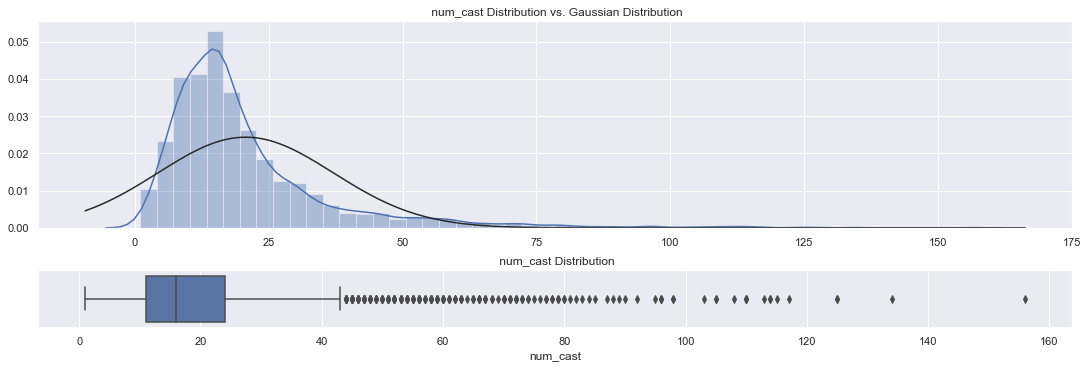

In [128]:
fig = plt.figure(figsize=(7,5), constrained_layout=True)
sns.scatterplot('num_cast', 'revenue', data=train)
num_univariate(train, 'num_cast', '');

cast_female_percentage
Number of unique values              251.000000
Minimum                                0.000000
Maximum                                1.000000
Range                                  1.000000
Skewness                               0.498159
Kurtosis                               0.607063

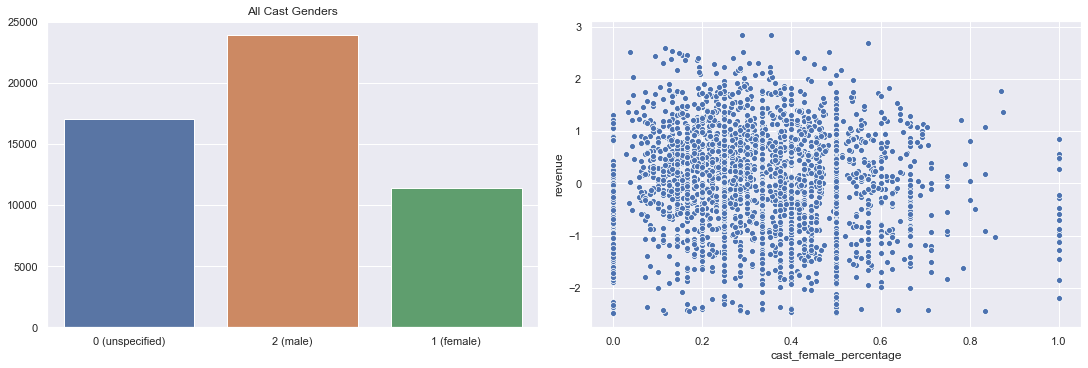

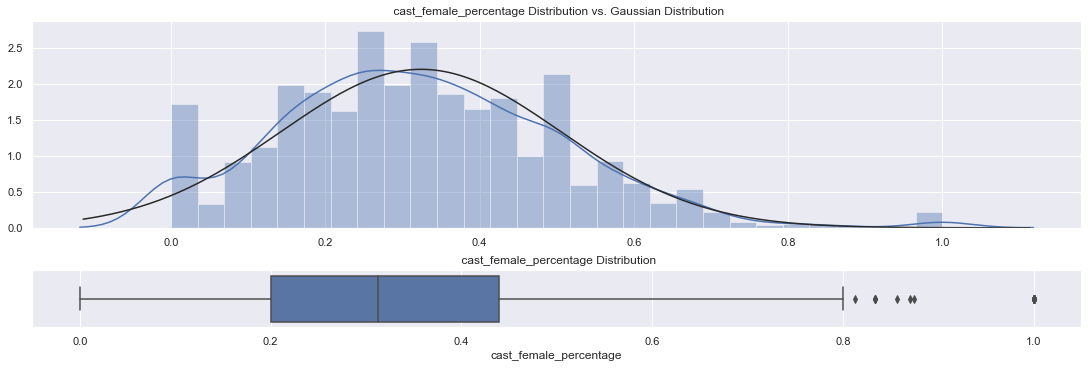

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.barplot([i[0] for i in cast_genders_counts], [i[1] for i in cast_genders_counts], order=[0,2,1], ax=axes[0])
axes[0].set_xticklabels(['0 (unspecified)', '2 (male)', '1 (female)'])
axes[0].set_title('All Cast Genders')
sns.scatterplot('cast_female_percentage', 'revenue', data=train, ax=axes[1])
num_univariate(train, 'cast_female_percentage', '')
pass;

In [130]:
cast_names_counts = Counter([j for i in train['all_cast_names'] for j in i])
len(cast_names_counts)

33857

In [131]:
len([i for i in cast_names_counts.values() if i>=15])

65

In [132]:
for d in datasets:
    for i in cast_names_counts.most_common(65):
        d['cast_names_' + i[0]] = d['all_cast_names'].apply(lambda x: 1 if i[0] in x else 0)

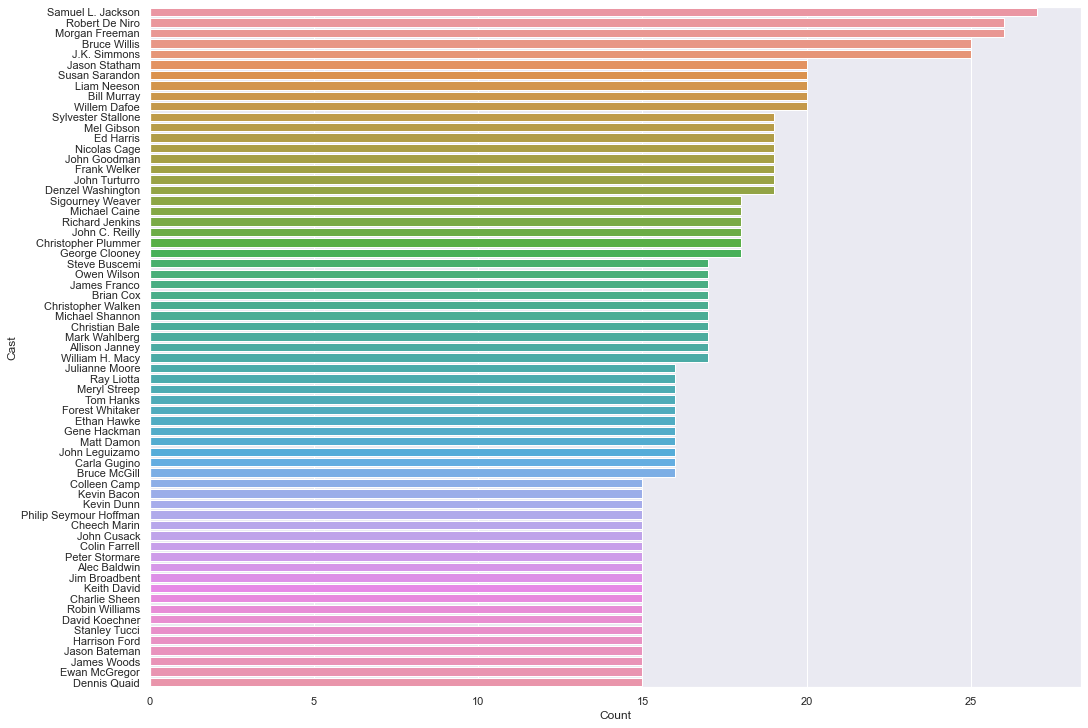

In [133]:
plt.figure(figsize=(15,10), constrained_layout=True)
sns.barplot([i[1] for i in cast_names_counts.most_common(65)], [i[0] for i in cast_names_counts.most_common(65)])
plt.xlabel('Count')
plt.ylabel('Cast');

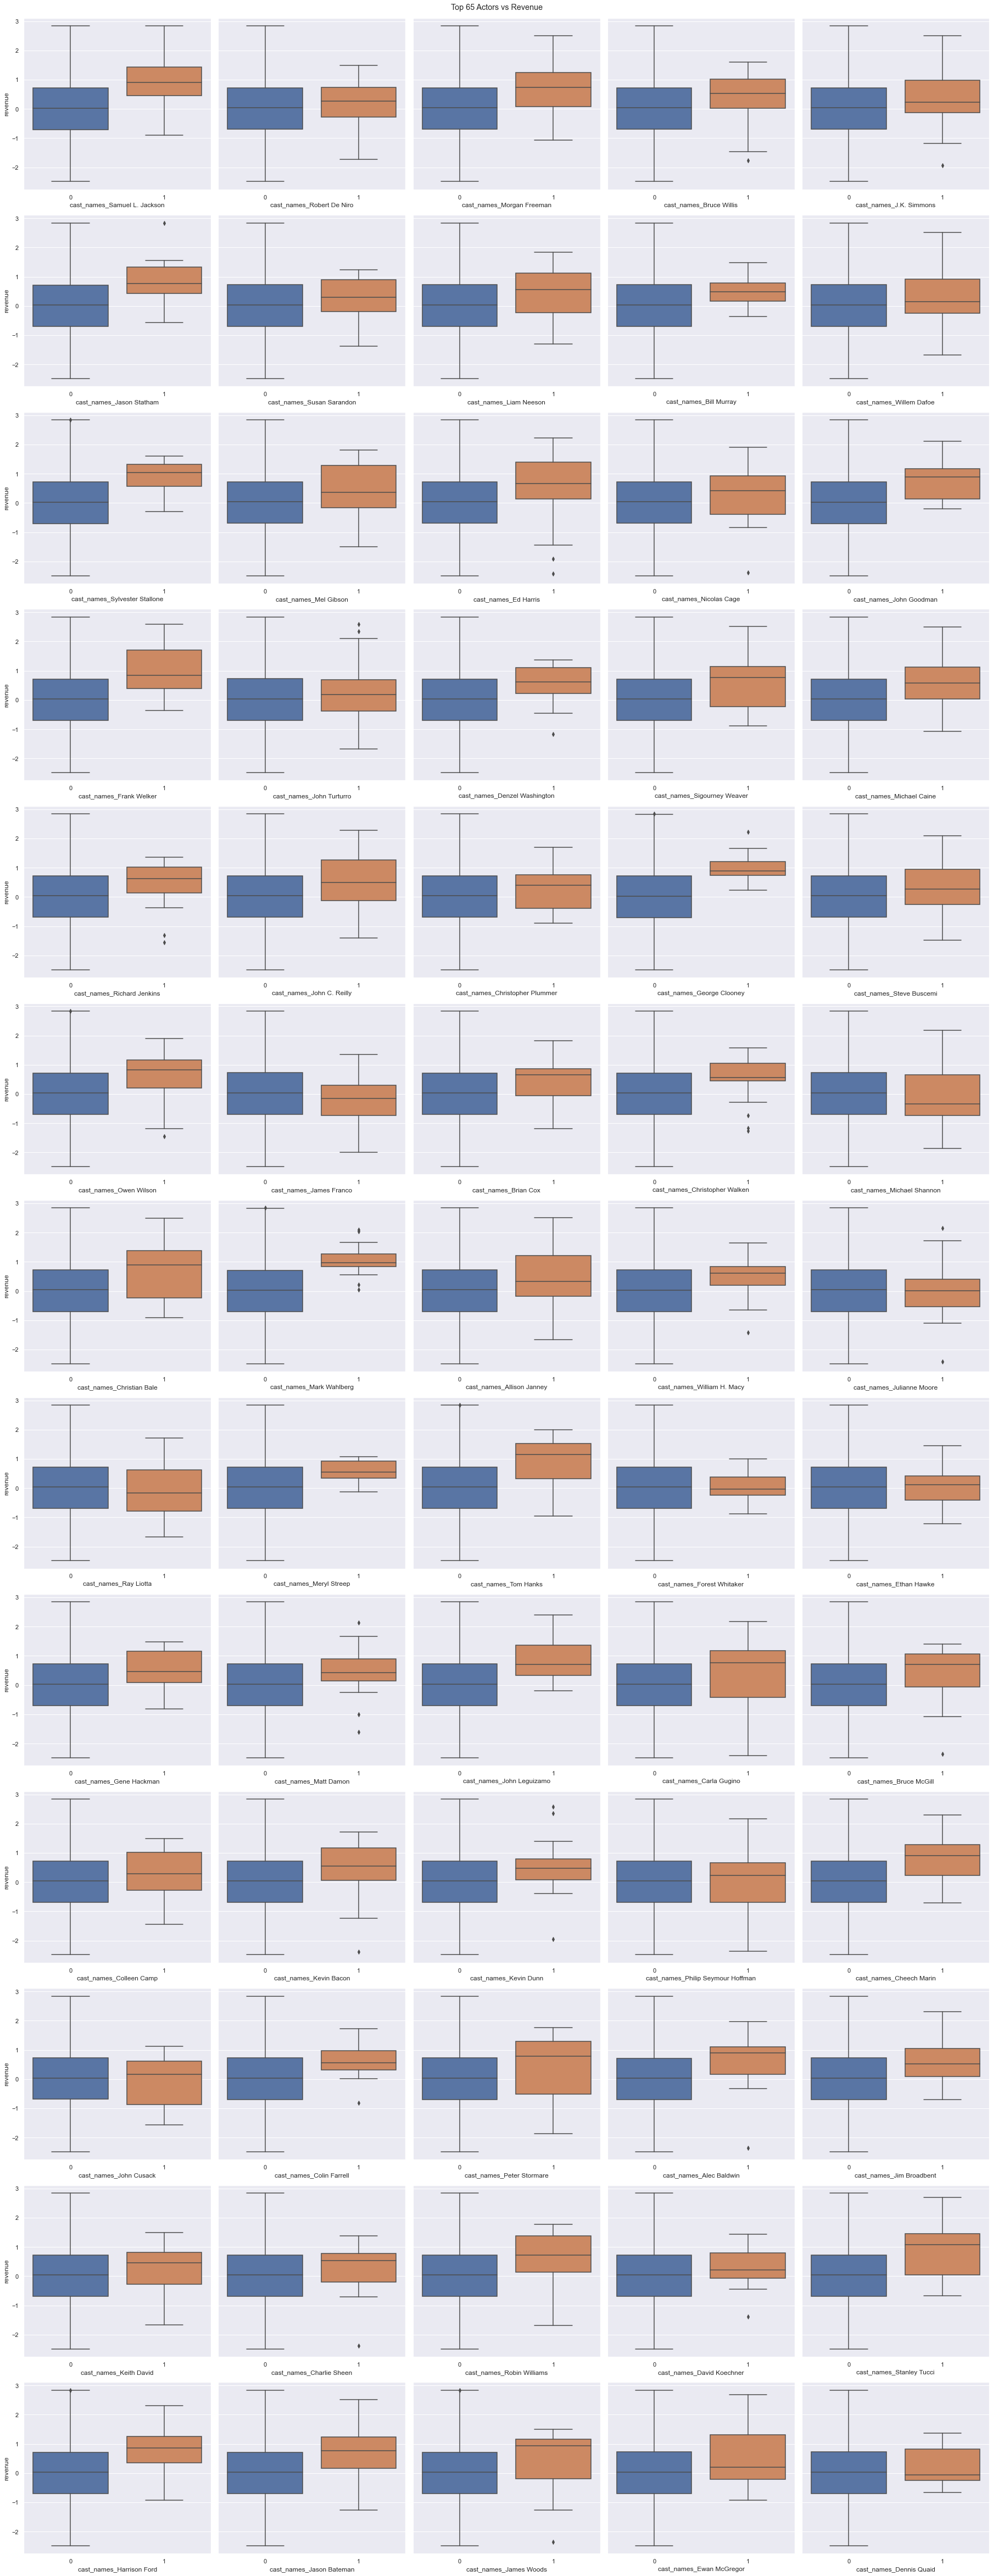

In [134]:
fig, axes = plt.subplots(13, 5, figsize=(25,65), constrained_layout=True, sharey='all')
plt.suptitle('Top 65 Actors vs Revenue')
for i, e in enumerate([col for col in train.columns if 'cast_names_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i//5,i%5])
# hide y labels for all columns of plots, except the first column
for i in np.arange(0,13):
    for j in np.arange(1,5):
        axes[i,j].yaxis.label.set_visible(False)
pass;

In [135]:
for d in datasets:
    d['num_films_per_top_cast_name'] = d['all_cast_names'].apply(lambda x: max([cast_names_counts[i] for i in x])\
                                                                 if len(x)!=0 else np.nan)    # NaN's will be imputer later in the project

In [136]:
train.num_films_per_top_cast_name.isna().sum()

22

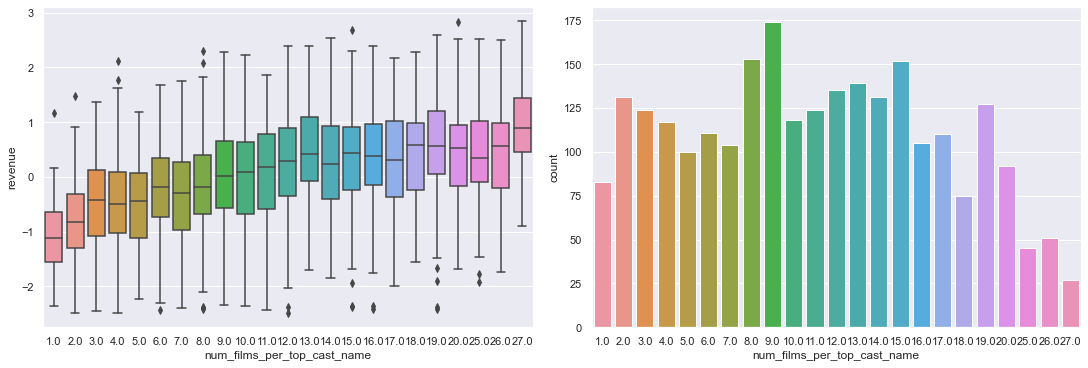

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.boxplot('num_films_per_top_cast_name', 'revenue', data=train, ax=axes[0])
sns.countplot('num_films_per_top_cast_name', data=train, ax=axes[1]);

In [138]:
print('Correlation between num_films_per_top_cast_name and revenue:', train[['revenue', 'num_films_per_top_cast_name']].corr().loc['revenue', 'num_films_per_top_cast_name'])

Correlation between num_films_per_top_cast_name and revenue: 0.3943666943159087


num_films_per_top_cast_name
Number of unique values                    23.000000
Minimum                                     1.000000
Maximum                                    27.000000
Range                                      26.000000
Skewness                                    0.363345
Kurtosis                                   -0.431417

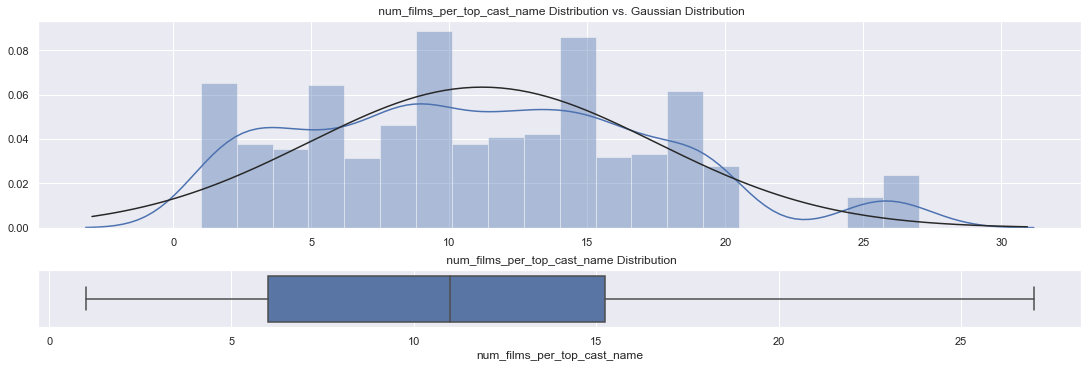

In [139]:
num_univariate(train, 'num_films_per_top_cast_name', '')

### crew

In [140]:
for d in datasets:
    print('Number of missing values in the crew column of the {} set:'.format(d.name),
          len(d[d['crew']=={}]))

Number of missing values in the crew column of the train set: 13
Number of missing values in the crew column of the test set: 3
Number of missing values in the crew column of the predict set: 22


In [141]:
train.crew[0]

[{'credit_id': '53bac882c3a3685eb7007294',
  'department': 'Production',
  'gender': 2,
  'id': 7415,
  'job': 'Casting',
  'name': 'Rick Montgomery',
  'profile_path': None},
 {'credit_id': '53bac941c3a368072e004603',
  'department': 'Costume & Make-Up',
  'gender': 1,
  'id': 15524,
  'job': 'Costume Design',
  'name': 'Ruth E. Carter',
  'profile_path': None},
 {'credit_id': '53bac90dc3a3685ea800720e',
  'department': 'Art',
  'gender': 1,
  'id': 38021,
  'job': 'Production Design',
  'name': 'Denise Pizzini',
  'profile_path': None},
 {'credit_id': '53bac6a30e0a2676c700c379',
  'department': 'Crew',
  'gender': 2,
  'id': 52260,
  'job': 'Cinematography',
  'name': 'Shawn Maurer',
  'profile_path': None},
 {'credit_id': '53baca43c3a3685ebd0073a9',
  'department': 'Crew',
  'gender': 2,
  'id': 61703,
  'job': 'Stunt Coordinator',
  'name': 'Ron Yuan',
  'profile_path': '/7mmuII6M3JGDg5hC9Bl4nORPwEV.jpg'},
 {'credit_id': '52fe44aac3a368484e02ffc3',
  'department': 'Writing',
  'gen

In [142]:
crew_genders_list = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if len(x)!=0 else []).values)
crew_departments_list = list(train['crew'].apply(lambda x: [i['department'] for i in x] if len(x)!=0 else []).values)
crew_jobs_list = list(train['crew'].apply(lambda x: [i['job'] for i in x] if len(x)!=0 else []).values)

crew_genders_counts = Counter([j for i in crew_genders_list for j in i]).most_common()
crew_departments_counts = Counter([j for i in crew_departments_list for j in i]).most_common()
crew_jobs_counts = Counter([j for i in crew_jobs_list for j in i]).most_common()

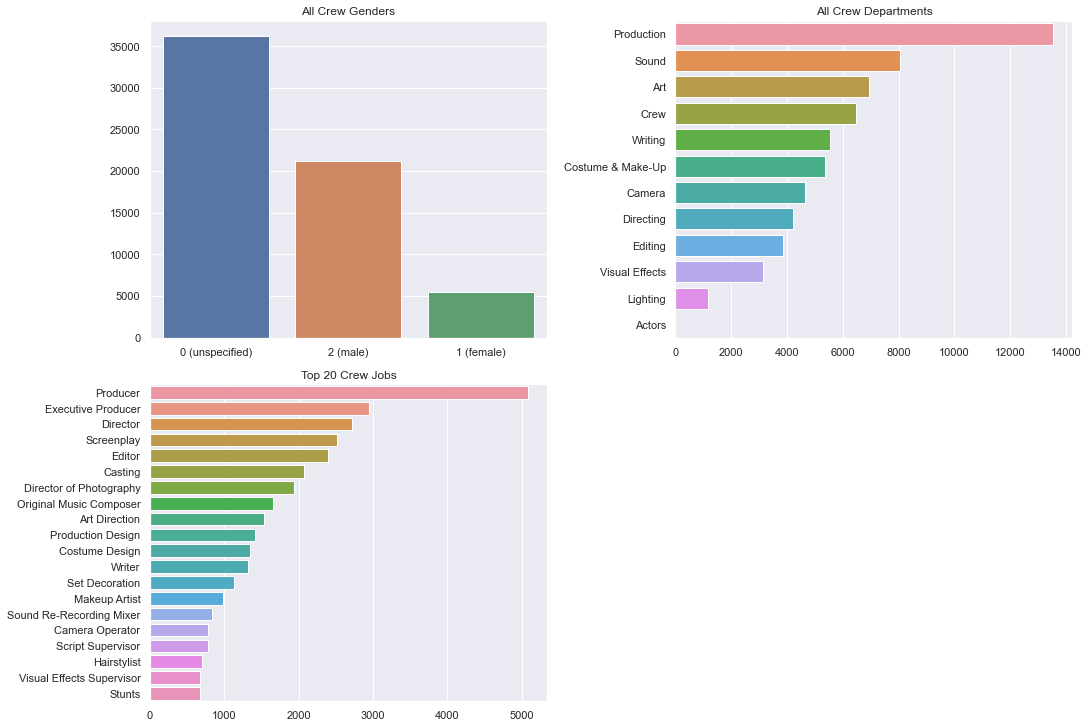

Number of unique crew jobs: 404


In [143]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)
sns.barplot([i[0] for i in crew_genders_counts], [i[1] for i in crew_genders_counts], order=[0,2,1], ax=axes[0,0])
axes[0,0].set_xticklabels(['0 (unspecified)', '2 (male)', '1 (female)'])
axes[0,0].set_title('All Crew Genders')
sns.barplot([i[1] for i in crew_departments_counts], [i[0] for i in crew_departments_counts], ax=axes[0,1])
axes[0,1].set_title('All Crew Departments')
sns.barplot([i[1] for i in crew_jobs_counts[:20]], [i[0] for i in crew_jobs_counts[:20]], ax=axes[1,0])
axes[1,0].set_title('Top 20 Crew Jobs')
fig.delaxes(axes[1,1])
plt.show()
print('Number of unique crew jobs:', len(crew_jobs_counts))
pass;

In [144]:
for d in datasets:
    d['crew_missing'] = d['crew'].apply(lambda x: 1 if x=={} else 0)
    # list of all ...
    d['all_directors'] = d['crew'].apply(lambda x: sorted([i['name'] for i in x if i['job']=='Director'])\
                                         if len(x)!=0 else {})
    d['all_producers'] = d['crew'].apply(lambda x: sorted([i['name'] for i in x if i['job']=='Producer'])\
                                         if len(x)!=0 else {})
    d['all_exec_producers'] = d['crew'].apply(lambda x: sorted([i['name'] for i in x\
                                                                if i['job']=='Executive Producer']) if len(x)!=0 else {})
    d['all_screenplay'] = d['crew'].apply(lambda x: sorted([i['name'] for i in x if i['job']=='Screenplay'])\
                                         if len(x)!=0 else {})
    # gender
    d['crew_genders_0'] = d['crew'].apply(lambda x: sum([1 for i in x if i['gender']==0]))
    d['crew_genders_1'] = d['crew'].apply(lambda x: sum([1 for i in x if i['gender']==1]))
    d['crew_genders_2'] = d['crew'].apply(lambda x: sum([1 for i in x if i['gender']==2]))
    d['crew_female_percentage'] = d['crew_genders_1'] / (d['crew_genders_1'] + d['crew_genders_2'])    # NaN's will be imputer later in the project
    # number of crew members
    d['num_crew'] = d['crew'].apply(lambda x: len(x) if len(x)!=0 else np.nan)    # NaN's will be imputer later in the project
    for i in crew_departments_counts:
        d['crew_departments_' + i[0]] = d['crew'].apply(lambda x: sum([1 for j in x if j['department']==i[0]]))

In [145]:
train.num_crew.isna().sum()

13

In [146]:
train.crew_female_percentage.isna().sum()

127

In [147]:
train.loc[train.crew_female_percentage.isna(), ['crew', 'crew_missing', 'crew_genders_0', 'crew_genders_1', 'crew_genders_2', 'crew_female_percentage']].head()

crew  crew_missing  \
26   [{'credit_id': '581c802f9251412f64009230', 'de...             0   
32   [{'credit_id': '52fe494bc3a36847f8192d15', 'de...             0   
64   [{'credit_id': '52fe42f2c3a36847f802efed', 'de...             0   
65   [{'credit_id': '58bfc49cc3a36868ee004aee', 'de...             0   
161  [{'credit_id': '52fe464cc3a368484e088f3b', 'de...             0   

     crew_genders_0  crew_genders_1  crew_genders_2  crew_female_percentage  
26                2               0               0                     NaN  
32                2               0               0                     NaN  
64                2               0               0                     NaN  
65                9               0               0                     NaN  
161               2               0               0                     NaN

Create a column that indicates how many movies in the **training** set a director, executive producer, producer, or screenplay writer of a particular movie has worked on. If a crew member has not worked on any movie in the **training** set, the feature value will be 0 –– this will be the case for some movies in the test and predict sets.

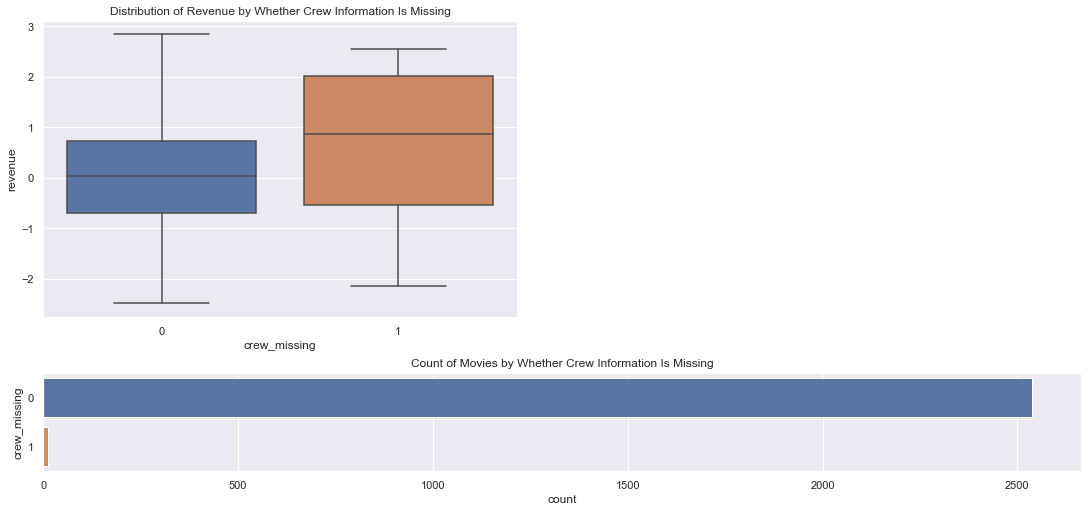

In [148]:
fig = plt.figure(figsize=(15,7), constrained_layout=True)
gs = fig.add_gridspec(4,6)
ax1 = fig.add_subplot(gs[0:3,0:2])
sns.boxplot(train.crew_missing, train.revenue)
ax1.set_title('Distribution of Revenue by Whether Crew Information Is Missing')
ax2 = fig.add_subplot(gs[3,:])
sns.countplot(y=train.crew_missing)
ax2.set_title('Count of Movies by Whether Crew Information Is Missing');

num_crew
Number of unique values  147.000000
Minimum                    1.000000
Maximum                  194.000000
Range                    193.000000
Skewness                   2.259801
Kurtosis                   5.476316

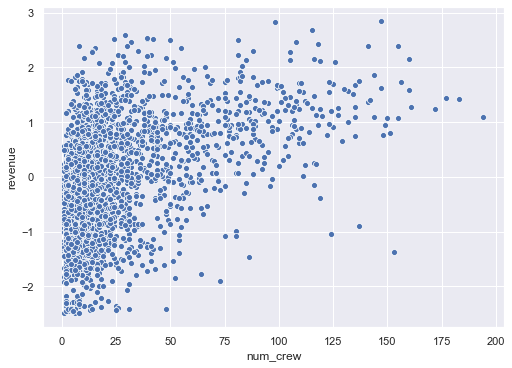

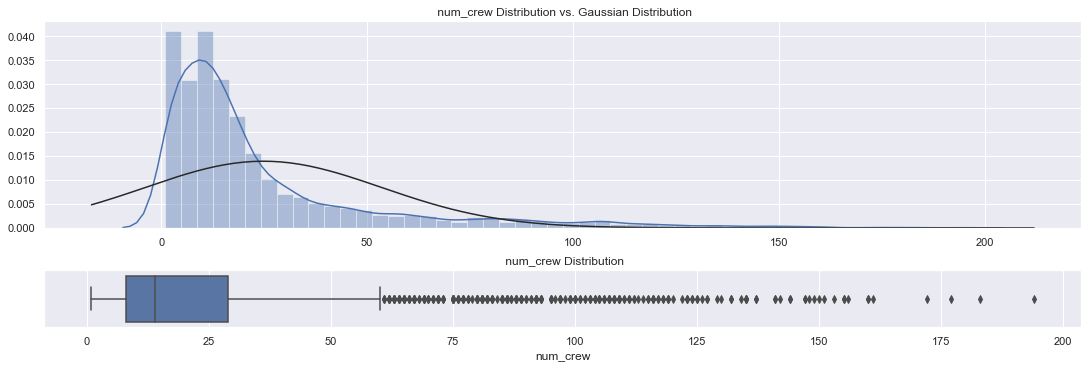

In [149]:
fig = plt.figure(figsize=(7,5), constrained_layout=True)
sns.scatterplot('num_crew', 'revenue', data=train)
num_univariate(train, 'num_crew', '');

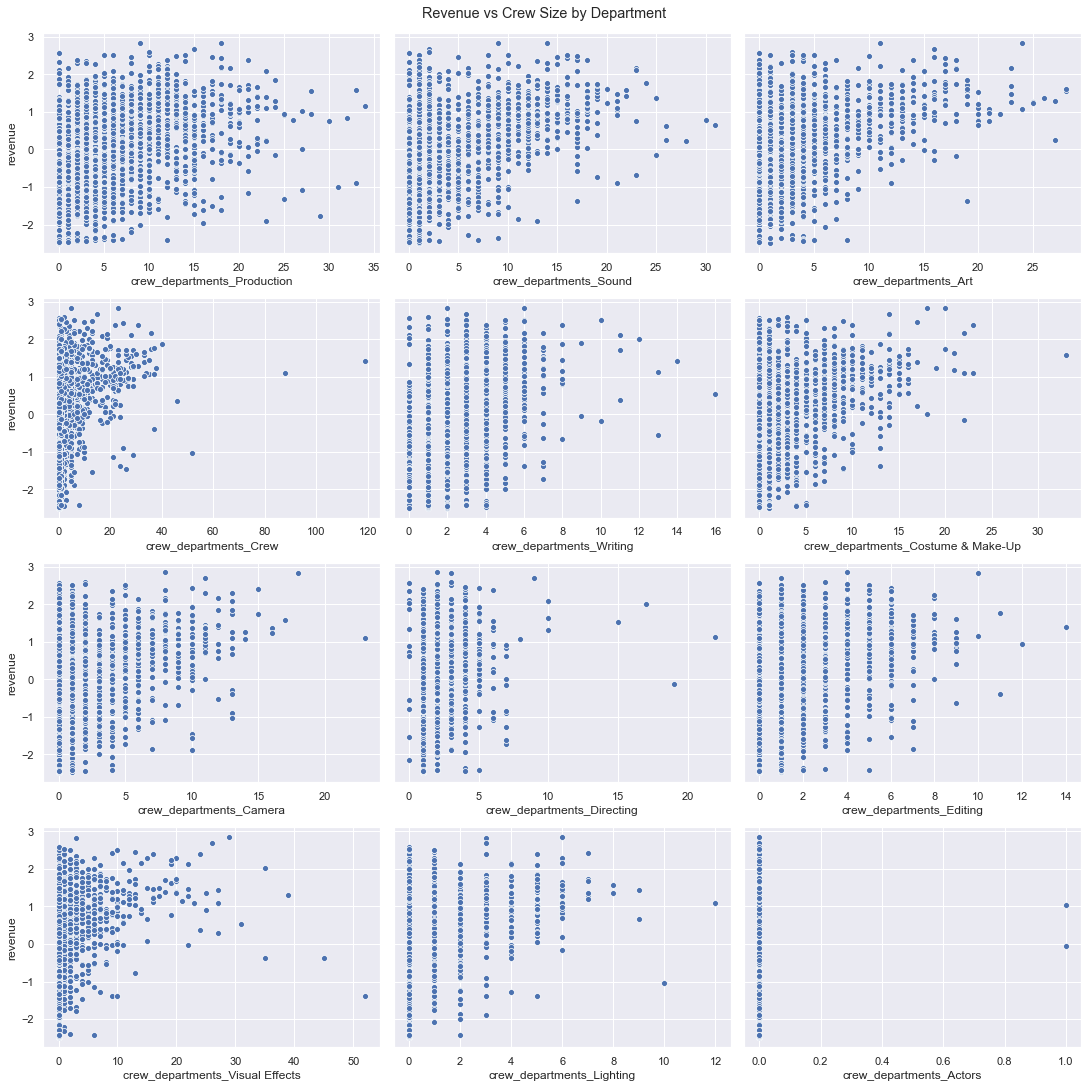

In [150]:
fig, axes = plt.subplots(4, 3, figsize=(15,15), constrained_layout=True, sharey='all')
plt.suptitle('Revenue vs Crew Size by Department')
for i, e in enumerate([col for col in train.columns if 'crew_departments_' in col]):
    sns.scatterplot(train[e], train['revenue'], ax=axes[i//3,i%3])
# hide y labels for all columns of plots, except the first column
for i in np.arange(0,4):
    for j in np.arange(1,3):
        axes[i,j].yaxis.label.set_visible(False)
pass;

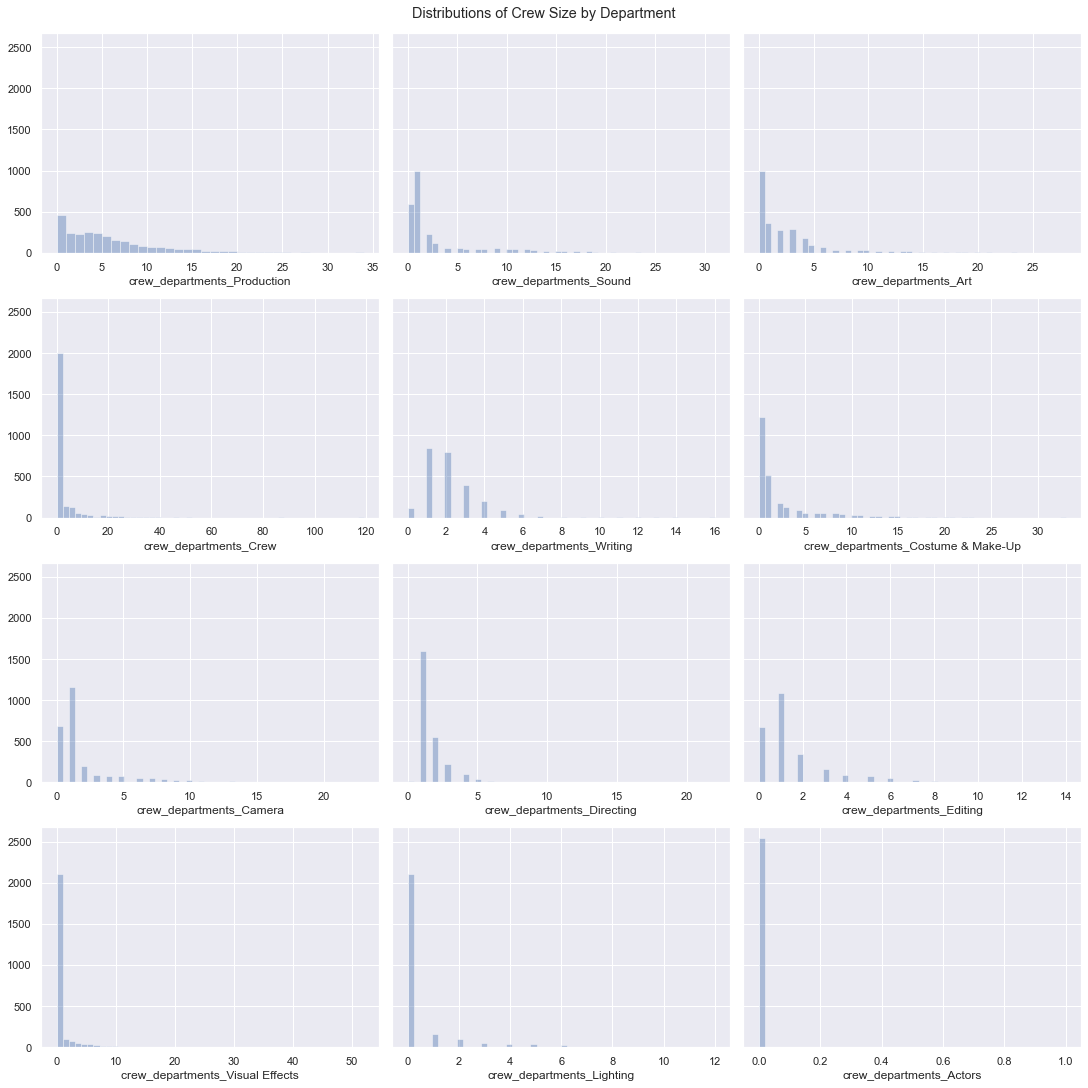

In [151]:
fig, axes = plt.subplots(4, 3, figsize=(15,15), constrained_layout=True, sharey='all')
plt.suptitle('Distributions of Crew Size by Department')
for i, e in enumerate([col for col in train.columns if 'crew_departments_' in col]):
    sns.distplot(train[e], ax=axes[i//3,i%3], kde=False)
# hide y labels for all columns of plots, except the first column
for i in np.arange(0,4):
    for j in np.arange(1,3):
        axes[i,j].yaxis.label.set_visible(False)
pass;

In [152]:
cols = [col for col in train.columns if 'crew_departments_' in col]

for d in datasets:
    for col in cols:
        d[col + '_missing'] = d[col].apply(lambda x: 1 if x==0 else 0)
    d.loc[d.crew.apply(lambda x: 1 if len(x)==0 else 0)==1, cols] = 0

crew_female_percentage
Number of unique values              185.000000
Minimum                                0.000000
Maximum                                1.000000
Range                                  1.000000
Skewness                               1.521963
Kurtosis                               3.533768

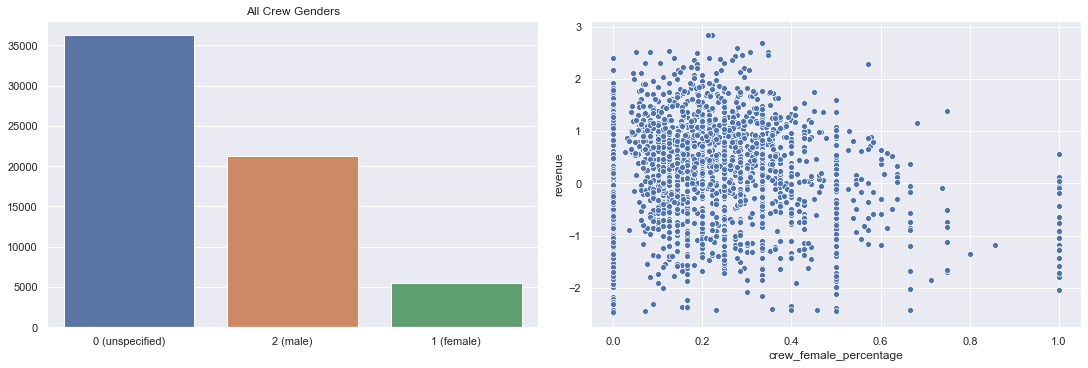

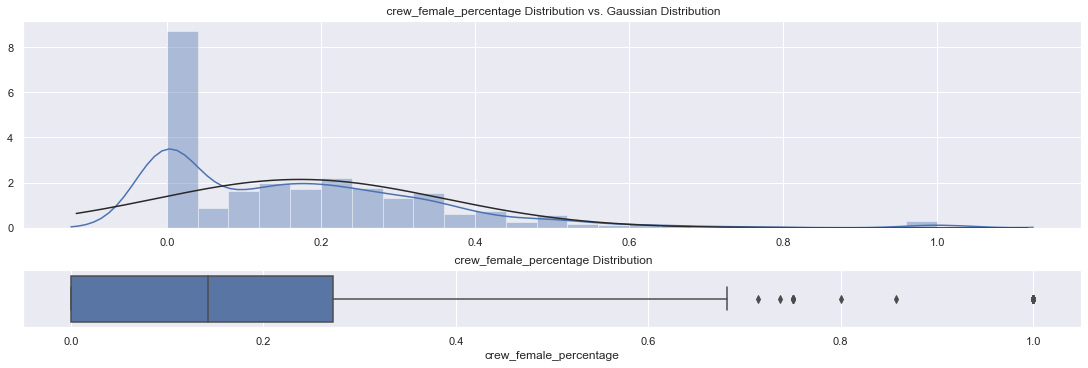

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
sns.barplot([i[0] for i in crew_genders_counts], [i[1] for i in crew_genders_counts], order=[0,2,1], ax=axes[0])
axes[0].set_xticklabels(['0 (unspecified)', '2 (male)', '1 (female)'])
axes[0].set_title('All Crew Genders')
sns.scatterplot('crew_female_percentage', 'revenue', data=train, ax=axes[1])
num_univariate(train, 'crew_female_percentage', '');

In [154]:
crew_jobs_director_counts = Counter([j for i in train['all_directors'] for j in i])
crew_jobs_exec_producer_counts = Counter([j for i in train['all_exec_producers'] for j in i])
crew_jobs_producer_counts = Counter([j for i in train['all_producers'] for j in i])
crew_jobs_screenplay_counts = Counter([j for i in train['all_screenplay'] for j in i])

# NaN's in the following 4 columns will be imputer later in the project
for d in datasets:
    d['num_films_per_top_director'] = d['all_directors'].apply(lambda x: max([crew_jobs_director_counts[i] for i in x]) if len(x)!=0 else -1)
    d['num_films_per_top_exec_producer'] = d['all_exec_producers'].apply(lambda x: max([crew_jobs_exec_producer_counts[i] for i in x]) if len(x)!=0 else -1)
    d['num_films_per_top_producer'] = d['all_producers'].apply(lambda x: max([crew_jobs_producer_counts[i] for i in x]) if len(x)!=0 else -1)
    d['num_films_per_top_screenplay'] = d['all_screenplay'].apply(lambda x: max([crew_jobs_screenplay_counts[i] for i in x]) if len(x)!=0 else -1)

In [155]:
len(train.loc[train.num_films_per_top_director==-1])
len(train.loc[train.num_films_per_top_exec_producer==-1])
len(train.loc[train.num_films_per_top_producer==-1])
len(train.loc[train.num_films_per_top_screenplay==-1])

13

1430

529

1028

In [156]:
len(train[train.all_directors.apply(lambda x: len(x))==0])
len(train[train.all_exec_producers.apply(lambda x: len(x))==0])
len(train[train.all_producers.apply(lambda x: len(x))==0])
len(train[train.all_screenplay.apply(lambda x: len(x))==0])

13

1430

529

1028

In [157]:
for d in datasets:
    d['director_missing'] = d['all_directors'].apply(lambda x: 1 if len(x)==0 else 0)
    d['exec_producer_missing'] = d['all_exec_producers'].apply(lambda x: 1 if len(x)==0 else 0)
    d['producer_missing'] = d['all_producers'].apply(lambda x: 1 if len(x)==0 else 0)
    d['screenplay_missing'] = d['all_screenplay'].apply(lambda x: 1 if len(x)==0 else 0)
    d.loc[d.crew.apply(lambda x: 1 if len(x)==0 else 0)==1, ['director_missing', 'exec_producer_missing',
                                                                  'producer_missing', 'screenplay_missing']] = 0
    d.loc[d.crew.apply(lambda x: 1 if len(x)==0 else 0)==1, ['num_films_per_top_director',
        'num_films_per_top_exec_producer', 'num_films_per_top_producer', 'num_films_per_top_screenplay']] = np.nan

In [158]:
for d in datasets:
    for i in crew_jobs_director_counts.most_common(15):
        d['crew_jobs_director_' + i[0]] = d['all_directors'].apply(lambda x: 1 if i[0] in x else 0)
    for i in crew_jobs_exec_producer_counts.most_common(15):
        d['crew_jobs_exec_producer_' + i[0]] = d['all_exec_producers'].apply(lambda x: 1 if i[0] in x else 0)
    for i in crew_jobs_producer_counts.most_common(15):
        d['crew_jobs_producer_' + i[0]] = d['all_producers'].apply(lambda x: 1 if i[0] in x else 0)
    for i in crew_jobs_screenplay_counts.most_common(15):
        d['crew_jobs_screenplay_' + i[0]] = d['all_screenplay'].apply(lambda x: 1 if i[0] in x else 0)

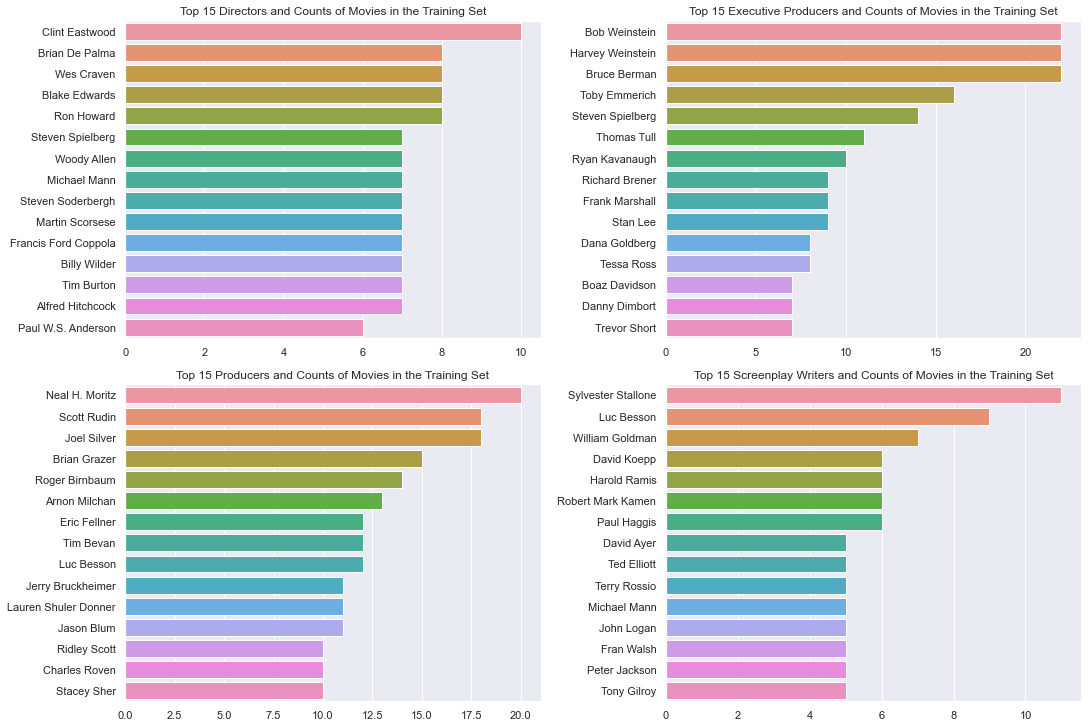

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)
for j, e in enumerate([crew_jobs_director_counts.most_common(15),
          crew_jobs_exec_producer_counts.most_common(15),
          crew_jobs_producer_counts.most_common(15),
          crew_jobs_screenplay_counts.most_common(15)]):
    sns.barplot([i[1] for i in e], [i[0] for i in e], ax=axes[j//2,j%2])
axes[0,0].set_title('Top 15 Directors and Counts of Movies in the Training Set')
axes[0,1].set_title('Top 15 Executive Producers and Counts of Movies in the Training Set')
axes[1,0].set_title('Top 15 Producers and Counts of Movies in the Training Set')
axes[1,1].set_title('Top 15 Screenplay Writers and Counts of Movies in the Training Set');

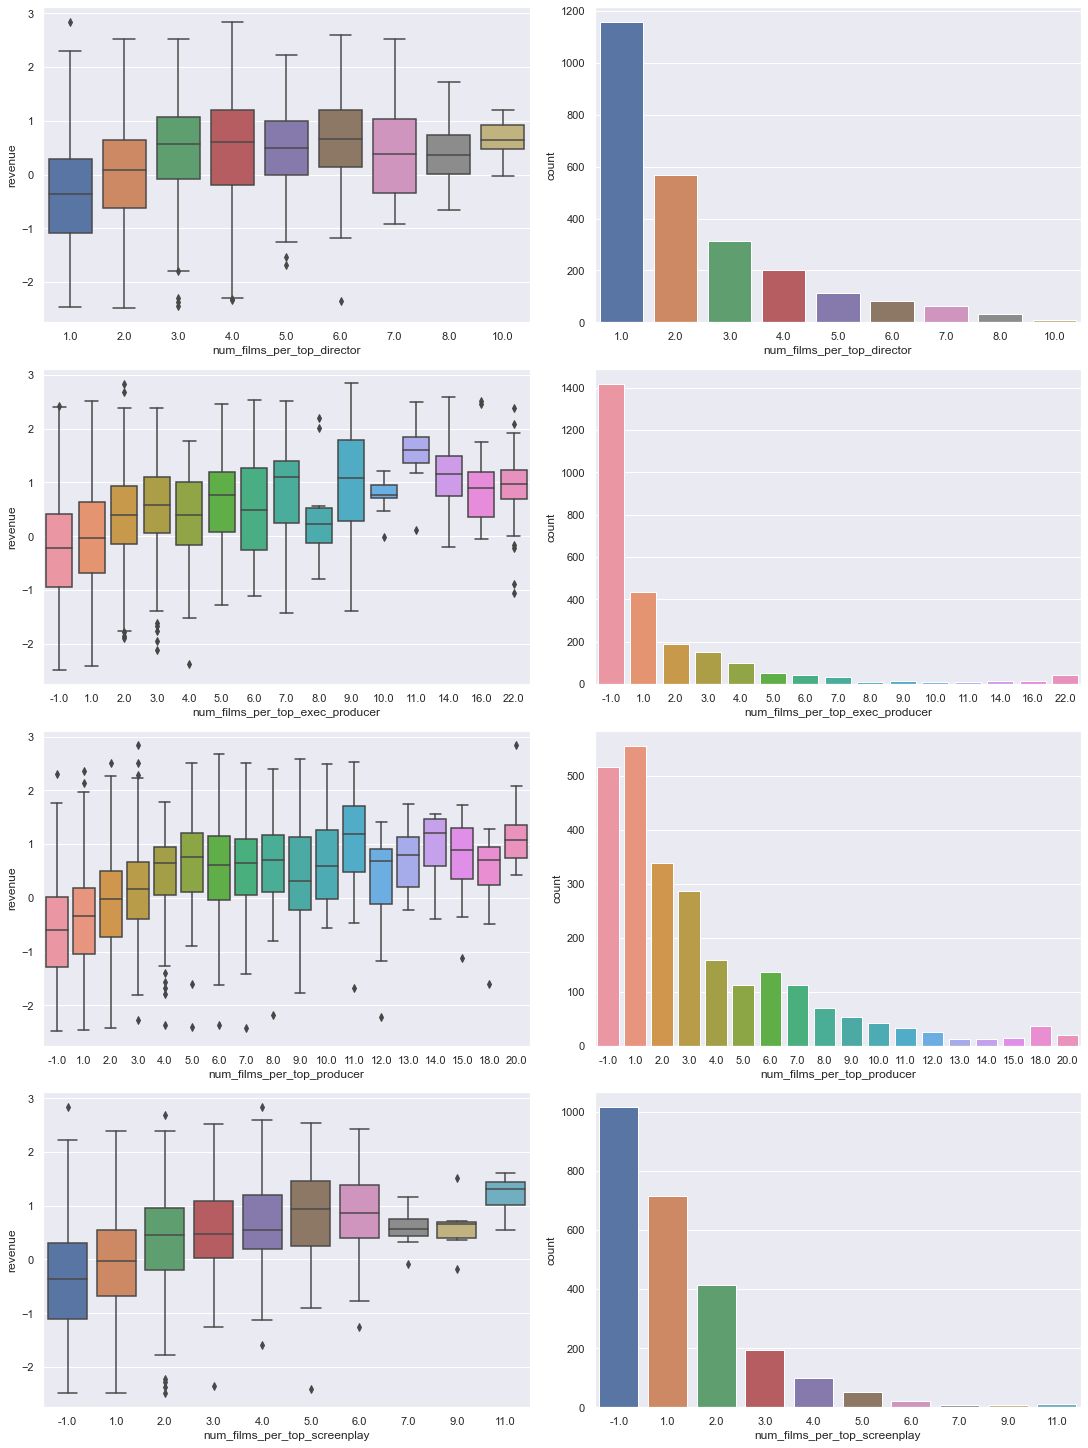

In [160]:
fig, axes = plt.subplots(4, 2, figsize=(15,20), constrained_layout=True)
for i, e in enumerate(['num_films_per_top_director', 'num_films_per_top_exec_producer',
                       'num_films_per_top_producer', 'num_films_per_top_screenplay']):
    sns.boxplot(e, 'revenue', data=train, ax=axes[i,0])
    sns.countplot(e, data=train, ax=axes[i,1])
pass;

In [161]:
train[['num_films_per_top_director', 'num_films_per_top_exec_producer', 'num_films_per_top_producer', 'num_films_per_top_screenplay',
       'revenue']].corr().loc[['revenue']]

num_films_per_top_director  num_films_per_top_exec_producer  \
revenue                    0.321844                          0.31628   

         num_films_per_top_producer  num_films_per_top_screenplay  revenue  
revenue                    0.416362                      0.356502      1.0

In [162]:
for d in datasets:
    d.loc[d['num_films_per_top_director']>=3, 'num_films_per_top_director'] = 3
    d.loc[d['num_films_per_top_producer']>=5, 'num_films_per_top_producer'] = 5

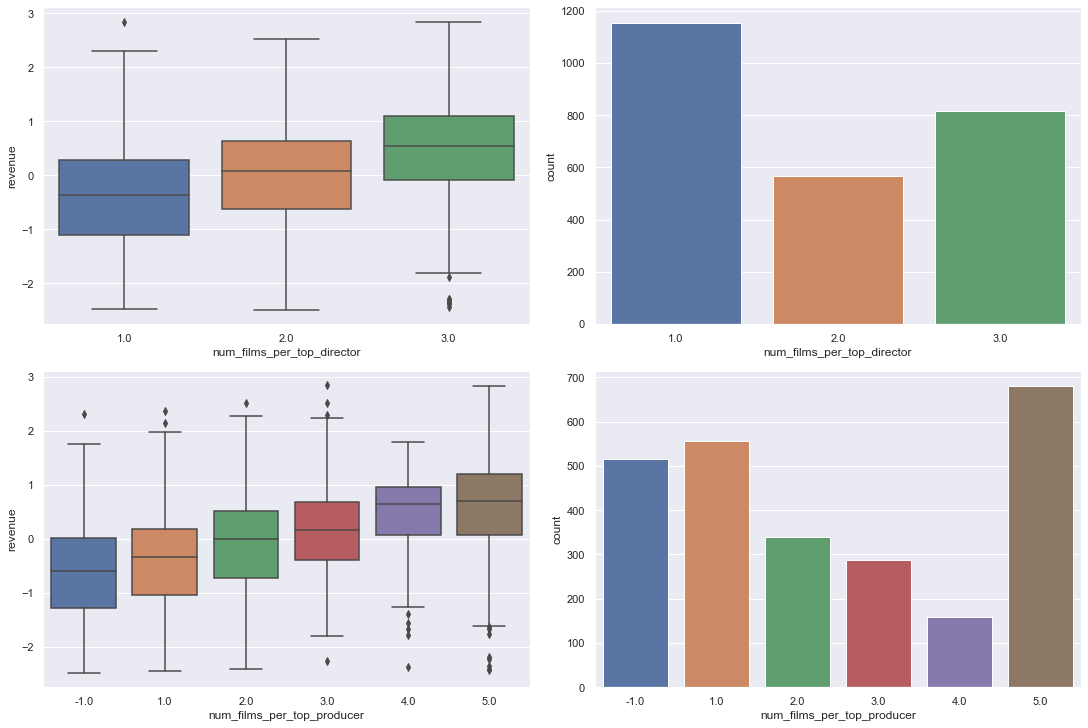

In [163]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), constrained_layout=True)
sns.boxplot('num_films_per_top_director', 'revenue', data=train, ax=axes[0,0])
sns.countplot('num_films_per_top_director', data=train, ax=axes[0,1])
sns.boxplot('num_films_per_top_producer', 'revenue', data=train, ax=axes[1,0])
sns.countplot('num_films_per_top_producer', data=train, ax=axes[1,1])
pass;

In [164]:
train[['num_films_per_top_director', 'num_films_per_top_producer', 'revenue']].corr().loc[['revenue']]

num_films_per_top_director  num_films_per_top_producer  revenue
revenue                    0.371479                    0.471431      1.0

## Original Columns That Will Not Be Used
The following columns will not be used in the model for reasons below. These original features, along with some new features that we have generated already and that we will generate later, will be dropped all together right before the modeling section.

### id, imdb_id, original_title and title

In [165]:
train.id.head()

0     423
1     839
2    1736
3     747
4     901
Name: id, dtype: int64

In [166]:
train.imdb_id.head()

0    tt1190536
1    tt0427969
2    tt0107290
3    tt0780607
4    tt1366365
Name: imdb_id, dtype: object

In [167]:
train.original_title.head()

0           Black Dynamite
1            Hollywoodland
2            Jurassic Park
3               The Signal
4    The Cold Light of Day
Name: original_title, dtype: object

In [168]:
train.title.head()

0           Black Dynamite
1            Hollywoodland
2            Jurassic Park
3               The Signal
4    The Cold Light of Day
Name: title, dtype: object

From the sanity checks we did after loading the data at the beginning of the project, we know there are no diplicate entries. Every individual movie appears exactly once in the data. Some movies have the same titles or original titles, but all of them are indeed different films. These are identifier columns and provide no value to the model.

### overview and tagline

In [169]:
train.overview.head()

0    This is the story of 1970s African-American ac...
1    The complicated life and controversial suicide...
2    A wealthy entrepreneur secretly creates a them...
3    A horror film told in three parts, from three ...
4    A young American uncovers a conspiracy during ...
Name: overview, dtype: object

In [170]:
train.tagline.head()

0            He's super bad. He's outta sight. He's...
1    Living in Hollywood can make you famous. Dying...
2         An adventure 65 million years in the making.
3                                  This is not a test.
4                            Be careful who you trust.
Name: tagline, dtype: object

Besides performing some NLP, there is no useful information that we can extract from the overview and tagline columns. In addition, we have already seen that we have a keywords column containing a lot of the information in the these two columns. Hence, we will not use them.

### poster_path

In [171]:
train.poster_path.head()

0    /eMpxFQuEwU4HRA4SOfEpZKAtPxb.jpg
1    /92MIHjyOpmJMnf79DGtPEXGQhuG.jpg
2    /c414cDeQ9b6qLPLeKmiJuLDUREJ.jpg
3     /OdJHcbCRcL03HKaxHGI1q6HrYM.jpg
4    /zXhphNKS56VQbVJXqk3OMrjtNNc.jpg
Name: poster_path, dtype: object

Similar to the discussion above, we will not use the poster_path column because there is little value in performing visual recognition and NLP on movie posters. Most of the information contained in posters is available in other columns (e.g., cast, crew, Keywords).

### status

In [172]:
for d in datasets:
    print('Number of missing values in the status column of the {} set:'.format(d.name), d['status'].isna().sum())

Number of missing values in the status column of the train set: 0
Number of missing values in the status column of the test set: 0
Number of missing values in the status column of the predict set: 2


In [173]:
train.status.head()

0    Released
1    Released
2    Released
3    Released
4    Released
Name: status, dtype: object

In [174]:
train.status.value_counts()

Released    2547
Rumored        3
Name: status, dtype: int64

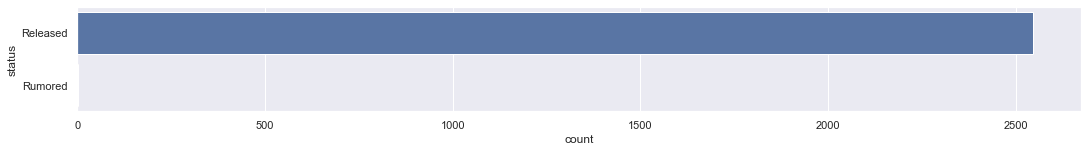

In [175]:
plt.figure(figsize=(15,2), constrained_layout=True)
sns.countplot(y=train.status);

The status of over 99.9% of movies in the train dataset is 'Released'. There are only 3 movies with status 'Rumored'. There is insufficient variation in this feature to be useful in prediction.

# More Feature Extraction and Final Pre-Processing

In [176]:
# drop columns
drop_cols = ['id', 'belongs_to_collection', 'collection_name', 'movies_in_collection', 'genres', 'all_genres', 'homepage',
 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies',
 'all_production_companies', 'production_countries', 'all_production_countries', 'release_date', 'spoken_languages',
 'all_spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'all_Keywords', 'cast', 'all_cast_names',
 'cast_genders_0', 'cast_genders_1', 'cast_genders_2', 'crew', 'all_directors', 'all_exec_producers', 'all_producers',
 'all_screenplay', 'crew_genders_0', 'crew_genders_1', 'crew_genders_2']

for d in datasets:
    d.drop(drop_cols, axis=1, inplace=True)

## Missing Value Imputation

In [177]:
full = pd.concat([train, test, predict], ignore_index=True)
full.isna().sum()[full.isna().sum()>0]
impute_cols = full.isna().sum()[full.isna().sum()>0].index

budget                             2023
runtime                              27
num_genres                           23
num_production_companies            414
num_production_countries            157
year                                  1
quarter                               1
month                                 1
week                                  1
dayofweek                             1
num_spoken_languages                 62
num_Keywords                        669
cast_female_percentage              154
num_cast                             60
num_films_per_top_cast_name          60
crew_female_percentage              378
num_crew                             38
num_films_per_top_director           38
num_films_per_top_exec_producer      38
num_films_per_top_producer           38
num_films_per_top_screenplay         38
dtype: int64

In [178]:
imputer = IterativeImputer(estimator=BayesianRidge(), missing_values=np.nan, add_indicator=False)
train[impute_cols] = imputer.fit_transform(train[impute_cols])
test[impute_cols] = imputer.transform(test[impute_cols])
predict[impute_cols] = imputer.transform(predict[impute_cols])

## Feature Extraction

In [179]:
train.shape, test.shape, predict.shape

((2550, 335), (450, 335), (4398, 335))

In [180]:
for d in datasets:
    d['budget_year_mean_ratio'] = d['budget'] / d.groupby('year')['budget'].transform('mean')
    d['popularity_year_mean_ratio'] = d['popularity'] / d.groupby('year')['popularity'].transform('mean')
    d['runtime_year_mean_ratio'] = d['runtime'] / d.groupby('year')['runtime'].transform('mean')
    d['budget_times_popularity'] = d['budget'] * d['popularity']
    d['budget_runtime_ratio'] = d['budget'] / d['runtime']
    
ohe = ce.OneHotEncoder(cols=['year', 'quarter', 'month', 'week', 'dayofweek'], use_cat_names=True, handle_unknown='value', handle_missing='error')
train = ohe.fit_transform(train)
test = ohe.transform(test)
predict = ohe.transform(predict)

for d in datasets:
    for col in [col for col in d.columns if 'year_' in col]:
        d[col + '_times_budget'] = d[col] * d['budget']
        d[col + '_times_popularity'] = d[col] * d['popularity']

## Numerical Feature Power Transformation

In [181]:
# numerical columns to power transform
transform_cols = ['budget', 'popularity', 'runtime', 'num_production_companies', 'num_production_countries',
                  'num_spoken_languages', 'num_Keywords', 'num_cast', 'num_crew', 'crew_female_percentage']
transform_cols.extend([col for col in train.columns if 'crew_departments_' in col])
transform_cols.extend([col for col in train.columns if 'num_films_per_top_' in col])

power_transformer = PowerTransformer()
train[transform_cols] = power_transformer.fit_transform(train[transform_cols])
test[transform_cols] = power_transformer.transform(test[transform_cols])
predict[transform_cols] = power_transformer.transform(predict[transform_cols])

# Choosing and Training Models

In [182]:
X_train, y_train = train.drop('revenue', axis=1), train.revenue
X_test, y_test = test.drop('revenue', axis=1), test.revenue
X_predict = predict.drop('revenue', axis=1)

In [183]:
# create cross-validation folds to be used to tune hyper-parameters of all models and create out-of-bag predictions
# that the final model of the stack will be tuned on; this way, if we need to later compare the performance of
# individual models, we can do so on the exact same data
cv = KFold(n_splits=10, shuffle=True, random_state=0)

## Level-1 Models

### KNN

In [184]:
# tune k-Nearest Neighbors hyper-parameters
def knn_objective(trial):
    params = {'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
              'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
              'p': trial.suggest_int('p', 1, 2)}
    
    scores = cross_val_score(KNeighborsRegressor(**params), X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

knn_study = optuna.create_study(direction='minimize')
knn_study.optimize(knn_objective, n_trials=100)
joblib.dump(knn_study, 'knn_study.pkl')

knn_study_df = knn_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(knn_study_df)

[I 2020-08-10 22:08:54,998] Finished trial#0 with value: 0.7797907752530507 with parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial#0 with value: 0.7797907752530507.
[I 2020-08-10 22:08:55,716] Finished trial#1 with value: 0.8986471802569378 with parameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 2}. Best is trial#0 with value: 0.7797907752530507.
[I 2020-08-10 22:08:56,417] Finished trial#2 with value: 0.7734886201592686 with parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial#2 with value: 0.7734886201592686.
[I 2020-08-10 22:08:57,108] Finished trial#3 with value: 0.7797907752530507 with parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial#2 with value: 0.7734886201592686.
[I 2020-08-10 22:08:57,818] Finished trial#4 with value: 0.7964675562443727 with parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial#2 with value: 0.7734886201592686.
[I 2020-08-10 22:08:58,562] Finished trial

[I 2020-08-10 22:09:26,490] Finished trial#42 with value: 0.7622017489990794 with parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:09:27,305] Finished trial#43 with value: 0.7632152878341166 with parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:09:28,226] Finished trial#44 with value: 0.7635540209554478 with parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:09:29,118] Finished trial#45 with value: 0.7744848847002168 with parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:09:30,058] Finished trial#46 with value: 0.7632152878341166 with parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:09:30,853] F

[I 2020-08-10 22:09:59,003] Finished trial#84 with value: 0.7622017489990794 with parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:09:59,710] Finished trial#85 with value: 0.7622481689603107 with parameters: {'n_neighbors': 25, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:10:00,388] Finished trial#86 with value: 0.7622778336418907 with parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:10:01,081] Finished trial#87 with value: 0.7632152878341166 with parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:10:01,766] Finished trial#88 with value: 0.7632785534713625 with parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1}. Best is trial#13 with value: 0.7622017489990794.
[I 2020-08-10 22:10:02,457] Fi

['knn_study.pkl']

In [185]:
# best RMSLE score and corresponding hyper-parameters of k-Nearest Neighbors
knn_study.best_value
knn_study.best_params
optuna.visualization.plot_slice(knn_study)

0.7622017489990794

{'n_neighbors': 27, 'weights': 'uniform', 'p': 1}

In [260]:
PT = .02
knn_study_df[knn_study_df.value == knn_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first')
knn_score = knn_study_df[knn_study_df.value == knn_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').iloc[0]['value']
knn_params = knn_study_df[knn_study_df.value == knn_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')[0]

value  n_neighbors  p  weights
13  0.762202           27  1  uniform

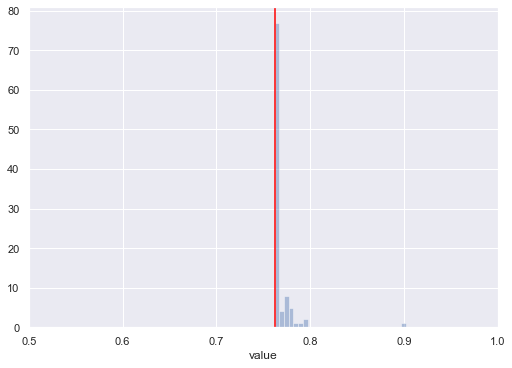

In [226]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.distplot(knn_study_df.value, bins=50, kde=False)
plt.axvline(knn_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.5,1);

### Linear Regression (Elastic Net)

In [188]:
# tune Linear Regression (Elastic Net) hyper-parameters
def en_objective(trial):
    params = {'alpha': trial.suggest_loguniform('alpha', 1e-15, 10),
              'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1)}
    
    scores = cross_val_score(ElasticNet(**params), X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

en_study = optuna.create_study(direction='minimize')
en_study.optimize(en_objective, n_trials=250)
joblib.dump(en_study, 'en_study.pkl')

en_study_df = en_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(en_study_df)

[I 2020-08-10 22:10:17,697] Finished trial#0 with value: 0.6223824822860287 with parameters: {'alpha': 4.3591803576713336e-11, 'l1_ratio': 0.6190711122742523}. Best is trial#0 with value: 0.6223824822860287.
[I 2020-08-10 22:10:24,461] Finished trial#1 with value: 0.6223824892181207 with parameters: {'alpha': 3.919591677999455e-12, 'l1_ratio': 0.10671976086713364}. Best is trial#0 with value: 0.6223824822860287.
[I 2020-08-10 22:10:31,197] Finished trial#2 with value: 0.6223824888569823 with parameters: {'alpha': 4.854937984764094e-12, 'l1_ratio': 0.4741934943446252}. Best is trial#0 with value: 0.6223824822860287.
[I 2020-08-10 22:10:38,072] Finished trial#3 with value: 0.6223787608154698 with parameters: {'alpha': 2.7346062591303326e-08, 'l1_ratio': 0.4257310893552302}. Best is trial#3 with value: 0.6223787608154698.
[I 2020-08-10 22:10:44,870] Finished trial#4 with value: 0.6223824837894941 with parameters: {'alpha': 3.329531829668771e-11, 'l1_ratio': 0.6599024915766692}. Best is tr

[I 2020-08-10 22:13:44,746] Finished trial#39 with value: 0.8058621420799026 with parameters: {'alpha': 1.1152893086414106, 'l1_ratio': 0.1857092619859418}. Best is trial#35 with value: 0.5797857406892568.
[I 2020-08-10 22:13:52,865] Finished trial#40 with value: 0.6223822915497795 with parameters: {'alpha': 1.026776848836241e-09, 'l1_ratio': 0.7849990008206036}. Best is trial#35 with value: 0.5797857406892568.
[I 2020-08-10 22:14:01,060] Finished trial#41 with value: 0.5800752413736385 with parameters: {'alpha': 0.0012402876768587408, 'l1_ratio': 0.8461036898847358}. Best is trial#35 with value: 0.5797857406892568.
[I 2020-08-10 22:14:02,613] Finished trial#42 with value: 0.6312099999969728 with parameters: {'alpha': 0.03677834384218393, 'l1_ratio': 0.9376249504271631}. Best is trial#35 with value: 0.5797857406892568.
[I 2020-08-10 22:14:11,477] Finished trial#43 with value: 0.5844767039978188 with parameters: {'alpha': 0.0006546809955819968, 'l1_ratio': 0.8591500329961279}. Best is t

[I 2020-08-10 22:17:48,959] Finished trial#78 with value: 0.5929734126610329 with parameters: {'alpha': 0.00036163233860612005, 'l1_ratio': 0.7759007065109592}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:17:56,900] Finished trial#79 with value: 0.5797602272409575 with parameters: {'alpha': 0.0016210377804112197, 'l1_ratio': 0.7131380940485621}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:17:57,589] Finished trial#80 with value: 0.6871935126148231 with parameters: {'alpha': 0.11995222258435224, 'l1_ratio': 0.7098680320509716}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:18:04,954] Finished trial#81 with value: 0.5800259498364825 with parameters: {'alpha': 0.0015625795548182228, 'l1_ratio': 0.9140082931696194}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:18:14,557] Finished trial#82 with value: 0.6088964267802588 with parameters: {'alpha': 8.924195176551529e-05, 'l1_ratio': 0.9117518771128025}. Best 

[I 2020-08-10 22:21:47,803] Finished trial#117 with value: 0.6054431139869376 with parameters: {'alpha': 0.00011706623065990592, 'l1_ratio': 0.9739444948011823}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:21:55,861] Finished trial#118 with value: 0.6223820501358698 with parameters: {'alpha': 2.021930280816975e-09, 'l1_ratio': 0.9412670642622231}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:22:04,105] Finished trial#119 with value: 0.6223824863700728 with parameters: {'alpha': 1.4490191986717177e-11, 'l1_ratio': 0.9568031194382406}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:22:13,161] Finished trial#120 with value: 0.580983460230956 with parameters: {'alpha': 0.0009342822639008261, 'l1_ratio': 0.9184425859491562}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:22:20,668] Finished trial#121 with value: 0.5797567956328968 with parameters: {'alpha': 0.0014134196771730901, 'l1_ratio': 0.8995199114027705}

[I 2020-08-10 22:25:51,511] Finished trial#156 with value: 0.6102577148899618 with parameters: {'alpha': 7.749630337677541e-05, 'l1_ratio': 0.91731484865502}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:25:59,955] Finished trial#157 with value: 0.5817782498486391 with parameters: {'alpha': 0.0008702546554104748, 'l1_ratio': 0.8543427159053768}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:26:06,307] Finished trial#158 with value: 0.5902974543991482 with parameters: {'alpha': 0.00036932467662245373, 'l1_ratio': 0.9921890175566079}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:26:10,598] Finished trial#159 with value: 0.584649780542948 with parameters: {'alpha': 0.0031814956250368893, 'l1_ratio': 0.9417745757545746}. Best is trial#66 with value: 0.5797435352125709.
[I 2020-08-10 22:26:20,141] Finished trial#160 with value: 0.6002908306579778 with parameters: {'alpha': 0.00018835358508163734, 'l1_ratio': 0.8907929746966031}. 

[I 2020-08-10 22:29:58,145] Finished trial#195 with value: 0.5797493233993934 with parameters: {'alpha': 0.0015165486978878124, 'l1_ratio': 0.8458935663189188}. Best is trial#191 with value: 0.579742174124812.
[I 2020-08-10 22:30:02,585] Finished trial#196 with value: 0.5948913415027214 with parameters: {'alpha': 0.008890475206309595, 'l1_ratio': 0.8473521741215907}. Best is trial#191 with value: 0.579742174124812.
[I 2020-08-10 22:30:12,163] Finished trial#197 with value: 0.6006086227038571 with parameters: {'alpha': 0.00020596645175043174, 'l1_ratio': 0.7495164673935379}. Best is trial#191 with value: 0.579742174124812.
[I 2020-08-10 22:30:17,229] Finished trial#198 with value: 0.5835378858067235 with parameters: {'alpha': 0.003149122616828679, 'l1_ratio': 0.8137259450692443}. Best is trial#191 with value: 0.579742174124812.
[I 2020-08-10 22:30:26,527] Finished trial#199 with value: 0.5906113777741087 with parameters: {'alpha': 0.000430073013106071, 'l1_ratio': 0.7835384874808449}. B

[I 2020-08-10 22:34:28,814] Finished trial#234 with value: 0.587506583488114 with parameters: {'alpha': 0.004818573648236487, 'l1_ratio': 0.8813413328494839}. Best is trial#211 with value: 0.5797418003124493.
[I 2020-08-10 22:34:36,104] Finished trial#235 with value: 0.5798385647910732 with parameters: {'alpha': 0.0015698504031552304, 'l1_ratio': 0.8569982198229811}. Best is trial#211 with value: 0.5797418003124493.
[I 2020-08-10 22:34:41,896] Finished trial#236 with value: 0.5822965744023821 with parameters: {'alpha': 0.002363241437393499, 'l1_ratio': 0.8560317395272703}. Best is trial#211 with value: 0.5797418003124493.
[I 2020-08-10 22:34:50,813] Finished trial#237 with value: 0.5835520014377887 with parameters: {'alpha': 0.0007308916673031206, 'l1_ratio': 0.8345148082528264}. Best is trial#211 with value: 0.5797418003124493.
[I 2020-08-10 22:34:53,247] Finished trial#238 with value: 0.5853901722031986 with parameters: {'alpha': 0.0037952384127411124, 'l1_ratio': 0.8753533768531073}

['en_study.pkl']

In [189]:
# best RMSLE score and corresponding hyper-parameters of k-Nearest Neighbors
en_study.best_value
en_study.best_params
optuna.visualization.plot_slice(en_study)

0.5797418003124493

{'alpha': 0.001528325761759088, 'l1_ratio': 0.83510792604279}

In [262]:
PT = .02
en_study_df[en_study_df.value == en_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first')
en_score = en_study_df[en_study_df.value == en_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').iloc[0]['value']
en_params = en_study_df[en_study_df.value == en_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')[0]

value     alpha  l1_ratio
214  0.579747  0.001561  0.823846

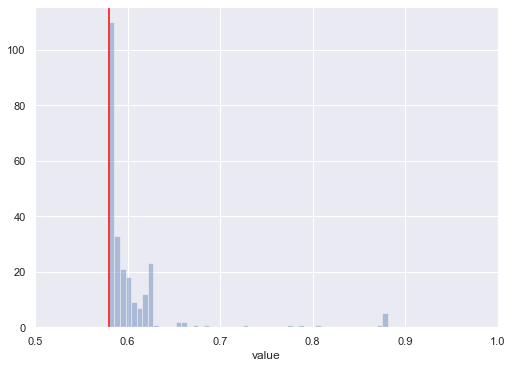

In [228]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.distplot(en_study_df.value, bins=50, kde=False)
plt.axvline(en_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.5,1);

### SVM

In [192]:
# tune Support Vector Machine hyper-parameters
def svr_objective(trial):
    params = {'kernel': trial.suggest_categorical('kernel', ['rbf', 'sigmoid']),
              'gamma': trial.suggest_loguniform('gamma', 1e-10, 100),
              'C': trial.suggest_loguniform('C', 1e-10, 1e5)}
    
    scores = cross_val_score(SVR(**params), X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
   
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

svr_study = optuna.create_study(direction='minimize')
svr_study.optimize(svr_objective, n_trials=250)
joblib.dump(svr_study, 'svr_study.pkl')

svr_study_df = svr_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(svr_study_df)

[I 2020-08-10 22:36:28,732] Finished trial#0 with value: 1.000214030889139 with parameters: {'kernel': 'rbf', 'gamma': 2.4418844287234758, 'C': 117.27826361778357}. Best is trial#0 with value: 1.000214030889139.
[I 2020-08-10 22:36:42,072] Finished trial#1 with value: 0.9836406677304482 with parameters: {'kernel': 'rbf', 'gamma': 1.0821746236920029e-10, 'C': 59.939926958608396}. Best is trial#1 with value: 0.9836406677304482.
[I 2020-08-10 22:36:54,026] Finished trial#2 with value: 6.650948292574962 with parameters: {'kernel': 'sigmoid', 'gamma': 6.576667460798682e-07, 'C': 0.6856208363808758}. Best is trial#1 with value: 0.9836406677304482.
[I 2020-08-10 22:37:06,670] Finished trial#3 with value: 94.20527471251197 with parameters: {'kernel': 'sigmoid', 'gamma': 1.0492912450109362e-09, 'C': 2.897331449624165}. Best is trial#1 with value: 0.9836406677304482.
[I 2020-08-10 22:37:19,091] Finished trial#4 with value: 0.9787374424034596 with parameters: {'kernel': 'rbf', 'gamma': 7.98412931

[I 2020-08-10 22:43:58,040] Finished trial#37 with value: 1.0002140308890248 with parameters: {'kernel': 'rbf', 'gamma': 0.5935208749131297, 'C': 623.8302982546478}. Best is trial#23 with value: 0.9517846129982153.
[I 2020-08-10 22:44:09,731] Finished trial#38 with value: 0.9845317141296065 with parameters: {'kernel': 'rbf', 'gamma': 2.1674810838247763e-08, 'C': 0.3382218774146239}. Best is trial#23 with value: 0.9517846129982153.
[I 2020-08-10 22:44:21,459] Finished trial#39 with value: 1.0008406465227693 with parameters: {'kernel': 'rbf', 'gamma': 5.743458503411454e-07, 'C': 0.0002954339934657717}. Best is trial#23 with value: 0.9517846129982153.
[I 2020-08-10 22:44:34,055] Finished trial#40 with value: 243.02134255527795 with parameters: {'kernel': 'sigmoid', 'gamma': 5.484767629081966e-10, 'C': 6.838113442860523}. Best is trial#23 with value: 0.9517846129982153.
[I 2020-08-10 22:44:45,986] Finished trial#41 with value: 0.9676625378765152 with parameters: {'kernel': 'rbf', 'gamma': 

[I 2020-08-10 22:51:28,124] Finished trial#74 with value: 0.9679750363893874 with parameters: {'kernel': 'rbf', 'gamma': 1.0301020549963337e-09, 'C': 0.55983980617457}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 22:51:40,737] Finished trial#75 with value: 0.9642832263086472 with parameters: {'kernel': 'rbf', 'gamma': 3.069789047116926e-10, 'C': 1.6883591174963617}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 22:51:53,300] Finished trial#76 with value: 0.976563453907941 with parameters: {'kernel': 'rbf', 'gamma': 7.944347786050862e-10, 'C': 7.185037755739287}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 22:52:07,151] Finished trial#77 with value: 0.9998309194129157 with parameters: {'kernel': 'rbf', 'gamma': 1.0112923147092724e-10, 'C': 145.86542776618566}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 22:52:19,407] Finished trial#78 with value: 0.9770937867730489 with parameters: {'kernel': 'rbf', 'gamma': 3.638

[I 2020-08-10 22:59:04,830] Finished trial#111 with value: 0.9593272057608652 with parameters: {'kernel': 'rbf', 'gamma': 3.0418013240038827e-10, 'C': 0.39207229265427473}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 22:59:16,607] Finished trial#112 with value: 0.9447212228954162 with parameters: {'kernel': 'rbf', 'gamma': 1.0542776953517376e-10, 'C': 0.8194549695507868}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 22:59:28,919] Finished trial#113 with value: 0.9654110875129349 with parameters: {'kernel': 'rbf', 'gamma': 1.3045264220568925e-10, 'C': 5.956833095160648}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 22:59:40,917] Finished trial#114 with value: 0.9686748855032623 with parameters: {'kernel': 'rbf', 'gamma': 5.607771360946109e-10, 'C': 1.5120690536557262}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 22:59:53,727] Finished trial#115 with value: 0.9726501370082694 with parameters: {'kernel': 'rbf', 'gam

[I 2020-08-10 23:06:28,332] Finished trial#148 with value: 0.9709648522733235 with parameters: {'kernel': 'rbf', 'gamma': 1.0806564676092028e-10, 'C': 12.84125089527218}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 23:06:40,459] Finished trial#149 with value: 0.9687809602989622 with parameters: {'kernel': 'rbf', 'gamma': 4.1452775983885737e-10, 'C': 2.3794489200005686}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 23:06:52,329] Finished trial#150 with value: 0.9549874064175281 with parameters: {'kernel': 'rbf', 'gamma': 1.8508143326406502e-10, 'C': 1.0275720256783665}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 23:07:03,950] Finished trial#151 with value: 0.953667992704123 with parameters: {'kernel': 'rbf', 'gamma': 1.0831901752645507e-10, 'C': 0.22760209734673398}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 23:07:15,881] Finished trial#152 with value: 0.9568435178993893 with parameters: {'kernel': 'rbf', 'gam

[I 2020-08-10 23:13:51,068] Finished trial#185 with value: 0.9453133689487391 with parameters: {'kernel': 'rbf', 'gamma': 1.0091533286320733e-10, 'C': 0.9985233427016227}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 23:14:03,119] Finished trial#186 with value: 0.9705692323959489 with parameters: {'kernel': 'rbf', 'gamma': 3.325399762230027e-10, 'C': 0.11048651690061848}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 23:14:14,729] Finished trial#187 with value: 0.944755612232901 with parameters: {'kernel': 'rbf', 'gamma': 1.0104293245815864e-10, 'C': 0.5226189174164836}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 23:14:26,389] Finished trial#188 with value: 0.9562852063926183 with parameters: {'kernel': 'rbf', 'gamma': 2.505640129393543e-10, 'C': 0.5701518839665484}. Best is trial#73 with value: 0.9436750846680824.
[I 2020-08-10 23:14:38,291] Finished trial#189 with value: 0.9554388008431128 with parameters: {'kernel': 'rbf', 'gamm

[I 2020-08-10 23:26:17,341] Finished trial#222 with value: 0.9514801971241847 with parameters: {'kernel': 'rbf', 'gamma': 1.6166187058763515e-10, 'C': 0.6015677765487603}. Best is trial#208 with value: 0.943657720814548.
[I 2020-08-10 23:26:28,949] Finished trial#223 with value: 0.9517501747995977 with parameters: {'kernel': 'rbf', 'gamma': 1.0876349973131393e-10, 'C': 0.2762821327250796}. Best is trial#208 with value: 0.943657720814548.
[I 2020-08-10 23:26:40,641] Finished trial#224 with value: 0.9543774273991341 with parameters: {'kernel': 'rbf', 'gamma': 1.6700111814623075e-10, 'C': 1.079460817399514}. Best is trial#208 with value: 0.943657720814548.
[I 2020-08-10 23:26:52,414] Finished trial#225 with value: 0.9566894400320822 with parameters: {'kernel': 'rbf', 'gamma': 2.556415826802292e-10, 'C': 0.5051436363822986}. Best is trial#208 with value: 0.943657720814548.
[I 2020-08-10 23:27:03,941] Finished trial#226 with value: 0.9521253482224039 with parameters: {'kernel': 'rbf', 'gamm

['svr_study.pkl']

In [193]:
# best RMSLE score and corresponding hyper-parameters of Support Vector Machine
svr_study.best_value
svr_study.best_params
optuna.visualization.plot_slice(svr_study)

0.943657720814548

{'kernel': 'rbf', 'gamma': 1.0011810083764458e-10, 'C': 0.7861956191236356}

In [263]:
PT = .02
svr_study_df[svr_study_df.value == svr_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first')
svr_score = svr_study_df[svr_study_df.value == svr_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').iloc[0]['value']
svr_params = svr_study_df[svr_study_df.value == svr_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')[0]

value         C         gamma kernel
193  0.94405  0.846315  1.009954e-10    rbf

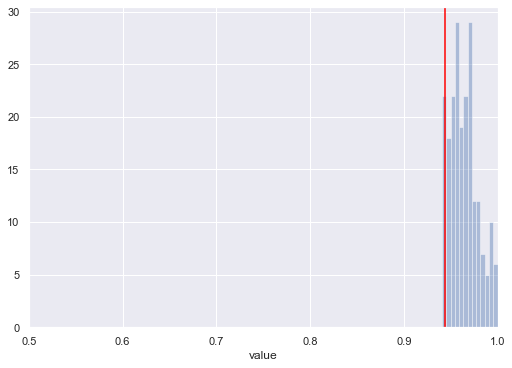

In [201]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.distplot(svr_study_df.value, bins=np.linspace(.55,1,100), kde=False)
plt.axvline(svr_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.5,1);

### Random Forest

In [202]:
# tune Random Forest hyper-parameters
def rf_objective(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 1, 200),
              'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 25, 1250),
              'min_samples_split': trial.suggest_int('min_samples_split', 2, 500),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 250),
              'n_estimators': 50,                                                     # low value to make it run faster
              'max_samples': trial.suggest_uniform('max_samples', 0, 1),
              'max_features': trial.suggest_uniform('max_features', 0, 1)}
    
    scores = cross_val_score(RandomForestRegressor(**params), X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
   
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(rf_objective, n_trials=250)
joblib.dump(rf_study, 'rf_study.pkl')

rf_study_df = rf_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(rf_study_df)

[I 2020-08-11 20:50:05,358] Finished trial#0 with value: 0.6725590066439602 with parameters: {'max_depth': 187, 'max_leaf_nodes': 1084, 'min_samples_split': 6, 'min_samples_leaf': 135, 'max_samples': 0.9025762975235314, 'max_features': 0.4830094262237776}. Best is trial#0 with value: 0.6725590066439602.
[I 2020-08-11 20:50:07,191] Finished trial#1 with value: 0.7331347008720975 with parameters: {'max_depth': 144, 'max_leaf_nodes': 1037, 'min_samples_split': 482, 'min_samples_leaf': 129, 'max_samples': 0.5068565474152574, 'max_features': 0.9170855774913609}. Best is trial#0 with value: 0.6725590066439602.
[I 2020-08-11 20:50:09,372] Finished trial#2 with value: 0.6629676448831887 with parameters: {'max_depth': 146, 'max_leaf_nodes': 69, 'min_samples_split': 299, 'min_samples_leaf': 48, 'max_samples': 0.9062264435132763, 'max_features': 0.41455609385498493}. Best is trial#2 with value: 0.6629676448831887.
[I 2020-08-11 20:50:12,525] Finished trial#3 with value: 0.7204126333162415 with pa

[I 2020-08-11 20:50:53,335] Finished trial#26 with value: 0.6139597468420595 with parameters: {'max_depth': 108, 'max_leaf_nodes': 157, 'min_samples_split': 33, 'min_samples_leaf': 7, 'max_samples': 0.8252815272221996, 'max_features': 0.1414732937056908}. Best is trial#24 with value: 0.6017522961007462.
[I 2020-08-11 20:50:55,474] Finished trial#27 with value: 0.601619017502614 with parameters: {'max_depth': 105, 'max_leaf_nodes': 176, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_samples': 0.85102340609878, 'max_features': 0.14540201993692214}. Best is trial#27 with value: 0.601619017502614.
[I 2020-08-11 20:50:57,019] Finished trial#28 with value: 0.693402912830027 with parameters: {'max_depth': 82, 'max_leaf_nodes': 422, 'min_samples_split': 153, 'min_samples_leaf': 169, 'max_samples': 0.8571291298635421, 'max_features': 0.3103659902061149}. Best is trial#27 with value: 0.601619017502614.
[I 2020-08-11 20:50:57,997] Finished trial#29 with value: 0.6861397816559485 with parame

[I 2020-08-11 20:51:33,393] Finished trial#52 with value: 0.6030041056031216 with parameters: {'max_depth': 119, 'max_leaf_nodes': 243, 'min_samples_split': 23, 'min_samples_leaf': 1, 'max_samples': 0.8504262787123646, 'max_features': 0.12297458205110914}. Best is trial#27 with value: 0.601619017502614.
[I 2020-08-11 20:51:35,025] Finished trial#53 with value: 0.6120348565989095 with parameters: {'max_depth': 122, 'max_leaf_nodes': 354, 'min_samples_split': 45, 'min_samples_leaf': 1, 'max_samples': 0.8604282183829247, 'max_features': 0.11991662705111669}. Best is trial#27 with value: 0.601619017502614.
[I 2020-08-11 20:51:36,489] Finished trial#54 with value: 0.6341218489147734 with parameters: {'max_depth': 105, 'max_leaf_nodes': 62, 'min_samples_split': 101, 'min_samples_leaf': 26, 'max_samples': 0.7810372505779213, 'max_features': 0.21381109301365336}. Best is trial#27 with value: 0.601619017502614.
[I 2020-08-11 20:51:37,451] Finished trial#55 with value: 0.6644984317852257 with pa

[I 2020-08-11 20:52:25,414] Finished trial#78 with value: 0.6017379577601748 with parameters: {'max_depth': 58, 'max_leaf_nodes': 103, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_samples': 0.797769518896492, 'max_features': 0.3487794198014347}. Best is trial#71 with value: 0.5955585879469171.
[I 2020-08-11 20:52:27,802] Finished trial#79 with value: 0.6178144219416105 with parameters: {'max_depth': 43, 'max_leaf_nodes': 72, 'min_samples_split': 36, 'min_samples_leaf': 22, 'max_samples': 0.7520822274184434, 'max_features': 0.35514840364849054}. Best is trial#71 with value: 0.5955585879469171.
[I 2020-08-11 20:52:29,609] Finished trial#80 with value: 0.6273651352525279 with parameters: {'max_depth': 107, 'max_leaf_nodes': 100, 'min_samples_split': 88, 'min_samples_leaf': 14, 'max_samples': 0.6913241960492429, 'max_features': 0.2550537846315024}. Best is trial#71 with value: 0.5955585879469171.
[I 2020-08-11 20:52:32,803] Finished trial#81 with value: 0.5988317080199905 with para

[I 2020-08-11 20:53:28,240] Finished trial#104 with value: 0.6042159015650991 with parameters: {'max_depth': 56, 'max_leaf_nodes': 97, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.732985702318684, 'max_features': 0.203693483166018}. Best is trial#71 with value: 0.5955585879469171.
[I 2020-08-11 20:53:29,359] Finished trial#105 with value: 0.7128150682870831 with parameters: {'max_depth': 2, 'max_leaf_nodes': 197, 'min_samples_split': 226, 'min_samples_leaf': 6, 'max_samples': 0.7878471796822483, 'max_features': 0.3284628916327556}. Best is trial#71 with value: 0.5955585879469171.
[I 2020-08-11 20:53:31,023] Finished trial#106 with value: 0.6202945997606727 with parameters: {'max_depth': 74, 'max_leaf_nodes': 166, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_samples': 0.8238985821838017, 'max_features': 0.1737469260538875}. Best is trial#71 with value: 0.5955585879469171.
[I 2020-08-11 20:53:32,598] Finished trial#107 with value: 0.6188397387615437 with param

[I 2020-08-11 20:54:25,805] Finished trial#130 with value: 0.6301963367765944 with parameters: {'max_depth': 36, 'max_leaf_nodes': 193, 'min_samples_split': 27, 'min_samples_leaf': 26, 'max_samples': 0.8163610486775423, 'max_features': 0.14771133281033577}. Best is trial#108 with value: 0.5934019640547674.
[I 2020-08-11 20:54:28,793] Finished trial#131 with value: 0.5967483925716973 with parameters: {'max_depth': 63, 'max_leaf_nodes': 247, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.847938038227039, 'max_features': 0.1673406160527412}. Best is trial#108 with value: 0.5934019640547674.
[I 2020-08-11 20:54:31,088] Finished trial#132 with value: 0.604032344919097 with parameters: {'max_depth': 52, 'max_leaf_nodes': 250, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.8507578654340617, 'max_features': 0.165313516426785}. Best is trial#108 with value: 0.5934019640547674.
[I 2020-08-11 20:54:32,936] Finished trial#133 with value: 0.617502528685614 with pa

[I 2020-08-11 20:55:42,443] Finished trial#156 with value: 0.603243060343728 with parameters: {'max_depth': 51, 'max_leaf_nodes': 205, 'min_samples_split': 21, 'min_samples_leaf': 6, 'max_samples': 0.8121684114787536, 'max_features': 0.23726799194845555}. Best is trial#108 with value: 0.5934019640547674.
[I 2020-08-11 20:55:44,729] Finished trial#157 with value: 0.6079533870036724 with parameters: {'max_depth': 85, 'max_leaf_nodes': 595, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_samples': 0.8479830466773165, 'max_features': 0.20971508723488172}. Best is trial#108 with value: 0.5934019640547674.
[I 2020-08-11 20:55:47,464] Finished trial#158 with value: 0.6048527817246678 with parameters: {'max_depth': 70, 'max_leaf_nodes': 146, 'min_samples_split': 33, 'min_samples_leaf': 5, 'max_samples': 0.891015735872322, 'max_features': 0.2683929650540589}. Best is trial#108 with value: 0.5934019640547674.
[I 2020-08-11 20:55:52,834] Finished trial#159 with value: 0.5948647447874671 wit

[I 2020-08-11 20:57:13,212] Finished trial#182 with value: 0.5958568124272646 with parameters: {'max_depth': 46, 'max_leaf_nodes': 273, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_samples': 0.7718259880006252, 'max_features': 0.29677035922718964}. Best is trial#181 with value: 0.5928042268418084.
[I 2020-08-11 20:57:16,082] Finished trial#183 with value: 0.6026462172797876 with parameters: {'max_depth': 43, 'max_leaf_nodes': 281, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_samples': 0.7729501363760266, 'max_features': 0.23242153221739895}. Best is trial#181 with value: 0.5928042268418084.
[I 2020-08-11 20:57:18,695] Finished trial#184 with value: 0.6079651319378552 with parameters: {'max_depth': 49, 'max_leaf_nodes': 310, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_samples': 0.8070769500780693, 'max_features': 0.2725427112832979}. Best is trial#181 with value: 0.5928042268418084.
[I 2020-08-11 20:57:23,303] Finished trial#185 with value: 0.5947994383767592 wi

[I 2020-08-11 20:58:44,714] Finished trial#208 with value: 0.5997596455512175 with parameters: {'max_depth': 55, 'max_leaf_nodes': 295, 'min_samples_split': 38, 'min_samples_leaf': 1, 'max_samples': 0.8067876877446212, 'max_features': 0.32410174634291433}. Best is trial#181 with value: 0.5928042268418084.
[I 2020-08-11 20:58:48,416] Finished trial#209 with value: 0.5990166237232531 with parameters: {'max_depth': 63, 'max_leaf_nodes': 333, 'min_samples_split': 23, 'min_samples_leaf': 1, 'max_samples': 0.7406260103585657, 'max_features': 0.2868934078679187}. Best is trial#181 with value: 0.5928042268418084.
[I 2020-08-11 20:58:51,365] Finished trial#210 with value: 0.6074399611351753 with parameters: {'max_depth': 52, 'max_leaf_nodes': 399, 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_samples': 0.8333232942949681, 'max_features': 0.3124175623933818}. Best is trial#181 with value: 0.5928042268418084.
[I 2020-08-11 20:58:55,156] Finished trial#211 with value: 0.5939062537950504 wit

[I 2020-08-11 21:00:24,057] Finished trial#234 with value: 0.6025677226910482 with parameters: {'max_depth': 50, 'max_leaf_nodes': 410, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_samples': 0.7728607221034428, 'max_features': 0.3474949757933943}. Best is trial#232 with value: 0.5913654384942028.
[I 2020-08-11 21:00:30,552] Finished trial#235 with value: 0.5948105411573565 with parameters: {'max_depth': 45, 'max_leaf_nodes': 393, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.7142350093125125, 'max_features': 0.3095311909012031}. Best is trial#232 with value: 0.5913654384942028.
[I 2020-08-11 21:00:33,896] Finished trial#236 with value: 0.6011680807012177 with parameters: {'max_depth': 40, 'max_leaf_nodes': 376, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_samples': 0.7164239855970349, 'max_features': 0.312362765781471}. Best is trial#232 with value: 0.5913654384942028.
[I 2020-08-11 21:00:39,645] Finished trial#237 with value: 0.5941026128535263 with pa

['rf_study.pkl']

In [203]:
# best RMSLE score and corresponding hyper-parameters of Random Forest
rf_study.best_value
rf_study.best_params
optuna.visualization.plot_slice(rf_study)

0.5913654384942028

{'max_depth': 57,
 'max_leaf_nodes': 379,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 0.765012291842109,
 'max_features': 0.3156645127615547}

In [264]:
PT = .02
rf_study_df[rf_study_df.value == rf_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first')
rf_score = rf_study_df[rf_study_df.value == rf_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').iloc[0]['value']
rf_params = rf_study_df[rf_study_df.value == rf_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')[0]

value  max_depth  max_features  max_leaf_nodes  max_samples  \
222  0.592866         64      0.253593             249     0.792293   

     min_samples_leaf  min_samples_split  
222                 1                  2

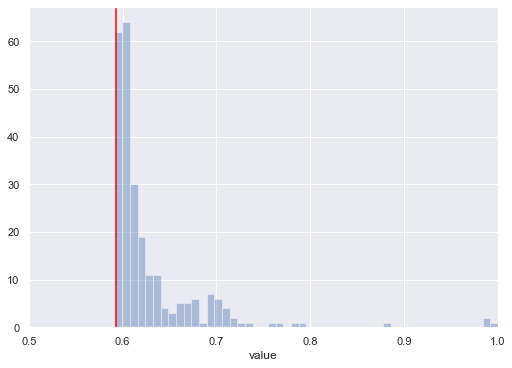

In [229]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.distplot(rf_study_df.value, bins=50, kde=False)
plt.axvline(rf_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.5,1);

In [ ]:
# tune n-estimators
rf_params['n_estimators'] = 1000
scores = cross_val_score(RandomForestRegressor(**rf_params), X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
rf_score = np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score
rf_score

### XGBoost

In [206]:
# using early stopping, find a combination of learning_rate and n_estimators that will allow us to tune XGBoost in
# a relatively short amount of time; after the optimal hyper-parameters are determined, learning_rate will be
# decreased and n_estimators will be increased to further improve XGBoost's performance
XGBRegressor(learning_rate=.2, n_estimators=1000).fit(X_train, y_train, eval_set=[(X_test, y_test)],
                                                      eval_metric='rmse', early_stopping_rounds=50)

[0]	validation_0-rmse:0.94413
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.84517
[2]	validation_0-rmse:0.77888
[3]	validation_0-rmse:0.73238
[4]	validation_0-rmse:0.70129
[5]	validation_0-rmse:0.67955
[6]	validation_0-rmse:0.66394
[7]	validation_0-rmse:0.65479
[8]	validation_0-rmse:0.64263
[9]	validation_0-rmse:0.63685
[10]	validation_0-rmse:0.63385
[11]	validation_0-rmse:0.62963
[12]	validation_0-rmse:0.62815
[13]	validation_0-rmse:0.62332
[14]	validation_0-rmse:0.62315
[15]	validation_0-rmse:0.62164
[16]	validation_0-rmse:0.62120
[17]	validation_0-rmse:0.62188
[18]	validation_0-rmse:0.62113
[19]	validation_0-rmse:0.62014
[20]	validation_0-rmse:0.62101
[21]	validation_0-rmse:0.61935
[22]	validation_0-rmse:0.61811
[23]	validation_0-rmse:0.61878
[24]	validation_0-rmse:0.61867
[25]	validation_0-rmse:0.61970
[26]	validation_0-rmse:0.62003
[27]	validation_0-rmse:0.62020
[28]	validation_0-rmse:0.61958
[29]	validation_0-rmse:0.61967
[30]	validation

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [207]:
# tune XGBoost hyper-parameters
def xgb_objective(trial):
    params = {"learning_rate": .2,
              'n_estimators': 161,
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              "subsample": trial.suggest_uniform("subsample", 0, 1),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
              'gamma': trial.suggest_uniform('gamma', 1e-15, 10),
              "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0, 1),
              'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0, 1),
              'colsample_bynode': trial.suggest_uniform('colsample_bynode', 0, 1),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-15, 10),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-15, 10)}
    
    scores = cross_val_score(XGBRegressor(**params), X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=250)
joblib.dump(xgb_study, 'xgb_study.pkl')

xgb_study_df = xgb_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(xgb_study_df)

[I 2020-08-11 21:01:42,925] Finished trial#0 with value: 0.6066685493534897 with parameters: {'max_depth': 16, 'subsample': 0.9804423886246827, 'min_child_weight': 99, 'gamma': 1.3430845731784644, 'colsample_bytree': 0.17021365659412502, 'colsample_bylevel': 0.8286048351504451, 'colsample_bynode': 0.1105372001768613, 'reg_alpha': 5.5994611143544304e-14, 'reg_lambda': 1.6985206285106667}. Best is trial#0 with value: 0.6066685493534897.
[I 2020-08-11 21:01:59,204] Finished trial#1 with value: 0.6207932027160344 with parameters: {'max_depth': 22, 'subsample': 0.6569434418149436, 'min_child_weight': 51, 'gamma': 8.77334066179394, 'colsample_bytree': 0.4322733603053087, 'colsample_bylevel': 0.4420154688559368, 'colsample_bynode': 0.8338895301352368, 'reg_alpha': 7.141057511810073e-13, 'reg_lambda': 0.00011579364730288998}. Best is trial#0 with value: 0.6066685493534897.
[I 2020-08-11 21:02:04,835] Finished trial#2 with value: 0.6528394059711 with parameters: {'max_depth': 27, 'subsample': 0

[I 2020-08-11 21:04:20,850] Finished trial#18 with value: 0.6069171486291708 with parameters: {'max_depth': 30, 'subsample': 0.5920866749939832, 'min_child_weight': 67, 'gamma': 3.3066135404608303, 'colsample_bytree': 0.7159704273176176, 'colsample_bylevel': 0.31263057647903225, 'colsample_bynode': 0.19112614280582213, 'reg_alpha': 7.447834450176223e-13, 'reg_lambda': 1.4339429619098993e-05}. Best is trial#14 with value: 0.5958037099679717.
[I 2020-08-11 21:04:24,000] Finished trial#19 with value: 0.6675693673422861 with parameters: {'max_depth': 6, 'subsample': 0.40451293165660995, 'min_child_weight': 14, 'gamma': 6.213679085077106, 'colsample_bytree': 0.9018481428887644, 'colsample_bylevel': 0.011400408649896998, 'colsample_bynode': 0.4139820871643606, 'reg_alpha': 6.818259976376195e-14, 'reg_lambda': 1.4106488851501715e-07}. Best is trial#14 with value: 0.5958037099679717.
[I 2020-08-11 21:04:29,422] Finished trial#20 with value: 0.6075504838275547 with parameters: {'max_depth': 1, 

[I 2020-08-11 21:07:15,331] Finished trial#36 with value: 0.6067299433268288 with parameters: {'max_depth': 22, 'subsample': 0.696564012562514, 'min_child_weight': 86, 'gamma': 1.4311997842629112, 'colsample_bytree': 0.37291532360651836, 'colsample_bylevel': 0.9125185419061514, 'colsample_bynode': 0.054896601623701885, 'reg_alpha': 4.269471409820749e-09, 'reg_lambda': 9.565371349708544e-05}. Best is trial#29 with value: 0.5878965122386918.
[I 2020-08-11 21:07:19,490] Finished trial#37 with value: 0.6071788260274342 with parameters: {'max_depth': 17, 'subsample': 0.9178090277403345, 'min_child_weight': 147, 'gamma': 0.7890276682247845, 'colsample_bytree': 0.154541068690217, 'colsample_bylevel': 0.8220254375645957, 'colsample_bynode': 0.1667514779118482, 'reg_alpha': 1.5480016966586113e-05, 'reg_lambda': 0.9677310681553926}. Best is trial#29 with value: 0.5878965122386918.
[I 2020-08-11 21:07:25,491] Finished trial#38 with value: 0.594137301210951 with parameters: {'max_depth': 24, 'subs

[I 2020-08-11 21:10:01,256] Finished trial#54 with value: 0.5963140143016364 with parameters: {'max_depth': 15, 'subsample': 0.8170845134077753, 'min_child_weight': 9, 'gamma': 1.17764155697366, 'colsample_bytree': 0.547558878146994, 'colsample_bylevel': 0.7504949411274988, 'colsample_bynode': 0.1590982098253841, 'reg_alpha': 0.000796716349466129, 'reg_lambda': 2.557859826154523e-05}. Best is trial#29 with value: 0.5878965122386918.
[I 2020-08-11 21:10:34,342] Finished trial#55 with value: 0.5903790818890216 with parameters: {'max_depth': 20, 'subsample': 0.8592798764030257, 'min_child_weight': 52, 'gamma': 2.053030725568988, 'colsample_bytree': 0.7767927069080098, 'colsample_bylevel': 0.959210935325397, 'colsample_bynode': 0.5466042016710527, 'reg_alpha': 1.5078935648792375e-10, 'reg_lambda': 0.0007036441239836414}. Best is trial#29 with value: 0.5878965122386918.
[I 2020-08-11 21:11:14,733] Finished trial#56 with value: 0.5933076216848119 with parameters: {'max_depth': 20, 'subsample

[I 2020-08-11 21:21:52,143] Finished trial#72 with value: 0.5997168182428708 with parameters: {'max_depth': 20, 'subsample': 0.5456584349562883, 'min_child_weight': 46, 'gamma': 4.447511828060999, 'colsample_bytree': 0.9709303718820312, 'colsample_bylevel': 0.9606669105194732, 'colsample_bynode': 0.792458380500771, 'reg_alpha': 1.3742683873213605e-11, 'reg_lambda': 0.05704962685545832}. Best is trial#29 with value: 0.5878965122386918.
[I 2020-08-11 21:22:20,970] Finished trial#73 with value: 0.6127102976775597 with parameters: {'max_depth': 19, 'subsample': 0.7649016985957425, 'min_child_weight': 236, 'gamma': 3.4860085692587472, 'colsample_bytree': 0.6869244639390241, 'colsample_bylevel': 0.9977425102300157, 'colsample_bynode': 0.8843392720921313, 'reg_alpha': 1.4166716369712204e-09, 'reg_lambda': 0.0031158688785116718}. Best is trial#29 with value: 0.5878965122386918.
[I 2020-08-11 21:23:55,858] Finished trial#74 with value: 0.6038272975472496 with parameters: {'max_depth': 18, 'subs

[I 2020-08-11 21:32:02,332] Finished trial#90 with value: 0.5906303928521702 with parameters: {'max_depth': 19, 'subsample': 0.9794647068970862, 'min_child_weight': 92, 'gamma': 1.168907484846777, 'colsample_bytree': 0.6276561514462671, 'colsample_bylevel': 0.8153516965234007, 'colsample_bynode': 0.9131145792924793, 'reg_alpha': 0.9455643018776797, 'reg_lambda': 1.7502121353425616e-06}. Best is trial#86 with value: 0.5867632539745038.
[I 2020-08-11 21:32:34,243] Finished trial#91 with value: 0.5925930020484947 with parameters: {'max_depth': 15, 'subsample': 0.7674316878361909, 'min_child_weight': 58, 'gamma': 2.432581618682722, 'colsample_bytree': 0.6664208282566405, 'colsample_bylevel': 0.6422706450138391, 'colsample_bynode': 0.8161738460364114, 'reg_alpha': 0.002889494941597782, 'reg_lambda': 1.2304034377430964e-05}. Best is trial#86 with value: 0.5867632539745038.
[I 2020-08-11 21:33:04,598] Finished trial#92 with value: 0.5972665889771354 with parameters: {'max_depth': 16, 'subsamp

[I 2020-08-11 21:44:00,181] Finished trial#108 with value: 0.5860953504335231 with parameters: {'max_depth': 22, 'subsample': 0.946548288550781, 'min_child_weight': 50, 'gamma': 1.9195043049324894, 'colsample_bytree': 0.8002180996190598, 'colsample_bylevel': 0.7639635606926631, 'colsample_bynode': 0.8613542241135506, 'reg_alpha': 1.8161190787861003, 'reg_lambda': 8.289709125281332e-08}. Best is trial#107 with value: 0.5849679610349137.
[I 2020-08-11 21:44:52,122] Finished trial#109 with value: 0.5929759143168093 with parameters: {'max_depth': 23, 'subsample': 0.9898229948107431, 'min_child_weight': 48, 'gamma': 0.1545955134803123, 'colsample_bytree': 0.7939973712753375, 'colsample_bylevel': 0.7666714504792171, 'colsample_bynode': 0.7499399585542721, 'reg_alpha': 1.7062917674084, 'reg_lambda': 6.72266019295127e-08}. Best is trial#107 with value: 0.5849679610349137.
[I 2020-08-11 21:45:46,016] Finished trial#110 with value: 0.5894335429515688 with parameters: {'max_depth': 24, 'subsample

[I 2020-08-11 22:04:47,700] Finished trial#126 with value: 0.5881770568474007 with parameters: {'max_depth': 22, 'subsample': 0.9809429278049292, 'min_child_weight': 68, 'gamma': 1.8997139365555609, 'colsample_bytree': 0.8195021325629436, 'colsample_bylevel': 0.7921338252268664, 'colsample_bynode': 0.9189862840704813, 'reg_alpha': 0.08460340394523787, 'reg_lambda': 1.3939781063888539e-12}. Best is trial#119 with value: 0.5845143251645377.
[I 2020-08-11 22:06:09,143] Finished trial#127 with value: 0.5863707208351645 with parameters: {'max_depth': 21, 'subsample': 0.9921250910279773, 'min_child_weight': 64, 'gamma': 1.9042431330337724, 'colsample_bytree': 0.8398838859894184, 'colsample_bylevel': 0.79432854016882, 'colsample_bynode': 0.9610845782433747, 'reg_alpha': 0.06850297178504383, 'reg_lambda': 1.9002618860460224e-13}. Best is trial#119 with value: 0.5845143251645377.
[I 2020-08-11 22:07:34,973] Finished trial#128 with value: 0.5918101489540449 with parameters: {'max_depth': 20, 'su

[I 2020-08-11 22:23:38,155] Finished trial#144 with value: 0.6228501923306272 with parameters: {'max_depth': 22, 'subsample': 0.2002738377146816, 'min_child_weight': 64, 'gamma': 0.6436993095420189, 'colsample_bytree': 0.3878380073582734, 'colsample_bylevel': 0.7186820772343412, 'colsample_bynode': 0.942286238644909, 'reg_alpha': 0.48491430526642837, 'reg_lambda': 5.956382522760979e-13}. Best is trial#119 with value: 0.5845143251645377.
[I 2020-08-11 22:23:56,418] Finished trial#145 with value: 0.6072222600980511 with parameters: {'max_depth': 19, 'subsample': 0.31000452535383405, 'min_child_weight': 72, 'gamma': 1.968111642618956, 'colsample_bytree': 0.8446498588637408, 'colsample_bylevel': 0.6564799683477711, 'colsample_bynode': 0.840228594743028, 'reg_alpha': 2.0278593621859144, 'reg_lambda': 1.0871695282506414e-11}. Best is trial#119 with value: 0.5845143251645377.
[I 2020-08-11 22:25:07,330] Finished trial#146 with value: 0.5934456960101312 with parameters: {'max_depth': 20, 'subs

[I 2020-08-11 22:40:57,981] Finished trial#162 with value: 0.5912316723748572 with parameters: {'max_depth': 23, 'subsample': 0.9459566060244794, 'min_child_weight': 56, 'gamma': 1.6174204747790237, 'colsample_bytree': 0.7785406137452638, 'colsample_bylevel': 0.760194077784871, 'colsample_bynode': 0.9333317975714838, 'reg_alpha': 3.051349416771545, 'reg_lambda': 2.598034703187743e-12}. Best is trial#119 with value: 0.5845143251645377.
[I 2020-08-11 22:45:17,025] Finished trial#163 with value: 0.591169381362248 with parameters: {'max_depth': 22, 'subsample': 0.9226207415836956, 'min_child_weight': 46, 'gamma': 1.9747670550718226, 'colsample_bytree': 0.430261792179766, 'colsample_bylevel': 0.7907812667696043, 'colsample_bynode': 0.8997142840171282, 'reg_alpha': 0.3995533835063888, 'reg_lambda': 7.27319970783539e-12}. Best is trial#119 with value: 0.5845143251645377.
[I 2020-08-11 22:45:55,025] Finished trial#164 with value: 0.5905825163503525 with parameters: {'max_depth': 22, 'subsample

[I 2020-08-11 23:25:21,431] Finished trial#180 with value: 0.5853578992506248 with parameters: {'max_depth': 23, 'subsample': 0.9978479337122432, 'min_child_weight': 53, 'gamma': 2.4238951147182064, 'colsample_bytree': 0.8457556991308868, 'colsample_bylevel': 0.7449882744630985, 'colsample_bynode': 0.9209113779336416, 'reg_alpha': 0.05610903007984152, 'reg_lambda': 5.247872772615856e-08}. Best is trial#119 with value: 0.5845143251645377.
[I 2020-08-11 23:26:00,938] Finished trial#181 with value: 0.58976142492991 with parameters: {'max_depth': 23, 'subsample': 0.9998025417210592, 'min_child_weight': 55, 'gamma': 2.4205009128374244, 'colsample_bytree': 0.8457302267157614, 'colsample_bylevel': 0.7476415862301715, 'colsample_bynode': 0.955191190587149, 'reg_alpha': 0.055176158199581785, 'reg_lambda': 9.224660327357474e-09}. Best is trial#119 with value: 0.5845143251645377.
[I 2020-08-11 23:30:32,131] Finished trial#182 with value: 0.591042395052305 with parameters: {'max_depth': 21, 'subsa

[I 2020-08-11 23:58:21,243] Finished trial#198 with value: 0.5893696674657019 with parameters: {'max_depth': 24, 'subsample': 0.9833865407253122, 'min_child_weight': 32, 'gamma': 2.6864950427246987, 'colsample_bytree': 0.884769741323565, 'colsample_bylevel': 0.6326330471562558, 'colsample_bynode': 0.804410079852892, 'reg_alpha': 0.1509874712350133, 'reg_lambda': 6.386330957221638e-08}. Best is trial#183 with value: 0.5837365690508243.
[I 2020-08-11 23:59:04,567] Finished trial#199 with value: 0.5887586554889704 with parameters: {'max_depth': 25, 'subsample': 0.930645535340395, 'min_child_weight': 46, 'gamma': 2.8949880100680043, 'colsample_bytree': 0.794153540256667, 'colsample_bylevel': 0.7126201758496906, 'colsample_bynode': 0.7825682858179445, 'reg_alpha': 0.4555172596406031, 'reg_lambda': 1.7040889028490219e-06}. Best is trial#183 with value: 0.5837365690508243.
[I 2020-08-11 23:59:48,155] Finished trial#200 with value: 0.5877860751742069 with parameters: {'max_depth': 24, 'subsamp

[I 2020-08-12 00:10:52,859] Finished trial#216 with value: 0.5856997906582351 with parameters: {'max_depth': 24, 'subsample': 0.9655352714243958, 'min_child_weight': 48, 'gamma': 1.9809504405661946, 'colsample_bytree': 0.7159720500751378, 'colsample_bylevel': 0.6530229099192641, 'colsample_bynode': 0.8932923947438267, 'reg_alpha': 0.027613242955618744, 'reg_lambda': 4.678559544113712e-07}. Best is trial#183 with value: 0.5837365690508243.
[I 2020-08-12 00:11:29,809] Finished trial#217 with value: 0.5868354797483251 with parameters: {'max_depth': 24, 'subsample': 0.9977419569395031, 'min_child_weight': 43, 'gamma': 2.141637286992748, 'colsample_bytree': 0.733903678837396, 'colsample_bylevel': 0.6212029734626539, 'colsample_bynode': 0.7882540488045205, 'reg_alpha': 0.01272698209921046, 'reg_lambda': 1.4809282925768494e-06}. Best is trial#183 with value: 0.5837365690508243.
[I 2020-08-12 00:12:10,746] Finished trial#218 with value: 0.5886789483391672 with parameters: {'max_depth': 27, 'su

[I 2020-08-12 00:24:06,896] Finished trial#234 with value: 0.5894504317002138 with parameters: {'max_depth': 21, 'subsample': 0.9620811066317784, 'min_child_weight': 49, 'gamma': 2.331442066544559, 'colsample_bytree': 0.757712802112105, 'colsample_bylevel': 0.6842296341323247, 'colsample_bynode': 0.9966740199578212, 'reg_alpha': 0.015302804014691885, 'reg_lambda': 3.934496255535217e-14}. Best is trial#183 with value: 0.5837365690508243.
[I 2020-08-12 00:25:01,253] Finished trial#235 with value: 0.5847330105858634 with parameters: {'max_depth': 23, 'subsample': 0.99980543063657, 'min_child_weight': 41, 'gamma': 2.8625054690110865, 'colsample_bytree': 0.8201286090544234, 'colsample_bylevel': 0.6394765050449848, 'colsample_bynode': 0.9314064633934164, 'reg_alpha': 0.04708372188227817, 'reg_lambda': 9.479455381058761e-14}. Best is trial#183 with value: 0.5837365690508243.
[I 2020-08-12 00:26:12,656] Finished trial#236 with value: 0.5891219745087862 with parameters: {'max_depth': 22, 'subsa

['xgb_study.pkl']

In [208]:
# best RMSLE score and corresponding hyper-parameters of XGBoost
xgb_study.best_value
xgb_study.best_params
optuna.visualization.plot_slice(xgb_study)

0.5837365690508243

{'max_depth': 24,
 'subsample': 0.9773365574150773,
 'min_child_weight': 50,
 'gamma': 1.8241574769538857,
 'colsample_bytree': 0.8123827480602465,
 'colsample_bylevel': 0.7673186542632968,
 'colsample_bynode': 0.9225416008733738,
 'reg_alpha': 0.12694048442672962,
 'reg_lambda': 1.3900691291546804e-07}

In [266]:
PT = .02
xgb_study_df[xgb_study_df.value == xgb_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first')
xgb_study_df[xgb_study_df.value == xgb_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').iloc[0]['value']
xgb_params = xgb_study_df[xgb_study_df.value == xgb_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')[0]

value  colsample_bylevel  colsample_bynode  colsample_bytree  \
184  0.584886           0.731594          0.922244          0.816148   

        gamma  max_depth  min_child_weight  reg_alpha    reg_lambda  subsample  
184  2.034487         25                51   0.129449  1.109852e-07   0.980151

0.5848860173795205

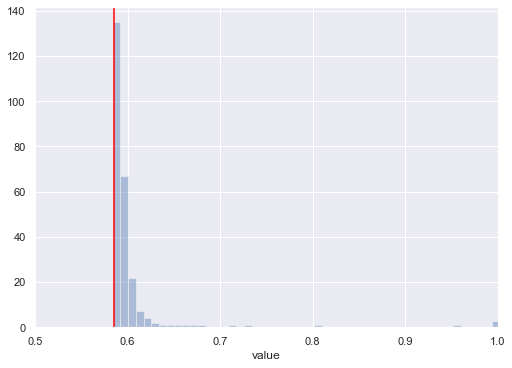

In [267]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.distplot(xgb_study_df.value, bins=50, kde=False)
plt.axvline(xgb_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.5,1);

In [240]:
# using early stopping, adjust learning_rate (decrease) and n_estimators (increase) to improve performance
XGBRegressor(learning_rate=.01, n_estimators=10000, **xgb_params).fit(X_train, y_train, eval_set=[(X_test, y_test)],
                                                      eval_metric='rmse', early_stopping_rounds=250)

[0]	validation_0-rmse:1.07142
Will train until validation_0-rmse hasn't improved in 250 rounds.
[1]	validation_0-rmse:1.06433
[2]	validation_0-rmse:1.05831
[3]	validation_0-rmse:1.05136
[4]	validation_0-rmse:1.04466
[5]	validation_0-rmse:1.03780
[6]	validation_0-rmse:1.03121
[7]	validation_0-rmse:1.02466
[8]	validation_0-rmse:1.01863
[9]	validation_0-rmse:1.01300
[10]	validation_0-rmse:1.00690
[11]	validation_0-rmse:1.00065
[12]	validation_0-rmse:0.99469
[13]	validation_0-rmse:0.98908
[14]	validation_0-rmse:0.98308
[15]	validation_0-rmse:0.97715
[16]	validation_0-rmse:0.97140
[17]	validation_0-rmse:0.96571
[18]	validation_0-rmse:0.95996
[19]	validation_0-rmse:0.95447
[20]	validation_0-rmse:0.94906
[21]	validation_0-rmse:0.94388
[22]	validation_0-rmse:0.93873
[23]	validation_0-rmse:0.93344
[24]	validation_0-rmse:0.92819
[25]	validation_0-rmse:0.92310
[26]	validation_0-rmse:0.91824
[27]	validation_0-rmse:0.91332
[28]	validation_0-rmse:0.90857
[29]	validation_0-rmse:0.90394
[30]	validatio

[258]	validation_0-rmse:0.61484
[259]	validation_0-rmse:0.61470
[260]	validation_0-rmse:0.61441
[261]	validation_0-rmse:0.61431
[262]	validation_0-rmse:0.61407
[263]	validation_0-rmse:0.61389
[264]	validation_0-rmse:0.61373
[265]	validation_0-rmse:0.61359
[266]	validation_0-rmse:0.61344
[267]	validation_0-rmse:0.61323
[268]	validation_0-rmse:0.61308
[269]	validation_0-rmse:0.61292
[270]	validation_0-rmse:0.61270
[271]	validation_0-rmse:0.61256
[272]	validation_0-rmse:0.61230
[273]	validation_0-rmse:0.61221
[274]	validation_0-rmse:0.61197
[275]	validation_0-rmse:0.61179
[276]	validation_0-rmse:0.61165
[277]	validation_0-rmse:0.61150
[278]	validation_0-rmse:0.61134
[279]	validation_0-rmse:0.61130
[280]	validation_0-rmse:0.61122
[281]	validation_0-rmse:0.61104
[282]	validation_0-rmse:0.61086
[283]	validation_0-rmse:0.61070
[284]	validation_0-rmse:0.61055
[285]	validation_0-rmse:0.61042
[286]	validation_0-rmse:0.61028
[287]	validation_0-rmse:0.61017
[288]	validation_0-rmse:0.61006
[289]	va

[515]	validation_0-rmse:0.59401
[516]	validation_0-rmse:0.59392
[517]	validation_0-rmse:0.59393
[518]	validation_0-rmse:0.59383
[519]	validation_0-rmse:0.59383
[520]	validation_0-rmse:0.59383
[521]	validation_0-rmse:0.59383
[522]	validation_0-rmse:0.59381
[523]	validation_0-rmse:0.59372
[524]	validation_0-rmse:0.59366
[525]	validation_0-rmse:0.59366
[526]	validation_0-rmse:0.59366
[527]	validation_0-rmse:0.59363
[528]	validation_0-rmse:0.59364
[529]	validation_0-rmse:0.59356
[530]	validation_0-rmse:0.59349
[531]	validation_0-rmse:0.59346
[532]	validation_0-rmse:0.59345
[533]	validation_0-rmse:0.59347
[534]	validation_0-rmse:0.59342
[535]	validation_0-rmse:0.59342
[536]	validation_0-rmse:0.59342
[537]	validation_0-rmse:0.59339
[538]	validation_0-rmse:0.59340
[539]	validation_0-rmse:0.59331
[540]	validation_0-rmse:0.59325
[541]	validation_0-rmse:0.59325
[542]	validation_0-rmse:0.59326
[543]	validation_0-rmse:0.59323
[544]	validation_0-rmse:0.59325
[545]	validation_0-rmse:0.59324
[546]	va

[772]	validation_0-rmse:0.58971
[773]	validation_0-rmse:0.58969
[774]	validation_0-rmse:0.58964
[775]	validation_0-rmse:0.58964
[776]	validation_0-rmse:0.58964
[777]	validation_0-rmse:0.58962
[778]	validation_0-rmse:0.58962
[779]	validation_0-rmse:0.58962
[780]	validation_0-rmse:0.58961
[781]	validation_0-rmse:0.58961
[782]	validation_0-rmse:0.58961
[783]	validation_0-rmse:0.58961
[784]	validation_0-rmse:0.58963
[785]	validation_0-rmse:0.58965
[786]	validation_0-rmse:0.58965
[787]	validation_0-rmse:0.58965
[788]	validation_0-rmse:0.58962
[789]	validation_0-rmse:0.58962
[790]	validation_0-rmse:0.58962
[791]	validation_0-rmse:0.58957
[792]	validation_0-rmse:0.58957
[793]	validation_0-rmse:0.58952
[794]	validation_0-rmse:0.58952
[795]	validation_0-rmse:0.58951
[796]	validation_0-rmse:0.58952
[797]	validation_0-rmse:0.58952
[798]	validation_0-rmse:0.58951
[799]	validation_0-rmse:0.58951
[800]	validation_0-rmse:0.58953
[801]	validation_0-rmse:0.58951
[802]	validation_0-rmse:0.58951
[803]	va

[1028]	validation_0-rmse:0.58822
[1029]	validation_0-rmse:0.58822
[1030]	validation_0-rmse:0.58822
[1031]	validation_0-rmse:0.58822
[1032]	validation_0-rmse:0.58822
[1033]	validation_0-rmse:0.58823
[1034]	validation_0-rmse:0.58823
[1035]	validation_0-rmse:0.58822
[1036]	validation_0-rmse:0.58822
[1037]	validation_0-rmse:0.58828
[1038]	validation_0-rmse:0.58827
[1039]	validation_0-rmse:0.58827
[1040]	validation_0-rmse:0.58827
[1041]	validation_0-rmse:0.58828
[1042]	validation_0-rmse:0.58828
[1043]	validation_0-rmse:0.58823
[1044]	validation_0-rmse:0.58821
[1045]	validation_0-rmse:0.58819
[1046]	validation_0-rmse:0.58818
[1047]	validation_0-rmse:0.58817
[1048]	validation_0-rmse:0.58818
[1049]	validation_0-rmse:0.58820
[1050]	validation_0-rmse:0.58820
[1051]	validation_0-rmse:0.58820
[1052]	validation_0-rmse:0.58820
[1053]	validation_0-rmse:0.58820
[1054]	validation_0-rmse:0.58820
[1055]	validation_0-rmse:0.58817
[1056]	validation_0-rmse:0.58817
[1057]	validation_0-rmse:0.58817
[1058]	val

[1277]	validation_0-rmse:0.58720
[1278]	validation_0-rmse:0.58720
[1279]	validation_0-rmse:0.58720
[1280]	validation_0-rmse:0.58720
[1281]	validation_0-rmse:0.58715
[1282]	validation_0-rmse:0.58715
[1283]	validation_0-rmse:0.58711
[1284]	validation_0-rmse:0.58711
[1285]	validation_0-rmse:0.58715
[1286]	validation_0-rmse:0.58715
[1287]	validation_0-rmse:0.58709
[1288]	validation_0-rmse:0.58710
[1289]	validation_0-rmse:0.58710
[1290]	validation_0-rmse:0.58710
[1291]	validation_0-rmse:0.58710
[1292]	validation_0-rmse:0.58712
[1293]	validation_0-rmse:0.58712
[1294]	validation_0-rmse:0.58712
[1295]	validation_0-rmse:0.58712
[1296]	validation_0-rmse:0.58712
[1297]	validation_0-rmse:0.58710
[1298]	validation_0-rmse:0.58705
[1299]	validation_0-rmse:0.58705
[1300]	validation_0-rmse:0.58705
[1301]	validation_0-rmse:0.58705
[1302]	validation_0-rmse:0.58709
[1303]	validation_0-rmse:0.58707
[1304]	validation_0-rmse:0.58707
[1305]	validation_0-rmse:0.58707
[1306]	validation_0-rmse:0.58708
[1307]	val

[1526]	validation_0-rmse:0.58635
[1527]	validation_0-rmse:0.58629
[1528]	validation_0-rmse:0.58629
[1529]	validation_0-rmse:0.58629
[1530]	validation_0-rmse:0.58626
[1531]	validation_0-rmse:0.58626
[1532]	validation_0-rmse:0.58627
[1533]	validation_0-rmse:0.58627
[1534]	validation_0-rmse:0.58627
[1535]	validation_0-rmse:0.58627
[1536]	validation_0-rmse:0.58627
[1537]	validation_0-rmse:0.58627
[1538]	validation_0-rmse:0.58627
[1539]	validation_0-rmse:0.58621
[1540]	validation_0-rmse:0.58621
[1541]	validation_0-rmse:0.58621
[1542]	validation_0-rmse:0.58621
[1543]	validation_0-rmse:0.58621
[1544]	validation_0-rmse:0.58621
[1545]	validation_0-rmse:0.58615
[1546]	validation_0-rmse:0.58615
[1547]	validation_0-rmse:0.58615
[1548]	validation_0-rmse:0.58615
[1549]	validation_0-rmse:0.58615
[1550]	validation_0-rmse:0.58614
[1551]	validation_0-rmse:0.58614
[1552]	validation_0-rmse:0.58616
[1553]	validation_0-rmse:0.58616
[1554]	validation_0-rmse:0.58615
[1555]	validation_0-rmse:0.58615
[1556]	val

[1775]	validation_0-rmse:0.58555
[1776]	validation_0-rmse:0.58555
[1777]	validation_0-rmse:0.58555
[1778]	validation_0-rmse:0.58555
[1779]	validation_0-rmse:0.58555
[1780]	validation_0-rmse:0.58555
[1781]	validation_0-rmse:0.58555
[1782]	validation_0-rmse:0.58556
[1783]	validation_0-rmse:0.58556
[1784]	validation_0-rmse:0.58556
[1785]	validation_0-rmse:0.58556
[1786]	validation_0-rmse:0.58556
[1787]	validation_0-rmse:0.58556
[1788]	validation_0-rmse:0.58555
[1789]	validation_0-rmse:0.58557
[1790]	validation_0-rmse:0.58557
[1791]	validation_0-rmse:0.58557
[1792]	validation_0-rmse:0.58557
[1793]	validation_0-rmse:0.58557
[1794]	validation_0-rmse:0.58557
[1795]	validation_0-rmse:0.58557
[1796]	validation_0-rmse:0.58557
[1797]	validation_0-rmse:0.58557
[1798]	validation_0-rmse:0.58556
[1799]	validation_0-rmse:0.58556
[1800]	validation_0-rmse:0.58556
[1801]	validation_0-rmse:0.58556
[1802]	validation_0-rmse:0.58555
[1803]	validation_0-rmse:0.58555
[1804]	validation_0-rmse:0.58554
[1805]	val

[2024]	validation_0-rmse:0.58518
[2025]	validation_0-rmse:0.58519
[2026]	validation_0-rmse:0.58519
[2027]	validation_0-rmse:0.58519
[2028]	validation_0-rmse:0.58519
[2029]	validation_0-rmse:0.58516
[2030]	validation_0-rmse:0.58517
[2031]	validation_0-rmse:0.58517
[2032]	validation_0-rmse:0.58510
[2033]	validation_0-rmse:0.58510
[2034]	validation_0-rmse:0.58510
[2035]	validation_0-rmse:0.58514
[2036]	validation_0-rmse:0.58521
[2037]	validation_0-rmse:0.58521
[2038]	validation_0-rmse:0.58521
[2039]	validation_0-rmse:0.58521
[2040]	validation_0-rmse:0.58521
[2041]	validation_0-rmse:0.58523
[2042]	validation_0-rmse:0.58522
[2043]	validation_0-rmse:0.58522
[2044]	validation_0-rmse:0.58523
[2045]	validation_0-rmse:0.58522
[2046]	validation_0-rmse:0.58522
[2047]	validation_0-rmse:0.58522
[2048]	validation_0-rmse:0.58522
[2049]	validation_0-rmse:0.58522
[2050]	validation_0-rmse:0.58522
[2051]	validation_0-rmse:0.58522
[2052]	validation_0-rmse:0.58522
[2053]	validation_0-rmse:0.58525
[2054]	val

[2273]	validation_0-rmse:0.58496
[2274]	validation_0-rmse:0.58496
[2275]	validation_0-rmse:0.58496
[2276]	validation_0-rmse:0.58497
[2277]	validation_0-rmse:0.58497
[2278]	validation_0-rmse:0.58497
[2279]	validation_0-rmse:0.58497
[2280]	validation_0-rmse:0.58497
[2281]	validation_0-rmse:0.58497
[2282]	validation_0-rmse:0.58497
[2283]	validation_0-rmse:0.58498
[2284]	validation_0-rmse:0.58498
[2285]	validation_0-rmse:0.58498
[2286]	validation_0-rmse:0.58498
[2287]	validation_0-rmse:0.58498
[2288]	validation_0-rmse:0.58498
[2289]	validation_0-rmse:0.58495
[2290]	validation_0-rmse:0.58495
[2291]	validation_0-rmse:0.58499
[2292]	validation_0-rmse:0.58494
[2293]	validation_0-rmse:0.58494
[2294]	validation_0-rmse:0.58494
[2295]	validation_0-rmse:0.58494
[2296]	validation_0-rmse:0.58493
[2297]	validation_0-rmse:0.58493
[2298]	validation_0-rmse:0.58496
[2299]	validation_0-rmse:0.58496
[2300]	validation_0-rmse:0.58496
[2301]	validation_0-rmse:0.58496
[2302]	validation_0-rmse:0.58496
[2303]	val

[2522]	validation_0-rmse:0.58472
[2523]	validation_0-rmse:0.58472
[2524]	validation_0-rmse:0.58472
[2525]	validation_0-rmse:0.58473
[2526]	validation_0-rmse:0.58473
[2527]	validation_0-rmse:0.58475
[2528]	validation_0-rmse:0.58475
[2529]	validation_0-rmse:0.58475
[2530]	validation_0-rmse:0.58475
[2531]	validation_0-rmse:0.58473
[2532]	validation_0-rmse:0.58473
[2533]	validation_0-rmse:0.58469
[2534]	validation_0-rmse:0.58468
[2535]	validation_0-rmse:0.58468
[2536]	validation_0-rmse:0.58468
[2537]	validation_0-rmse:0.58468
[2538]	validation_0-rmse:0.58468
[2539]	validation_0-rmse:0.58468
[2540]	validation_0-rmse:0.58468
[2541]	validation_0-rmse:0.58468
[2542]	validation_0-rmse:0.58468
[2543]	validation_0-rmse:0.58468
[2544]	validation_0-rmse:0.58468
[2545]	validation_0-rmse:0.58468
[2546]	validation_0-rmse:0.58468
[2547]	validation_0-rmse:0.58468
[2548]	validation_0-rmse:0.58467
[2549]	validation_0-rmse:0.58467
[2550]	validation_0-rmse:0.58467
[2551]	validation_0-rmse:0.58466
[2552]	val

[2771]	validation_0-rmse:0.58437
[2772]	validation_0-rmse:0.58437
[2773]	validation_0-rmse:0.58437
[2774]	validation_0-rmse:0.58433
[2775]	validation_0-rmse:0.58433
[2776]	validation_0-rmse:0.58433
[2777]	validation_0-rmse:0.58431
[2778]	validation_0-rmse:0.58432
[2779]	validation_0-rmse:0.58432
[2780]	validation_0-rmse:0.58432
[2781]	validation_0-rmse:0.58432
[2782]	validation_0-rmse:0.58432
[2783]	validation_0-rmse:0.58428
[2784]	validation_0-rmse:0.58425
[2785]	validation_0-rmse:0.58425
[2786]	validation_0-rmse:0.58428
[2787]	validation_0-rmse:0.58428
[2788]	validation_0-rmse:0.58427
[2789]	validation_0-rmse:0.58427
[2790]	validation_0-rmse:0.58427
[2791]	validation_0-rmse:0.58427
[2792]	validation_0-rmse:0.58427
[2793]	validation_0-rmse:0.58427
[2794]	validation_0-rmse:0.58427
[2795]	validation_0-rmse:0.58427
[2796]	validation_0-rmse:0.58428
[2797]	validation_0-rmse:0.58428
[2798]	validation_0-rmse:0.58428
[2799]	validation_0-rmse:0.58428
[2800]	validation_0-rmse:0.58428
[2801]	val

[3020]	validation_0-rmse:0.58413
[3021]	validation_0-rmse:0.58414
[3022]	validation_0-rmse:0.58414
[3023]	validation_0-rmse:0.58414
[3024]	validation_0-rmse:0.58413
[3025]	validation_0-rmse:0.58414
[3026]	validation_0-rmse:0.58413
[3027]	validation_0-rmse:0.58413
[3028]	validation_0-rmse:0.58413
[3029]	validation_0-rmse:0.58413
[3030]	validation_0-rmse:0.58413
[3031]	validation_0-rmse:0.58414
[3032]	validation_0-rmse:0.58413
[3033]	validation_0-rmse:0.58413
[3034]	validation_0-rmse:0.58413
[3035]	validation_0-rmse:0.58413
[3036]	validation_0-rmse:0.58414
[3037]	validation_0-rmse:0.58413
[3038]	validation_0-rmse:0.58412
[3039]	validation_0-rmse:0.58412
[3040]	validation_0-rmse:0.58412
[3041]	validation_0-rmse:0.58412
[3042]	validation_0-rmse:0.58412
[3043]	validation_0-rmse:0.58412
[3044]	validation_0-rmse:0.58412
[3045]	validation_0-rmse:0.58410
[3046]	validation_0-rmse:0.58410
[3047]	validation_0-rmse:0.58410
[3048]	validation_0-rmse:0.58410
[3049]	validation_0-rmse:0.58410
[3050]	val

[3269]	validation_0-rmse:0.58381
[3270]	validation_0-rmse:0.58379
[3271]	validation_0-rmse:0.58379
[3272]	validation_0-rmse:0.58380
[3273]	validation_0-rmse:0.58380
[3274]	validation_0-rmse:0.58380
[3275]	validation_0-rmse:0.58379
[3276]	validation_0-rmse:0.58379
[3277]	validation_0-rmse:0.58379
[3278]	validation_0-rmse:0.58379
[3279]	validation_0-rmse:0.58379
[3280]	validation_0-rmse:0.58379
[3281]	validation_0-rmse:0.58379
[3282]	validation_0-rmse:0.58379
[3283]	validation_0-rmse:0.58384
[3284]	validation_0-rmse:0.58384
[3285]	validation_0-rmse:0.58384
[3286]	validation_0-rmse:0.58384
[3287]	validation_0-rmse:0.58384
[3288]	validation_0-rmse:0.58384
[3289]	validation_0-rmse:0.58384
[3290]	validation_0-rmse:0.58384
[3291]	validation_0-rmse:0.58384
[3292]	validation_0-rmse:0.58384
[3293]	validation_0-rmse:0.58384
[3294]	validation_0-rmse:0.58384
[3295]	validation_0-rmse:0.58384
[3296]	validation_0-rmse:0.58383
[3297]	validation_0-rmse:0.58384
[3298]	validation_0-rmse:0.58383
[3299]	val

[3518]	validation_0-rmse:0.58366
[3519]	validation_0-rmse:0.58366
[3520]	validation_0-rmse:0.58366
[3521]	validation_0-rmse:0.58366
[3522]	validation_0-rmse:0.58365
[3523]	validation_0-rmse:0.58365
[3524]	validation_0-rmse:0.58365
[3525]	validation_0-rmse:0.58365
[3526]	validation_0-rmse:0.58362
[3527]	validation_0-rmse:0.58362
[3528]	validation_0-rmse:0.58362
[3529]	validation_0-rmse:0.58361
[3530]	validation_0-rmse:0.58362
[3531]	validation_0-rmse:0.58362
[3532]	validation_0-rmse:0.58362
[3533]	validation_0-rmse:0.58362
[3534]	validation_0-rmse:0.58362
[3535]	validation_0-rmse:0.58361
[3536]	validation_0-rmse:0.58361
[3537]	validation_0-rmse:0.58361
[3538]	validation_0-rmse:0.58361
[3539]	validation_0-rmse:0.58361
[3540]	validation_0-rmse:0.58361
[3541]	validation_0-rmse:0.58361
[3542]	validation_0-rmse:0.58362
[3543]	validation_0-rmse:0.58361
[3544]	validation_0-rmse:0.58361
[3545]	validation_0-rmse:0.58361
[3546]	validation_0-rmse:0.58361
[3547]	validation_0-rmse:0.58361
[3548]	val

[3767]	validation_0-rmse:0.58343
[3768]	validation_0-rmse:0.58343
[3769]	validation_0-rmse:0.58343
[3770]	validation_0-rmse:0.58342
[3771]	validation_0-rmse:0.58342
[3772]	validation_0-rmse:0.58342
[3773]	validation_0-rmse:0.58342
[3774]	validation_0-rmse:0.58342
[3775]	validation_0-rmse:0.58342
[3776]	validation_0-rmse:0.58342
[3777]	validation_0-rmse:0.58342
[3778]	validation_0-rmse:0.58342
[3779]	validation_0-rmse:0.58341
[3780]	validation_0-rmse:0.58341
[3781]	validation_0-rmse:0.58341
[3782]	validation_0-rmse:0.58341
[3783]	validation_0-rmse:0.58344
[3784]	validation_0-rmse:0.58344
[3785]	validation_0-rmse:0.58344
[3786]	validation_0-rmse:0.58344
[3787]	validation_0-rmse:0.58344
[3788]	validation_0-rmse:0.58344
[3789]	validation_0-rmse:0.58340
[3790]	validation_0-rmse:0.58341
[3791]	validation_0-rmse:0.58341
[3792]	validation_0-rmse:0.58341
[3793]	validation_0-rmse:0.58341
[3794]	validation_0-rmse:0.58340
[3795]	validation_0-rmse:0.58340
[3796]	validation_0-rmse:0.58340
[3797]	val

[4016]	validation_0-rmse:0.58325
[4017]	validation_0-rmse:0.58325
[4018]	validation_0-rmse:0.58325
[4019]	validation_0-rmse:0.58325
[4020]	validation_0-rmse:0.58324
[4021]	validation_0-rmse:0.58324
[4022]	validation_0-rmse:0.58319
[4023]	validation_0-rmse:0.58319
[4024]	validation_0-rmse:0.58319
[4025]	validation_0-rmse:0.58319
[4026]	validation_0-rmse:0.58319
[4027]	validation_0-rmse:0.58319
[4028]	validation_0-rmse:0.58319
[4029]	validation_0-rmse:0.58319
[4030]	validation_0-rmse:0.58319
[4031]	validation_0-rmse:0.58319
[4032]	validation_0-rmse:0.58319
[4033]	validation_0-rmse:0.58319
[4034]	validation_0-rmse:0.58318
[4035]	validation_0-rmse:0.58319
[4036]	validation_0-rmse:0.58319
[4037]	validation_0-rmse:0.58319
[4038]	validation_0-rmse:0.58319
[4039]	validation_0-rmse:0.58319
[4040]	validation_0-rmse:0.58319
[4041]	validation_0-rmse:0.58321
[4042]	validation_0-rmse:0.58321
[4043]	validation_0-rmse:0.58322
[4044]	validation_0-rmse:0.58322
[4045]	validation_0-rmse:0.58321
[4046]	val

[4265]	validation_0-rmse:0.58315
[4266]	validation_0-rmse:0.58315
[4267]	validation_0-rmse:0.58315
[4268]	validation_0-rmse:0.58319
[4269]	validation_0-rmse:0.58319
[4270]	validation_0-rmse:0.58319
[4271]	validation_0-rmse:0.58319
[4272]	validation_0-rmse:0.58319
[4273]	validation_0-rmse:0.58321
[4274]	validation_0-rmse:0.58321
[4275]	validation_0-rmse:0.58321
[4276]	validation_0-rmse:0.58321
[4277]	validation_0-rmse:0.58321
[4278]	validation_0-rmse:0.58321
[4279]	validation_0-rmse:0.58325
[4280]	validation_0-rmse:0.58325
[4281]	validation_0-rmse:0.58325
[4282]	validation_0-rmse:0.58325
[4283]	validation_0-rmse:0.58325
[4284]	validation_0-rmse:0.58325
[4285]	validation_0-rmse:0.58325
[4286]	validation_0-rmse:0.58325
[4287]	validation_0-rmse:0.58325
[4288]	validation_0-rmse:0.58324
[4289]	validation_0-rmse:0.58323
[4290]	validation_0-rmse:0.58323
[4291]	validation_0-rmse:0.58323
[4292]	validation_0-rmse:0.58323
[4293]	validation_0-rmse:0.58323
[4294]	validation_0-rmse:0.58323
[4295]	val

[4514]	validation_0-rmse:0.58340
[4515]	validation_0-rmse:0.58339
[4516]	validation_0-rmse:0.58339
Stopping. Best iteration:
[4266]	validation_0-rmse:0.58315



XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=0.731594483762459,
             colsample_bynode=0.922244132390617,
             colsample_bytree=0.8161475925462282, gamma=2.0344872823591706,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=25,
             min_child_weight=51, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1294492621952765, reg_lambda=1.1098516840076096e-07,
             scale_pos_weight=1, subsample=0.9801508551140246, tree_method=None,
             validate_parameters=False, verbosity=None)

In [241]:
xgb_params['learning_rate'] = .01
xgb_params['n_estimators'] = 4266

In [242]:
# calculate CV score using same folds as every other model
scores = cross_val_score(XGBRegressor(**xgb_params), X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
xgb_score = np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score
xgb_score

0.5776942717041235

### Level-1 Models Analysis

In [276]:
best_scores = pd.DataFrame(data=[knn_score, en_score, svr_score, rf_score, xgb_score], index=['KNN', 'EN', 'SVR', 'RF', 'XGB'],
                           columns=['RMSLE'])
best_scores.sort_values('RMSLE', ascending=False)

RMSLE
SVR  0.944050
KNN  0.762202
RF   0.592866
EN   0.579747
XGB  0.577694

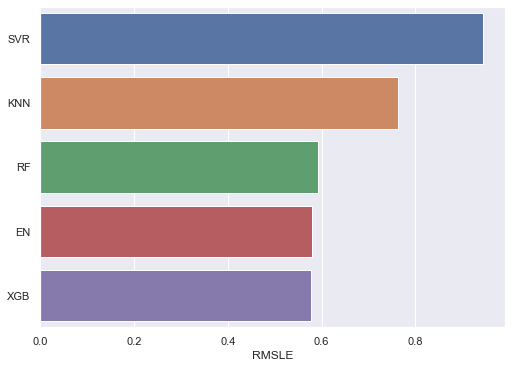

In [278]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.barplot(best_scores.sort_values('RMSLE', ascending=False).RMSLE, best_scores.sort_values('RMSLE', ascending=False).index);

In [279]:
# create an array of out-of-bag predictions for each of the four models (with tuned hyperparameters from above);
# then, concatenate them into a single array (X_train_oob);
# the final estimator of the stack will be tuned on these predictions
knn_oob = cross_val_predict(KNeighborsRegressor(**knn_params), X_train, y_train, cv=cv, n_jobs=-1)
en_oob = cross_val_predict(ElasticNet(**en_params), X_train, y_train, cv=cv, n_jobs=-1)
svr_oob = cross_val_predict(SVR(**svr_params), X_train, y_train, cv=cv, n_jobs=-1)
rf_oob = cross_val_predict(RandomForestRegressor(**rf_params), X_train, y_train, cv=cv, n_jobs=-1)
xgb_oob = cross_val_predict(XGBRegressor(**xgb_params), X_train, y_train, cv=cv, n_jobs=-1)
X_train_oob = (pd.DataFrame(data=[knn_oob, en_oob, svr_oob, rf_oob, xgb_oob], index=['KNN', 'EN', 'SVR', 'RF', 'XGB'], columns=X_train.index)).T

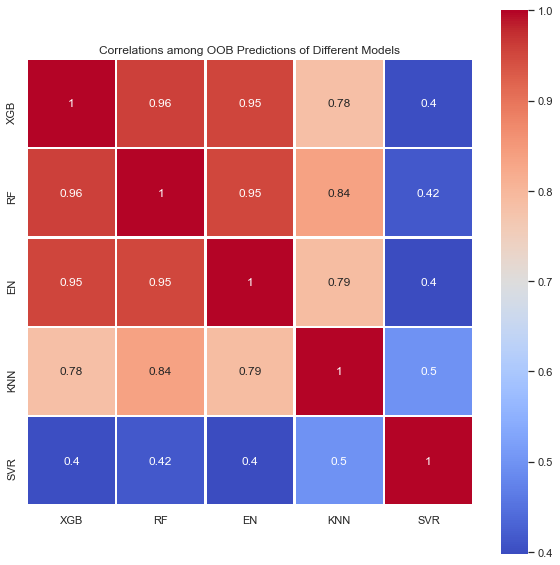

In [282]:
plt.figure(figsize=(10,10))
plt.title('Correlations among OOB Predictions of Different Models')
sns.heatmap(X_train_oob.corr().sort_values('XGB', ascending=False, axis=1).sort_values('XGB', ascending=False, axis=0), annot=True, square=True, linewidths=1.5, cmap='coolwarm');

## Meta-Model

In [283]:
# tune hyper-parameters of the final model of the stack
def metamodel_objective(trial):
    params = {'alpha': trial.suggest_loguniform('alpha', 1e-15, 10)}
    
    scores = cross_val_score(Lasso(**params), X_train_oob, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score
    
metamodel_study = optuna.create_study(direction='minimize')
metamodel_study.optimize(metamodel_objective, n_trials=100)
joblib.dump(metamodel_study, 'metamodel_study.pkl')

metamodel_study_df = metamodel_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(metamodel_study_df)

[I 2020-08-12 02:48:05,371] Finished trial#0 with value: 0.5682023074189451 with parameters: {'alpha': 3.8501292168290636e-09}. Best is trial#0 with value: 0.5682023074189451.
[I 2020-08-12 02:48:05,596] Finished trial#1 with value: 0.5682023077496569 with parameters: {'alpha': 1.0867818188110602e-15}. Best is trial#0 with value: 0.5682023074189451.
[I 2020-08-12 02:48:05,799] Finished trial#2 with value: 0.5682023077462509 with parameters: {'alpha': 2.5378287881488765e-11}. Best is trial#0 with value: 0.5682023074189451.
[I 2020-08-12 02:48:05,997] Finished trial#3 with value: 0.5682023077371656 with parameters: {'alpha': 1.1116160399570403e-10}. Best is trial#0 with value: 0.5682023074189451.
[I 2020-08-12 02:48:06,194] Finished trial#4 with value: 0.5682005106050183 with parameters: {'alpha': 2.1043951874063506e-05}. Best is trial#4 with value: 0.5682005106050183.
[I 2020-08-12 02:48:06,373] Finished trial#5 with value: 0.5704704807260121 with parameters: {'alpha': 0.031072355440088

[I 2020-08-12 02:48:14,460] Finished trial#46 with value: 1.0002145795164172 with parameters: {'alpha': 0.8937493001097097}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:14,644] Finished trial#47 with value: 0.5701977536783795 with parameters: {'alpha': 0.028065164682459034}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:14,834] Finished trial#48 with value: 0.5681774126798103 with parameters: {'alpha': 0.00023528814475962283}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:15,019] Finished trial#49 with value: 0.5680754295180211 with parameters: {'alpha': 0.002888809748991619}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:15,237] Finished trial#50 with value: 0.5681971168384066 with parameters: {'alpha': 6.261163175420545e-05}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:15,439] Finished trial#51 with value: 0.5680842012669057 with parameters: {'alpha': 0.0030132003223

[I 2020-08-12 02:48:22,843] Finished trial#92 with value: 0.5684049373505096 with parameters: {'alpha': 0.0050568146141753536}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:23,029] Finished trial#93 with value: 0.5680650198113153 with parameters: {'alpha': 0.0018728933583754713}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:23,207] Finished trial#94 with value: 0.5681310173157528 with parameters: {'alpha': 0.0008519428220688566}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:23,384] Finished trial#95 with value: 0.5681915792463551 with parameters: {'alpha': 0.00011399357456552011}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:23,568] Finished trial#96 with value: 0.5680597252730539 with parameters: {'alpha': 0.0020617345701503067}. Best is trial#21 with value: 0.5680552642995119.
[I 2020-08-12 02:48:23,747] Finished trial#97 with value: 0.5681418016565611 with parameters: {'alpha': 0.00071824

['metamodel_study.pkl']

In [ ]:
# best RMSLE score and corresponding hyper-parameters of the final model in the stack
metamodel_study.best_value
metamodel_study.best_params
optuna.visualization.plot_slice(metamodel_study)

In [293]:
PT = .02
metamodel_study_df[metamodel_study_df.value == metamodel_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first')
stack_score = metamodel_study_df[metamodel_study_df.value == metamodel_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').iloc[0]['value']
metamodel_params = metamodel_study_df[metamodel_study_df.value == metamodel_study_df.value.quantile(PT, interpolation='higher')]\
    .nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')[0]

value     alpha
81  0.568056  0.002266

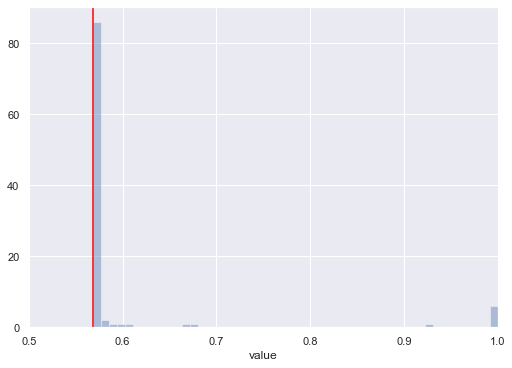

In [287]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.distplot(metamodel_study_df.value, bins=50, kde=False)
plt.axvline(metamodel_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.5,1);

In [296]:
best_scores.loc['Stack', 'RMSLE'] = stack_score
best_scores.sort_values('RMSLE', ascending=False)

RMSLE
SVR    0.944050
KNN    0.762202
RF     0.592866
EN     0.579747
XGB    0.577694
Stack  0.568056

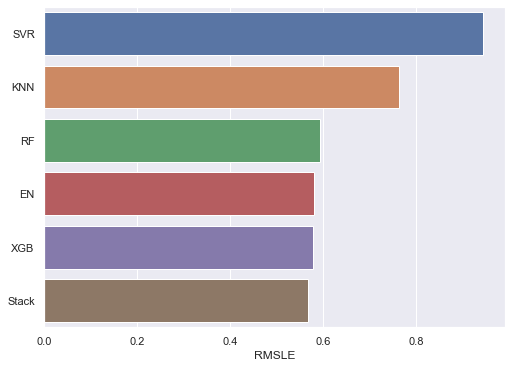

In [297]:
plt.figure(figsize=(7,5), constrained_layout=True)
sns.barplot(best_scores.sort_values('RMSLE', ascending=False).RMSLE, best_scores.sort_values('RMSLE', ascending=False).index)
plt.xticks();

In [303]:
# combine preprocessing pipeline, four level-1 models, and meta-model into a stack
# this way we will have the entire model in one place (stack_pipe)
stack = StackingRegressor([('knn', KNeighborsRegressor(**knn_params)),
                           ('en', ElasticNet(**en_params)),
                           ('svr', SVR(**svr_params)),
                           ('rf', RandomForestRegressor(**rf_params)),
                           ('xgb', XGBRegressor(**xgb_params))],
                          final_estimator=Lasso(**metamodel_params),
                          passthrough=False)

# Final Submission

In [306]:
# before making predictions on predict set for submission, let's calculate error on held-out test set (X_test, y_test)
stack.fit(X_train, y_train)    # fit stack on X_train, y_train
X_test_predictions = stack.predict(X_test)    # make predictions on X_test
mean_squared_error(y_test, X_test_predictions, squared=False)    # RMSLE

StackingRegressor(estimators=[('knn', KNeighborsRegressor(n_neighbors=27, p=1)),
                              ('en',
                               ElasticNet(alpha=0.0015613838805379177,
                                          l1_ratio=0.8238457389910202)),
                              ('svr',
                               SVR(C=0.8463145895714175,
                                   gamma=1.0099542025701474e-10)),
                              ('rf',
                               RandomForestRegressor(max_depth=64,
                                                     max_features=0.2535934861762467,
                                                     max_leaf_nodes=249,
                                                     max_samples=0.7922926753093681)),
                              ('xgb',
                               XG...
                                            min_child_weight=51, missing=nan,
                                            monotone_constraints=None,
  

0.5742832105186207

In [308]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [313]:
# make predictions on predict set for submission
stack.fit(X, y)    # fit stack on all available ground truth data, i.e. (X_train + X_test, y_train + y_test)
predictions = stack.predict(X_predict)    # make predictions for submission; revert logs of SalePrice back to SalePrice
predictions = revenue_transformer.inverse_transform(predictions.reshape(-1,1))

StackingRegressor(estimators=[('knn', KNeighborsRegressor(n_neighbors=27, p=1)),
                              ('en',
                               ElasticNet(alpha=0.0015613838805379177,
                                          l1_ratio=0.8238457389910202)),
                              ('svr',
                               SVR(C=0.8463145895714175,
                                   gamma=1.0099542025701474e-10)),
                              ('rf',
                               RandomForestRegressor(max_depth=64,
                                                     max_features=0.2535934861762467,
                                                     max_leaf_nodes=249,
                                                     max_samples=0.7922926753093681)),
                              ('xgb',
                               XG...
                                            min_child_weight=51, missing=nan,
                                            monotone_constraints=None,
  

In [364]:
# prepare submission file with Id's and corresponding final predictions
predict = pd.read_csv('test.csv')
predict_ids = predict.id
predictions = pd.DataFrame({'id': predict_ids, 'revenue': predictions.flatten()})
predictions.to_csv('predictions.csv', index=False)